In [13]:
import torch
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from torch.utils.data import random_split
from scipy.spatial.distance import directed_hausdorff
from augmentation import augment
torch.manual_seed(42)
from scipy.signal import stft, istft
from scipy.signal.windows import hann
import torch.nn.functional as F

mps


In [14]:
num_subclasses = 1000
epochs = 1000
seq_size = 250
batch_size = 32
num_aug = 5
split_size=0.8
lr = 5e-5
output_channel = 2

In [15]:
#ENSURE GRADIENTS IN STFT


In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import stft, istft, windows



# STFT Parameters
nperseg = 30
noverlap = 20
window = windows.hann(nperseg)

def transform_STFT(x):
    """
    x: tensor of shape [L] (1D signal)
    Returns: tensor of shape [2, F, T]
    """
    x = x.cpu().numpy()
    f, t, Zxx = stft(x, window=window, nperseg=nperseg, noverlap=noverlap,
                     boundary=None, padded=False)
    real_part = np.real(Zxx)
    imag_part = np.imag(Zxx)
    transformed = np.stack((real_part, imag_part), axis=0)  # shape: [2, F, T]
    return torch.tensor(transformed, dtype=torch.float32)

def inverse_STFT(real_imag, seq_size=None):
    """
    real_imag: tensor of shape [2, F, T]
    seq_size: crop output to this length (optional)
    Returns: tensor of shape [L]
    """
    real_imag = real_imag.cpu().numpy()
    real = real_imag[0]
    imag = real_imag[1]
    Zxx = real + 1j * imag
    _, x_reconstructed = istft(Zxx, window=window, nperseg=nperseg, noverlap=noverlap,
                               input_onesided=True, boundary=None)
    if seq_size is not None:
        x_reconstructed = x_reconstructed[:seq_size]
    return torch.tensor(x_reconstructed, dtype=torch.float32)


In [17]:
X, _ = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
X = X.reshape(int(num_subclasses), int(1000 / seq_size), seq_size, 12)
X = X.reshape(int(num_subclasses * int(1000 / seq_size)), seq_size, 12)
train_size = int(split_size*len(X))
test_size = len(X) - train_size
X,X_test = random_split(X,[train_size, test_size])
X = augment(X)
X_input = X[:, :, 0]  # First channel
Y_target = X[:, :, output_channel]  # Second channel
X_input_2D = torch.stack([transform_STFT(sample) for sample in X_input]) 
Y_target_2D = torch.stack([transform_STFT(sample) for sample in Y_target])
print(X_input_2D.shape, Y_target_2D.shape)

X_test_tensors = [X_test.dataset[idx] for idx in range(len(X_test))] 
X_test_tensor = torch.stack(X_test_tensors) 
X_t = X_test_tensor[:, :, 0]  
Y_t = X_test_tensor[:, :, output_channel]

torch.Size([35200, 2, 16, 23]) torch.Size([35200, 2, 16, 23])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STFTGenerator(nn.Module):
    def __init__(self, in_channels=4, code_dim=32, out_channels=2, dropout_prob=0.3):
        super(STFTGenerator, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 50, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_prob),  # Dropout on conv features
            nn.MaxPool2d(2),

            nn.Conv2d(50, 80, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_prob),
            nn.MaxPool2d(2),
        )
        
        # Fully connected (code) layers
        self.fc1 = nn.Linear(1600, 768)
        self.dropout_fc1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(768, code_dim)
        
        self.fc3 = nn.Linear(code_dim, 768)
        self.dropout_fc3 = nn.Dropout(dropout_prob)

        self.fc4 = nn.Linear(512, 1600)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(80, 50, kernel_size=2, stride=2),
            nn.ReLU(),

            nn.ConvTranspose2d(50, 24, kernel_size=(2,4), stride=(2,2), output_padding=(0,1)),
            nn.ReLU(),

            nn.Conv2d(24, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)                     # [B, 80, 4, 5]
        x = x.view(x.size(0), -1)               # Flatten [B, 1600]
        
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        
        code = self.fc2(x)
        
        x = F.relu(self.fc3(code))
        x = self.dropout_fc3(x)
        
        x = F.relu(self.fc4(x))
        x = x.view(x.size(0), 80, 4, 5)         # Reshape for decoder
        x = self.decoder(x)
        return x


In [19]:
class Discriminator2D(nn.Module):
    def __init__(self, num_filters=32):
        super(Discriminator2D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, num_filters, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),

            nn.Conv2d(num_filters, num_filters * 2, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(num_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_filters * 4),
            nn.LeakyReLU(0.2),
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(num_filters * 8 * 2 * 1, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return self.sigmoid(x)




# Initialize the discriminator
disc = Discriminator2D().to(device)
x = torch.randn(1, 4, 16, 23).to(device)  # Example input
output = disc(x)
print("shape:", output.shape)
from torchsummary import summary
summary(disc.cpu(), input_size=(4, 16, 23))

shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 8, 11]           2,080
         LeakyReLU-2            [-1, 32, 8, 11]               0
            Conv2d-3             [-1, 64, 4, 5]          32,832
       BatchNorm2d-4             [-1, 64, 4, 5]             128
         LeakyReLU-5             [-1, 64, 4, 5]               0
            Conv2d-6            [-1, 128, 2, 2]         131,200
       BatchNorm2d-7            [-1, 128, 2, 2]             256
         LeakyReLU-8            [-1, 128, 2, 2]               0
           Flatten-9                  [-1, 512]               0
           Linear-10                    [-1, 1]             513
          Sigmoid-11                    [-1, 1]               0
Total params: 167,009
Trainable params: 167,009
Non-trainable params: 0
----------------------------------------------------------------
Inpu

In [20]:
dataset = TensorDataset(X_input_2D, Y_target_2D)
test_dataset = TensorDataset(X_t, Y_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
generator = STFTGenerator().to(device)
discriminator = Discriminator2D().to(device)
#criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0005)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
print(sum(p.numel() for p in generator.parameters())/1e6, 'M parameters for Generator')
print(sum(p.numel() for p in discriminator.parameters())/1e6, 'M parameters for Discriminator')

1.737862 M parameters for Generator
0.167009 M parameters for Discriminator


In [21]:
def plot_losses(d_losses, g_losses):
    def smooth_curve(points, factor=0.9):
        smoothed = []
        for point in points:
            if smoothed:
                smoothed.append(smoothed[-1] * factor + point * (1 - factor))
            else:
                smoothed.append(point)
        return smoothed

    plt.plot(smooth_curve(d_losses), label='D Loss')
    plt.plot(smooth_curve(g_losses), label='G Loss')
    plt.legend()
    plt.show()

In [22]:
def l1_loss(x,y):
    return torch.mean(torch.abs(x - y))

In [23]:
counter = 0
def plotWave(X, Y, c=0):
    x_np = X.squeeze(0).detach().cpu().numpy()
    y_np = Y.squeeze(0).detach().cpu().numpy()

    # Plotting
    plt.figure(figsize=(20, 6))
    plt.plot(x_np, color='blue', label='X (Generated Signal)')
    plt.plot(y_np, color='red', label='Y (Real Signal)')
    plt.legend()
    plt.title(f'Wave Comparison - Frame {c}')
    plt.show()

    # MSE
    mse = np.mean((x_np - y_np) ** 2)
    # FD
    fd = max(directed_hausdorff(x_np.reshape(-1, 1), y_np.reshape(-1, 1))[0],
             directed_hausdorff(y_np.reshape(-1, 1), x_np.reshape(-1, 1))[0])

    print(f"Frame {c}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Fréchet Distance: {fd:.4f}")

    return c + 1


Epoch 1/1000, Discrimiator Loss: 0.6964147090911865, Generator Loss: 0.5564966201782227
Epoch 2/1000, Discrimiator Loss: 0.6946238279342651, Generator Loss: 0.5858163833618164
Epoch 3/1000, Discrimiator Loss: 0.7087885141372681, Generator Loss: 0.5586250424385071
Epoch 4/1000, Discrimiator Loss: 0.7197975516319275, Generator Loss: 0.554154098033905
Epoch 5/1000, Discrimiator Loss: 0.6715907454490662, Generator Loss: 0.5921280384063721
Epoch 6/1000, Discrimiator Loss: 0.6274187564849854, Generator Loss: 0.735863208770752
Epoch 7/1000, Discrimiator Loss: 0.640058159828186, Generator Loss: 0.8834963440895081
Epoch 8/1000, Discrimiator Loss: 0.3378527760505676, Generator Loss: 1.123434066772461
Epoch 9/1000, Discrimiator Loss: 0.187981516122818, Generator Loss: 2.1025278568267822


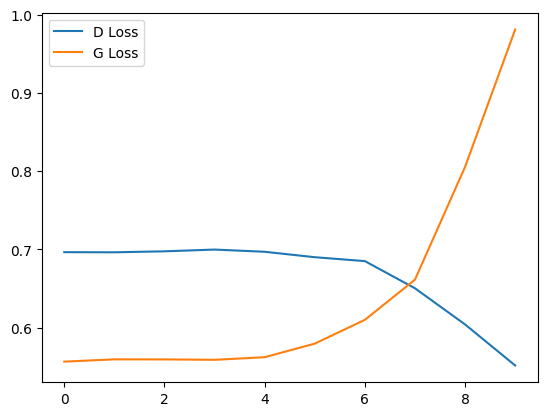

/var/folders/g6/f8dm2s3j49v8_h2b1tdytvmr0000gn/T/ipykernel_18619/2779135855.py:34: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x_reconstructed = istft(Zxx, window=window, nperseg=nperseg, noverlap=noverlap,


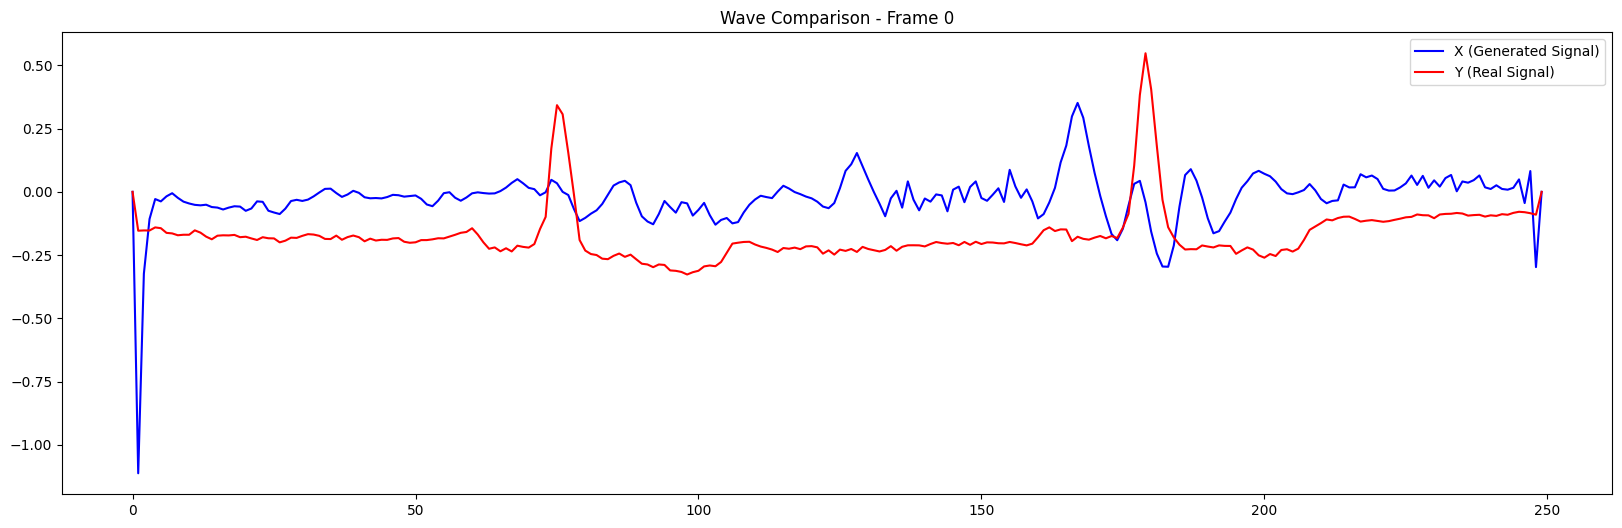

Frame 0:
Mean Squared Error (MSE): 0.0442
Fréchet Distance: 0.7856


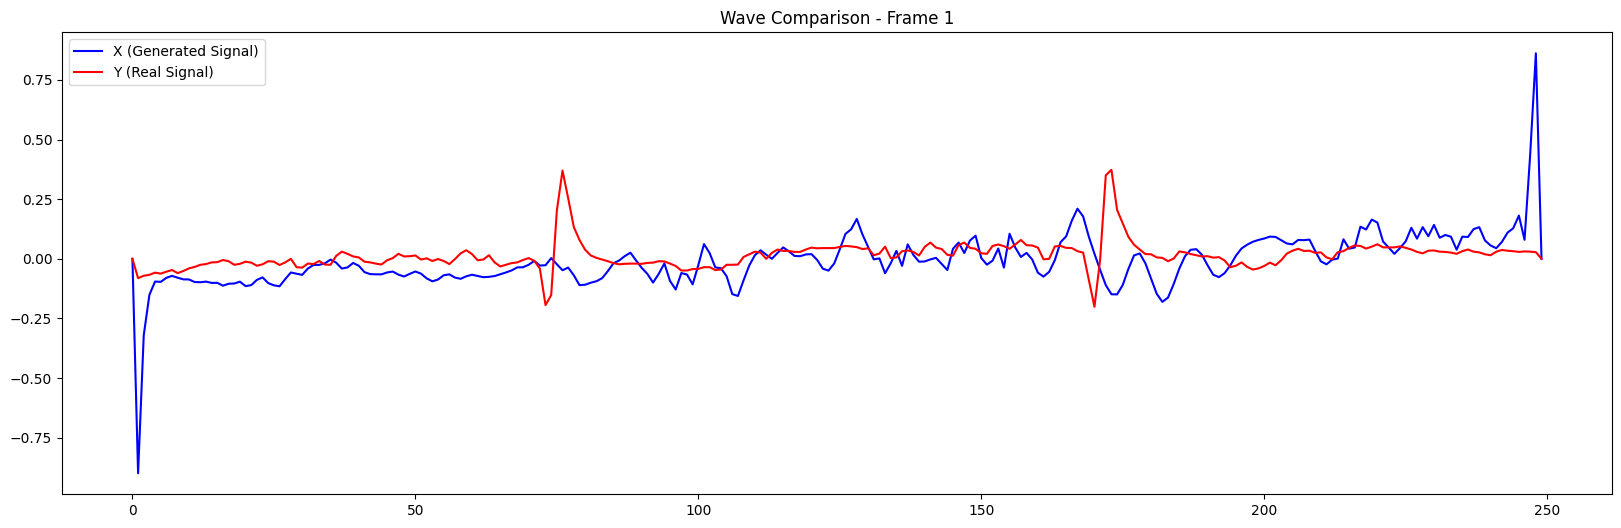

Frame 1:
Mean Squared Error (MSE): 0.0154
Fréchet Distance: 0.6979
Epoch 10/1000, Discrimiator Loss: 0.07962305843830109, Generator Loss: 2.5614712238311768
Epoch 11/1000, Discrimiator Loss: 0.2070278376340866, Generator Loss: 3.6017580032348633
Epoch 12/1000, Discrimiator Loss: 0.013639360666275024, Generator Loss: 3.6587276458740234
Epoch 13/1000, Discrimiator Loss: 0.0002264811482746154, Generator Loss: 6.896686553955078
Epoch 14/1000, Discrimiator Loss: 9.065446647582576e-05, Generator Loss: 7.14955997467041
Epoch 15/1000, Discrimiator Loss: 6.449710781453177e-05, Generator Loss: 7.87113618850708
Epoch 16/1000, Discrimiator Loss: 1.5812247511348687e-05, Generator Loss: 8.735042572021484
Epoch 17/1000, Discrimiator Loss: 1.8281227312400006e-05, Generator Loss: 9.105597496032715
Epoch 18/1000, Discrimiator Loss: 4.7199609980452806e-06, Generator Loss: 9.704649925231934
Epoch 19/1000, Discrimiator Loss: 4.765595804201439e-06, Generator Loss: 9.574722290039062


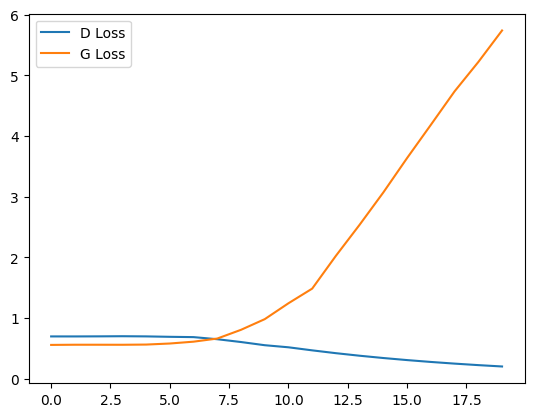

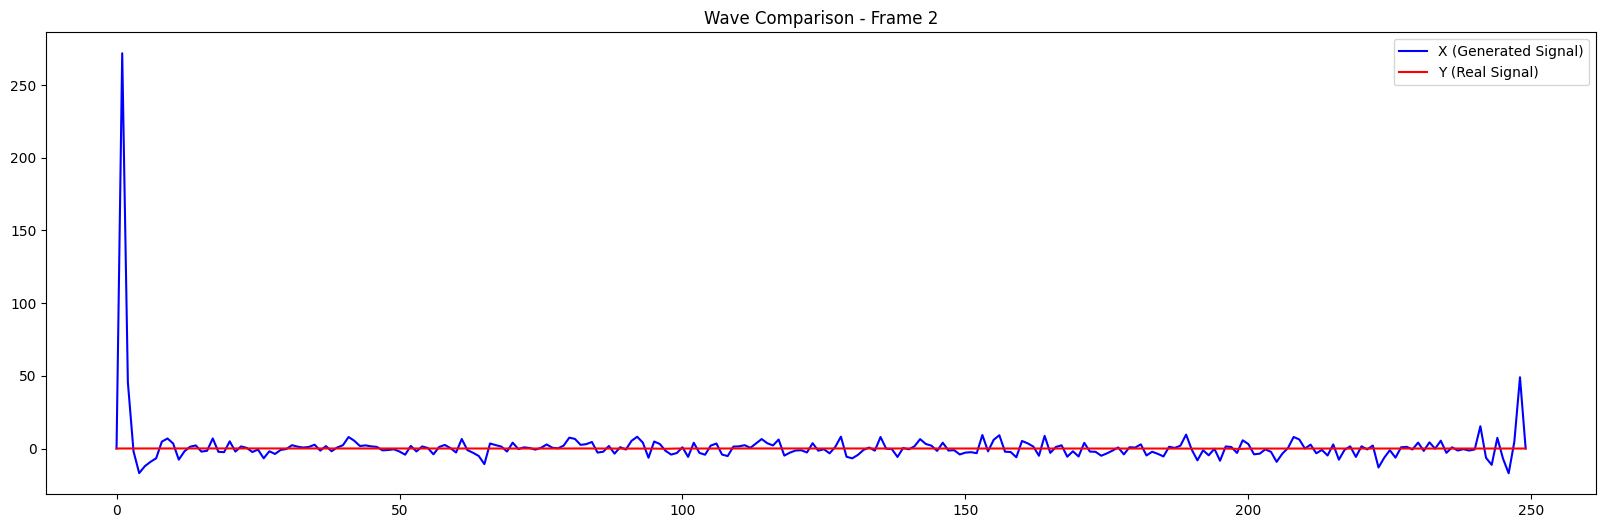

Frame 2:
Mean Squared Error (MSE): 333.0433
Fréchet Distance: 271.8056


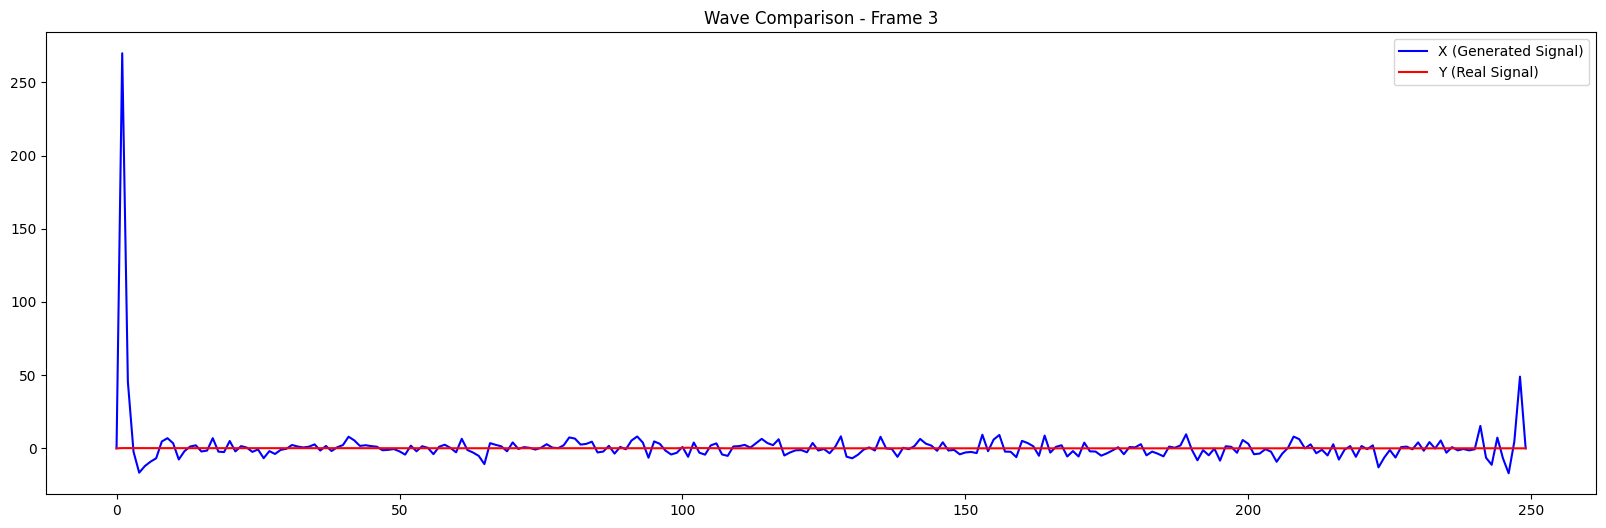

Frame 3:
Mean Squared Error (MSE): 328.3757
Fréchet Distance: 269.4181
Epoch 20/1000, Discrimiator Loss: 8.335462553077377e-06, Generator Loss: 10.415999412536621
Epoch 21/1000, Discrimiator Loss: 1.7657898752077017e-06, Generator Loss: 10.735909461975098
Epoch 22/1000, Discrimiator Loss: 4.526229133716697e-07, Generator Loss: 11.605103492736816
Epoch 23/1000, Discrimiator Loss: 2.626330228849838e-07, Generator Loss: 12.355238914489746
Epoch 24/1000, Discrimiator Loss: 2.821908253736183e-07, Generator Loss: 12.400166511535645
Epoch 25/1000, Discrimiator Loss: 1.396984004031765e-07, Generator Loss: 12.973423957824707
Epoch 26/1000, Discrimiator Loss: 8.009374141693115e-08, Generator Loss: 13.274635314941406
Epoch 27/1000, Discrimiator Loss: 7.543712854385376e-08, Generator Loss: 13.652302742004395
Epoch 28/1000, Discrimiator Loss: 5.4016709327697754e-08, Generator Loss: 13.814600944519043
Epoch 29/1000, Discrimiator Loss: 2.3283064365386963e-08, Generator Loss: 14.108662605285645


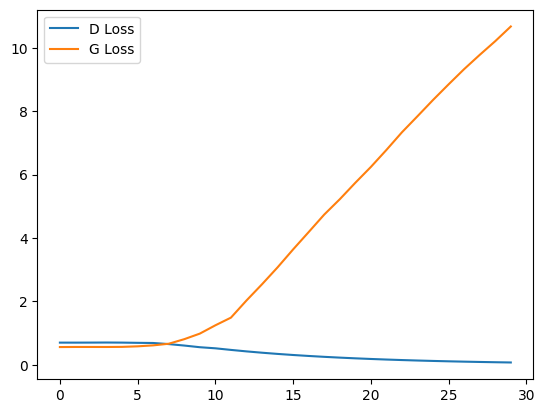

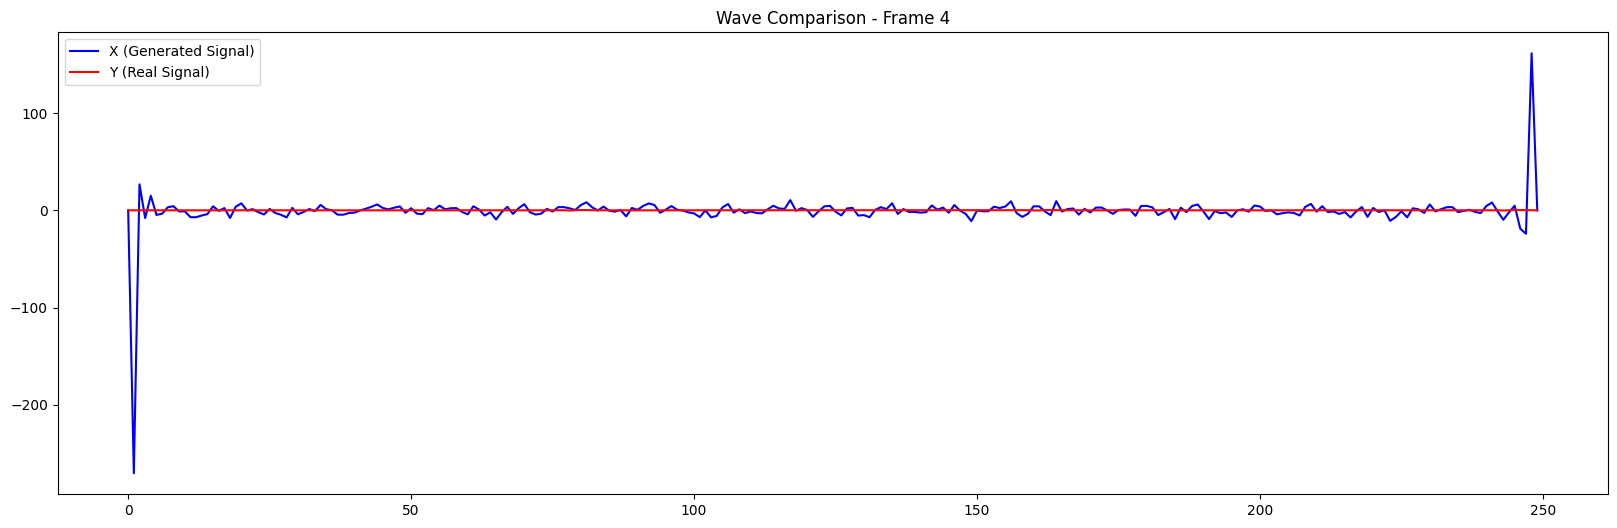

Frame 4:
Mean Squared Error (MSE): 420.0473
Fréchet Distance: 270.1265


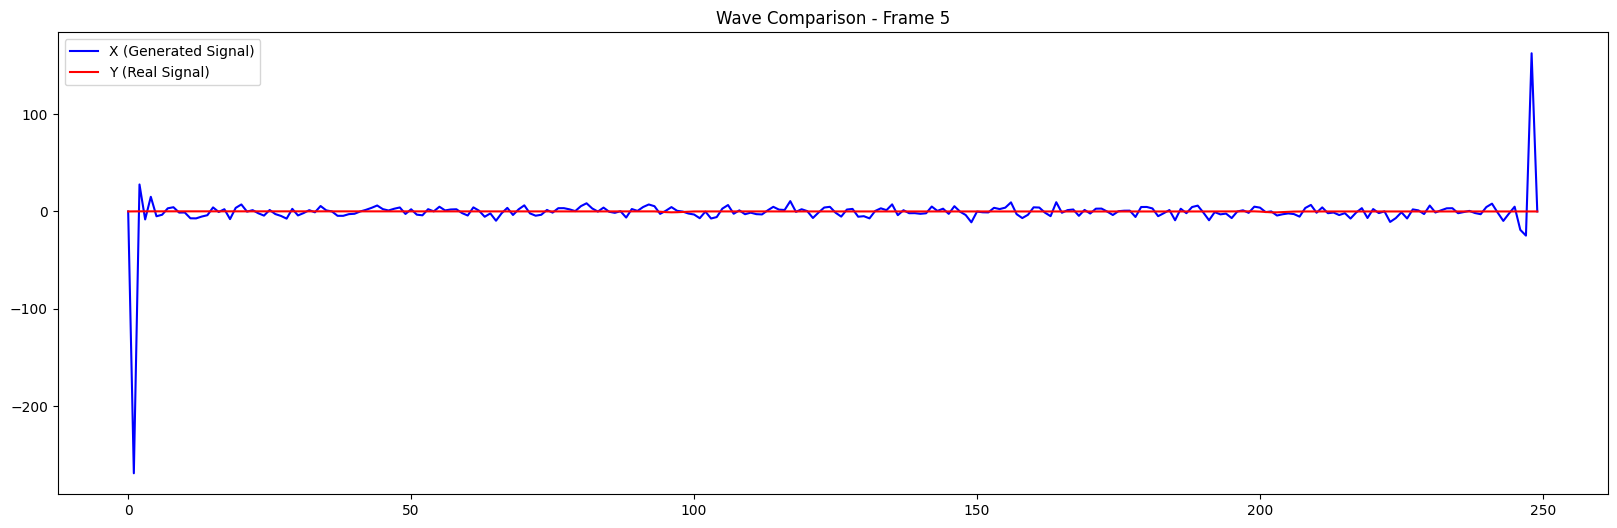

Frame 5:
Mean Squared Error (MSE): 418.4618
Fréchet Distance: 267.8824
Epoch 30/1000, Discrimiator Loss: 5.587935447692871e-09, Generator Loss: 14.838454246520996
Epoch 31/1000, Discrimiator Loss: 5.587935447692871e-09, Generator Loss: 15.473978996276855
Epoch 32/1000, Discrimiator Loss: 7.450582373280668e-09, Generator Loss: 15.481050491333008
Epoch 33/1000, Discrimiator Loss: 3.725290298461914e-09, Generator Loss: 16.060068130493164
Epoch 34/1000, Discrimiator Loss: 0.0, Generator Loss: 16.58332061767578
Epoch 35/1000, Discrimiator Loss: 3.725290298461914e-09, Generator Loss: 16.820035934448242
Epoch 36/1000, Discrimiator Loss: 0.0, Generator Loss: 16.943546295166016
Epoch 37/1000, Discrimiator Loss: 0.0, Generator Loss: 17.18103790283203
Epoch 38/1000, Discrimiator Loss: 0.0, Generator Loss: 17.45718002319336
Epoch 39/1000, Discrimiator Loss: 0.0, Generator Loss: 17.900726318359375


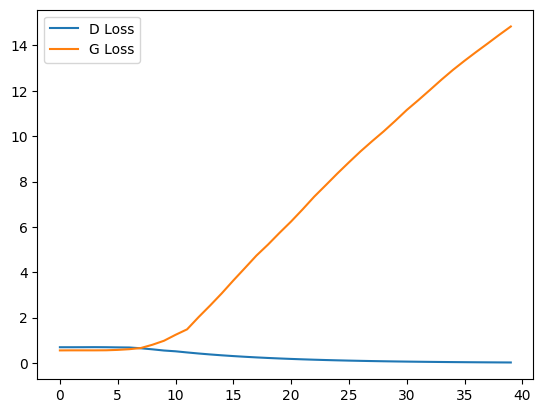

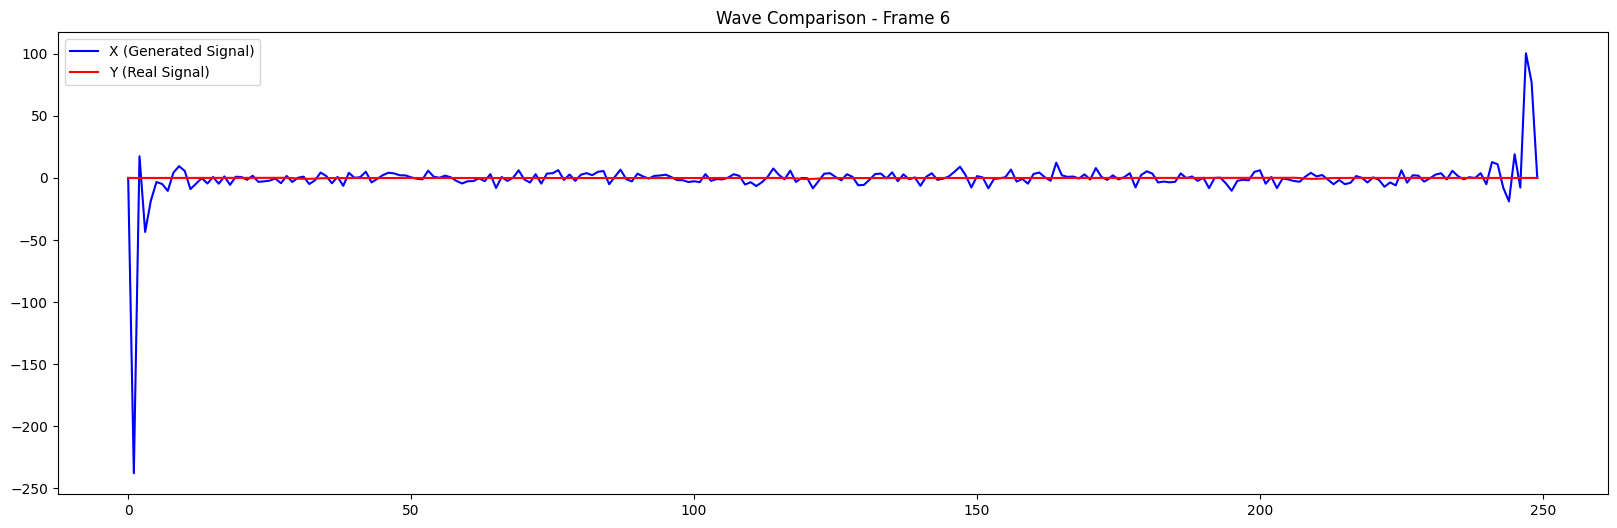

Frame 6:
Mean Squared Error (MSE): 318.6732
Fréchet Distance: 237.1758


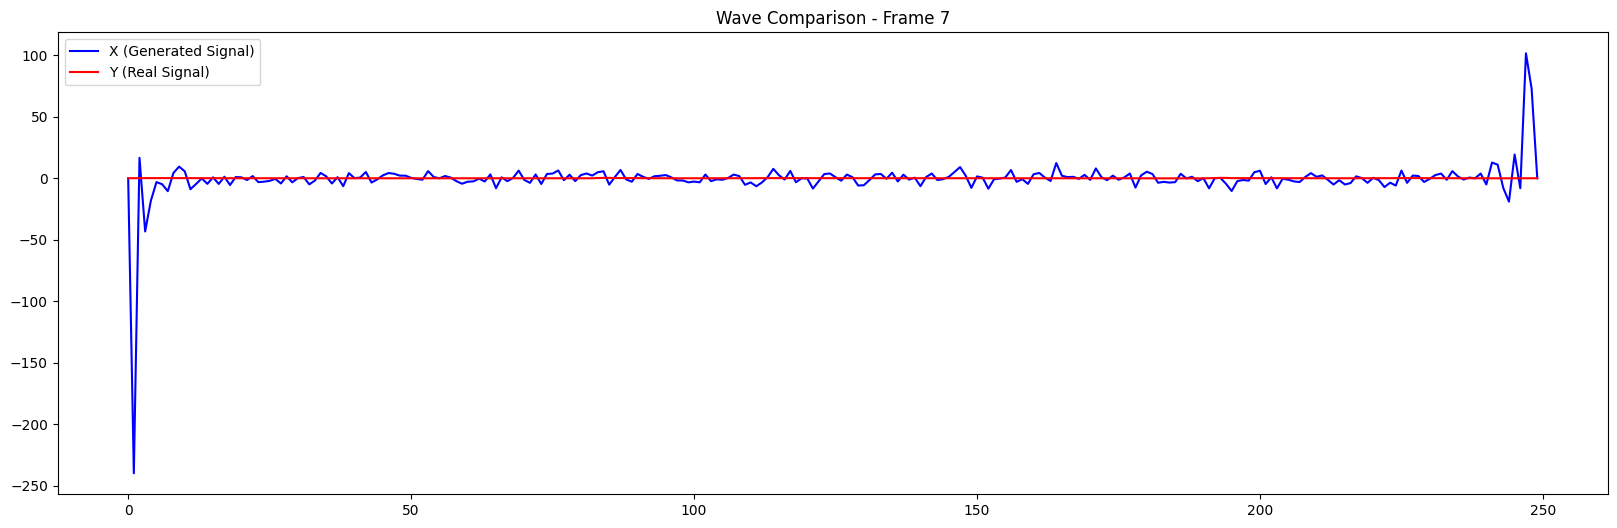

Frame 7:
Mean Squared Error (MSE): 321.1859
Fréchet Distance: 239.8208
Epoch 40/1000, Discrimiator Loss: 0.0, Generator Loss: 18.14775848388672
Epoch 41/1000, Discrimiator Loss: 0.0, Generator Loss: 17.991943359375
Epoch 42/1000, Discrimiator Loss: 0.0, Generator Loss: 18.234512329101562
Epoch 43/1000, Discrimiator Loss: 0.0, Generator Loss: 18.6599178314209
Epoch 44/1000, Discrimiator Loss: 0.0, Generator Loss: 19.035276412963867
Epoch 45/1000, Discrimiator Loss: 0.0, Generator Loss: 18.545841217041016
Epoch 46/1000, Discrimiator Loss: 0.0, Generator Loss: 18.475339889526367
Epoch 47/1000, Discrimiator Loss: 0.0, Generator Loss: 18.895008087158203
Epoch 48/1000, Discrimiator Loss: 0.0, Generator Loss: 19.089214324951172
Epoch 49/1000, Discrimiator Loss: 0.0, Generator Loss: 19.16175651550293


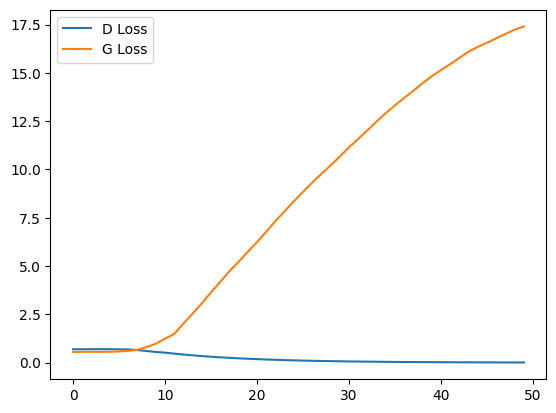

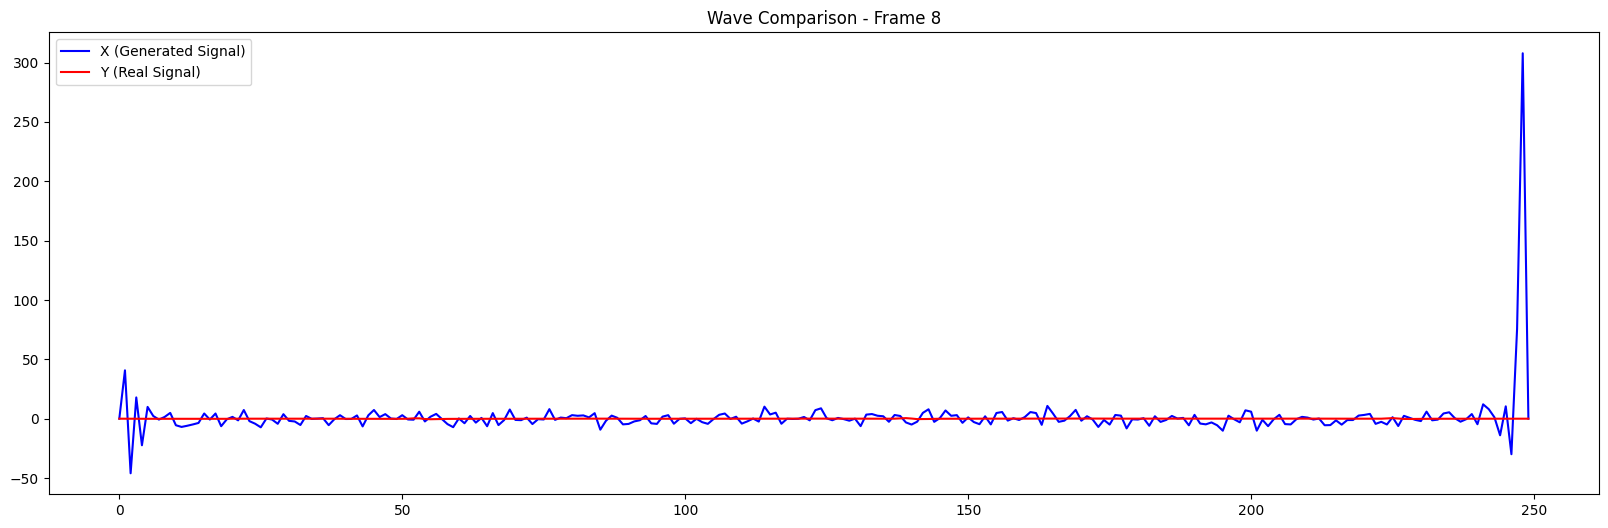

Frame 8:
Mean Squared Error (MSE): 440.3975
Fréchet Distance: 307.3458


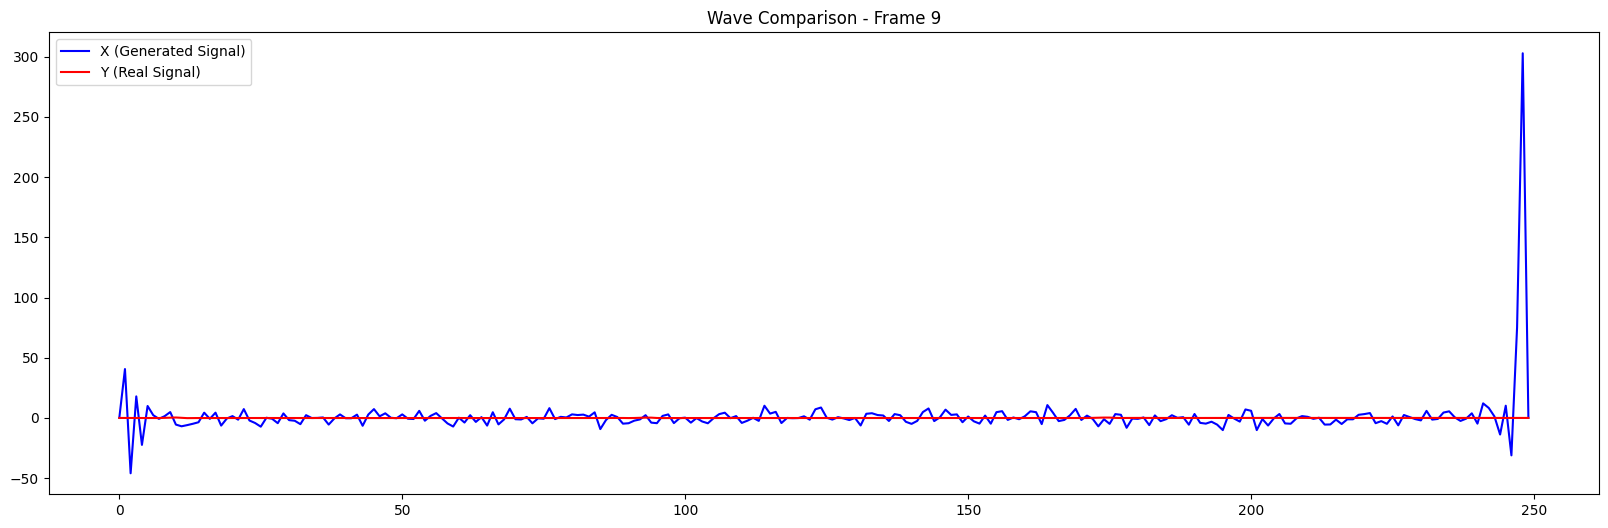

Frame 9:
Mean Squared Error (MSE): 427.9777
Fréchet Distance: 302.4573
Epoch 50/1000, Discrimiator Loss: 0.0, Generator Loss: 18.89817237854004
Epoch 51/1000, Discrimiator Loss: 0.0, Generator Loss: 18.367008209228516
Epoch 52/1000, Discrimiator Loss: 0.0, Generator Loss: 18.164276123046875
Epoch 53/1000, Discrimiator Loss: 0.0, Generator Loss: 18.53396224975586
Epoch 54/1000, Discrimiator Loss: 0.0, Generator Loss: 17.624448776245117
Epoch 55/1000, Discrimiator Loss: 0.0, Generator Loss: 18.154224395751953
Epoch 56/1000, Discrimiator Loss: 0.0, Generator Loss: 18.138648986816406
Epoch 57/1000, Discrimiator Loss: 0.0, Generator Loss: 18.557235717773438
Epoch 58/1000, Discrimiator Loss: 0.0, Generator Loss: 18.35458755493164
Epoch 59/1000, Discrimiator Loss: 0.0, Generator Loss: 19.164196014404297


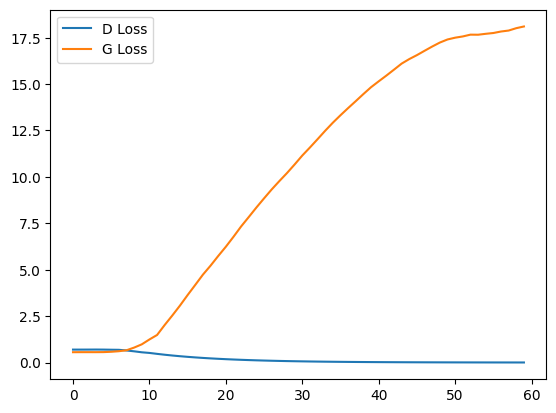

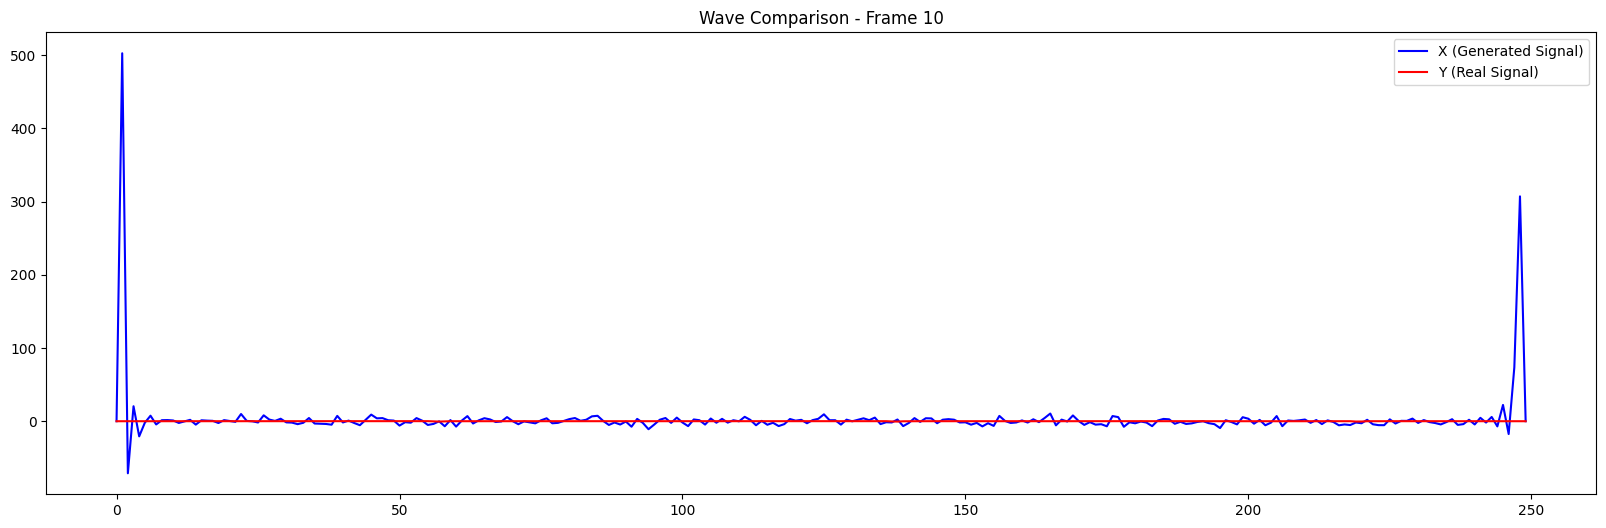

Frame 10:
Mean Squared Error (MSE): 1450.5837
Fréchet Distance: 502.4397


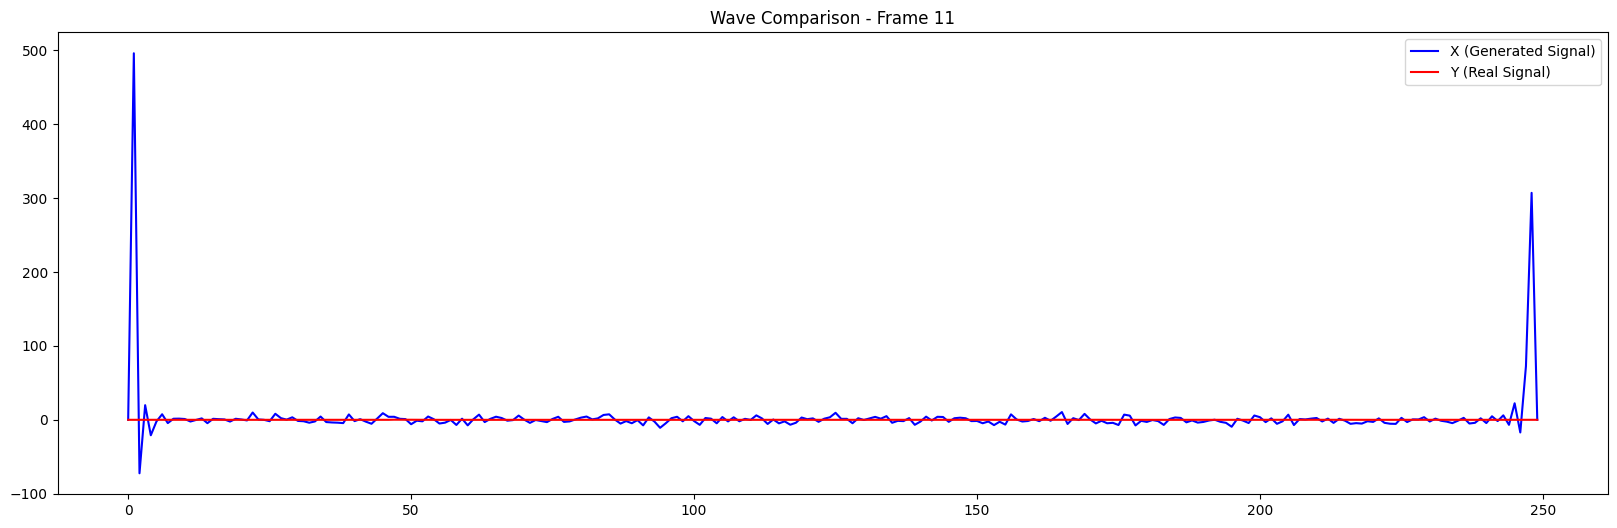

Frame 11:
Mean Squared Error (MSE): 1423.6694
Fréchet Distance: 495.6868
Epoch 60/1000, Discrimiator Loss: 0.0, Generator Loss: 18.92342185974121
Epoch 61/1000, Discrimiator Loss: 0.0, Generator Loss: 18.798229217529297
Epoch 62/1000, Discrimiator Loss: 0.0, Generator Loss: 18.709266662597656
Epoch 63/1000, Discrimiator Loss: 0.0, Generator Loss: 18.958040237426758
Epoch 64/1000, Discrimiator Loss: 0.0, Generator Loss: 19.161483764648438
Epoch 65/1000, Discrimiator Loss: 0.0, Generator Loss: 19.395038604736328
Epoch 66/1000, Discrimiator Loss: 0.0, Generator Loss: 18.83144760131836
Epoch 67/1000, Discrimiator Loss: 0.0, Generator Loss: 19.229461669921875
Epoch 68/1000, Discrimiator Loss: 0.0, Generator Loss: 18.845149993896484
Epoch 69/1000, Discrimiator Loss: 0.0, Generator Loss: 18.12112045288086


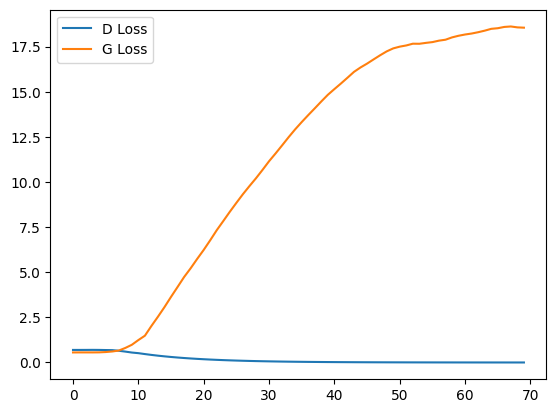

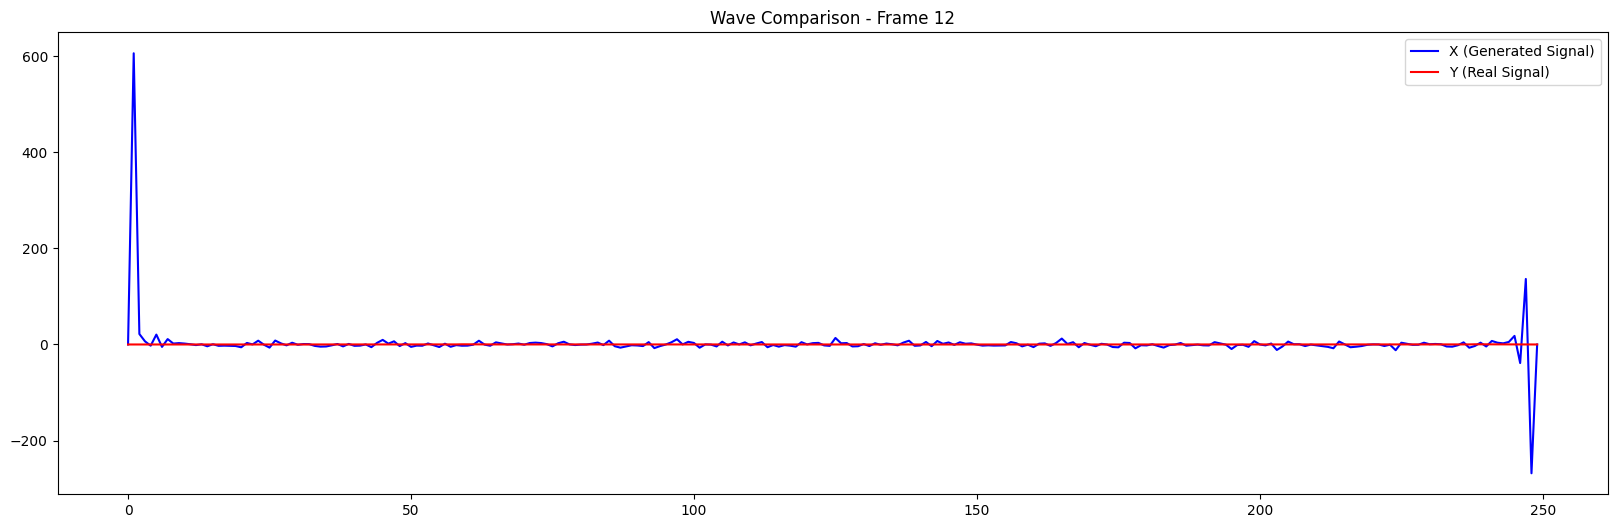

Frame 12:
Mean Squared Error (MSE): 1860.4772
Fréchet Distance: 606.1356


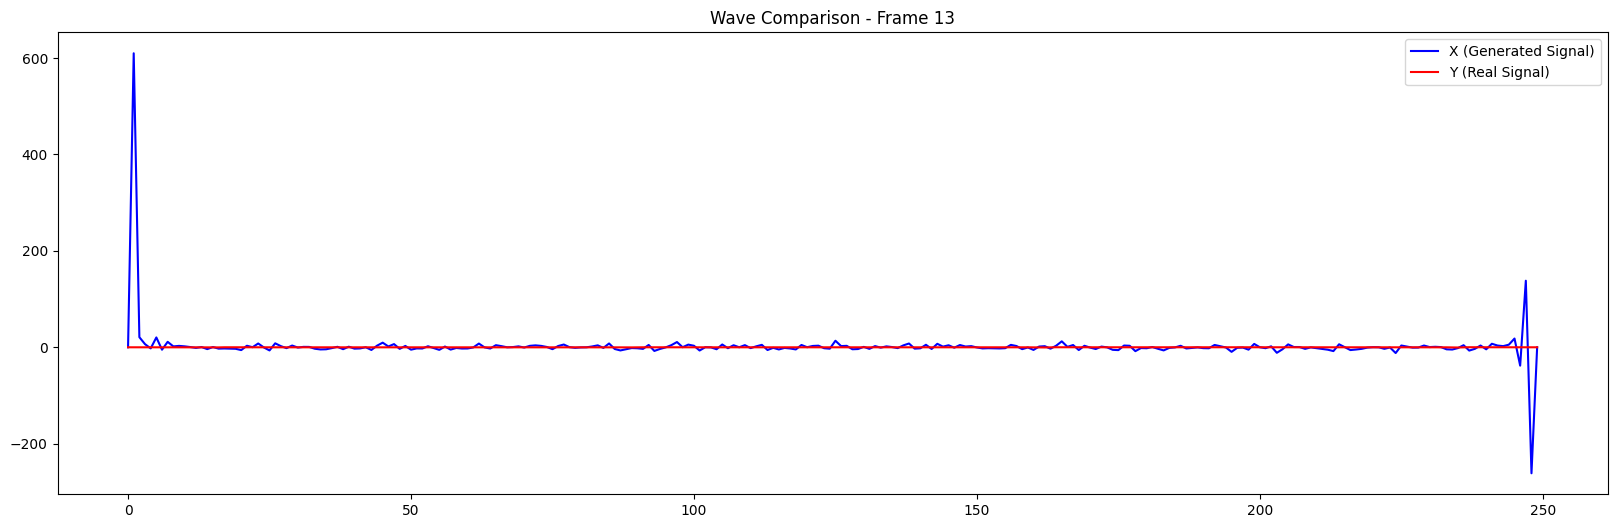

Frame 13:
Mean Squared Error (MSE): 1863.2767
Fréchet Distance: 609.7114
Epoch 70/1000, Discrimiator Loss: 0.0, Generator Loss: 18.39807891845703
Epoch 71/1000, Discrimiator Loss: 0.0, Generator Loss: 18.800447463989258
Epoch 72/1000, Discrimiator Loss: 0.0, Generator Loss: 18.804906845092773
Epoch 73/1000, Discrimiator Loss: 0.0, Generator Loss: 19.018428802490234
Epoch 74/1000, Discrimiator Loss: 0.0, Generator Loss: 19.2408447265625
Epoch 75/1000, Discrimiator Loss: 0.0, Generator Loss: 18.257320404052734
Epoch 76/1000, Discrimiator Loss: 0.0, Generator Loss: 18.815805435180664
Epoch 77/1000, Discrimiator Loss: 0.0, Generator Loss: 19.125755310058594
Epoch 78/1000, Discrimiator Loss: 0.0, Generator Loss: 19.163522720336914
Epoch 79/1000, Discrimiator Loss: 0.0, Generator Loss: 19.152864456176758


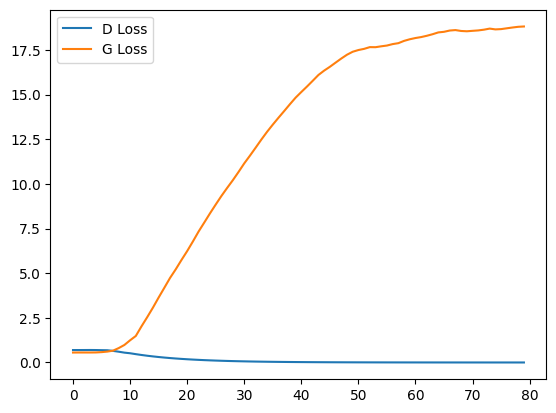

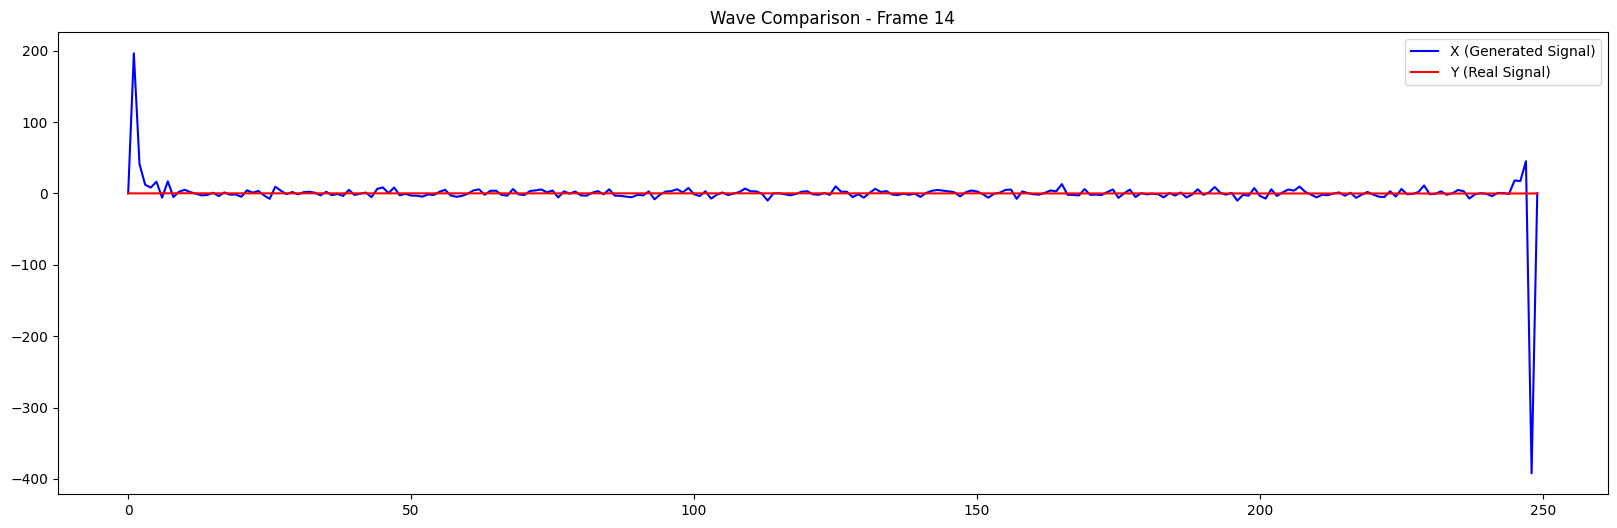

Frame 14:
Mean Squared Error (MSE): 803.8355
Fréchet Distance: 391.8876


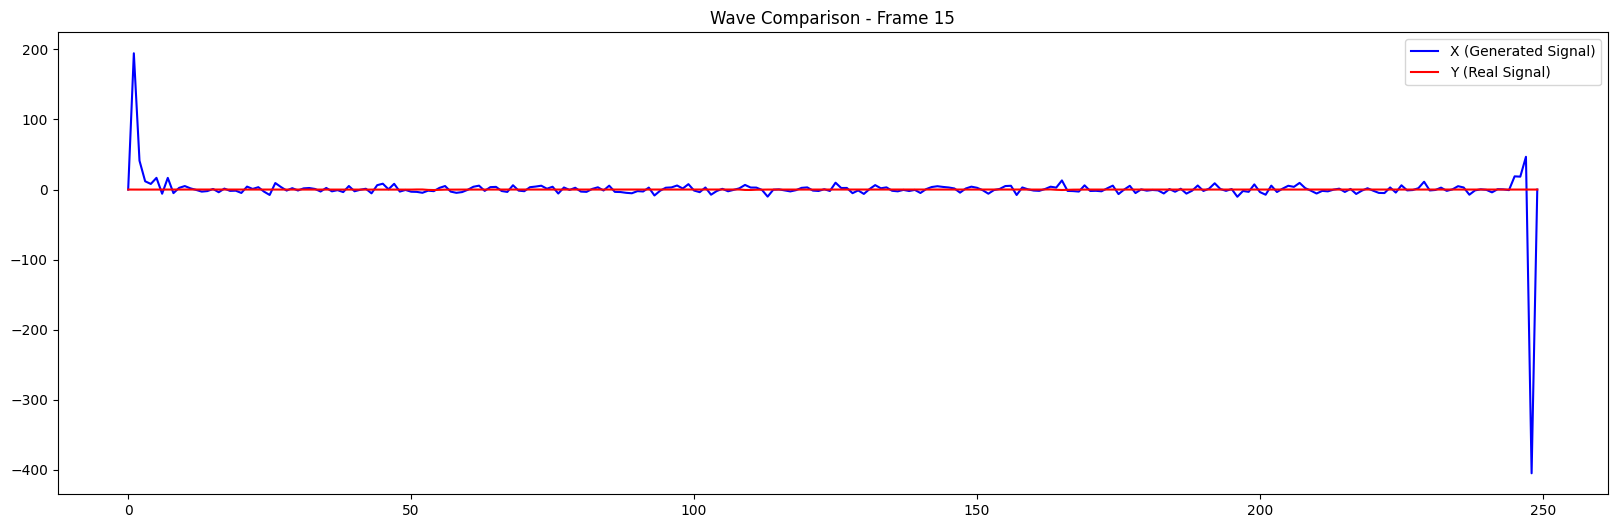

Frame 15:
Mean Squared Error (MSE): 843.5015
Fréchet Distance: 404.2292
Epoch 80/1000, Discrimiator Loss: 0.0, Generator Loss: 18.984020233154297
Epoch 81/1000, Discrimiator Loss: 0.0, Generator Loss: 19.44148063659668
Epoch 82/1000, Discrimiator Loss: 0.0, Generator Loss: 19.599002838134766
Epoch 83/1000, Discrimiator Loss: 0.0, Generator Loss: 19.30647850036621
Epoch 84/1000, Discrimiator Loss: 0.0, Generator Loss: 18.654722213745117
Epoch 85/1000, Discrimiator Loss: 0.0, Generator Loss: 18.651460647583008
Epoch 86/1000, Discrimiator Loss: 0.0, Generator Loss: 19.117002487182617
Epoch 87/1000, Discrimiator Loss: 0.0, Generator Loss: 18.55486488342285
Epoch 88/1000, Discrimiator Loss: 0.0, Generator Loss: 18.99314308166504
Epoch 89/1000, Discrimiator Loss: 0.0, Generator Loss: 19.418071746826172


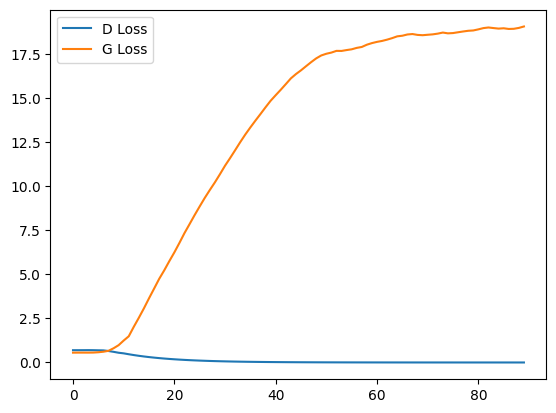

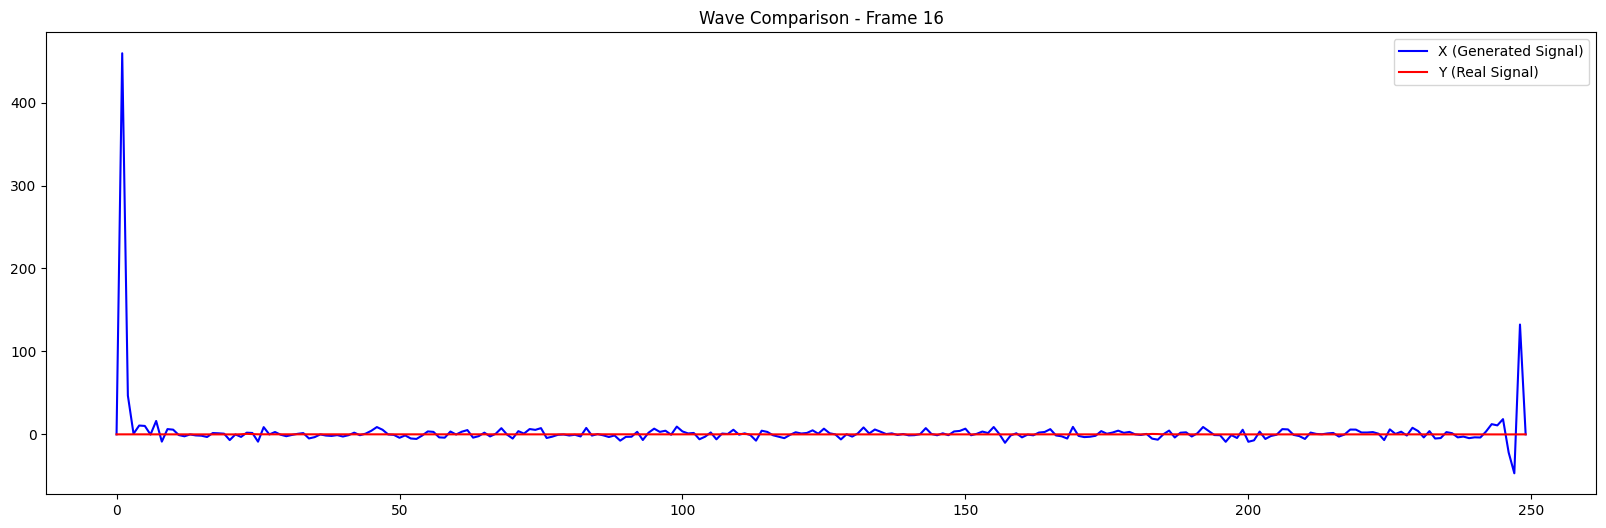

Frame 16:
Mean Squared Error (MSE): 952.8562
Fréchet Distance: 458.9149


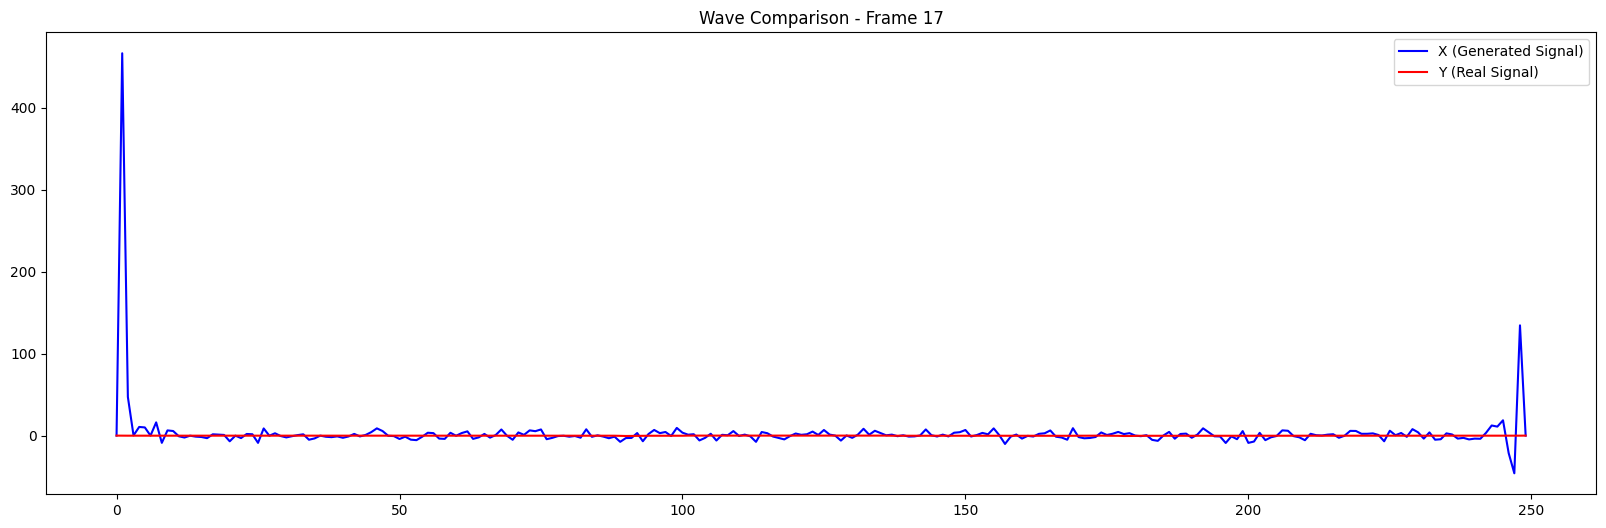

Frame 17:
Mean Squared Error (MSE): 982.2361
Fréchet Distance: 466.6333
Epoch 90/1000, Discrimiator Loss: 0.0, Generator Loss: 19.776771545410156
Epoch 91/1000, Discrimiator Loss: 0.0, Generator Loss: 19.82424545288086
Epoch 92/1000, Discrimiator Loss: 0.0, Generator Loss: 19.222288131713867
Epoch 93/1000, Discrimiator Loss: 0.0, Generator Loss: 19.723045349121094
Epoch 94/1000, Discrimiator Loss: 0.0, Generator Loss: 20.00384521484375
Epoch 95/1000, Discrimiator Loss: 0.0, Generator Loss: 19.802757263183594
Epoch 96/1000, Discrimiator Loss: 0.0, Generator Loss: 19.6722469329834
Epoch 97/1000, Discrimiator Loss: 0.0, Generator Loss: 19.8317928314209
Epoch 98/1000, Discrimiator Loss: 0.0, Generator Loss: 19.864688873291016
Epoch 99/1000, Discrimiator Loss: 0.0, Generator Loss: 19.72499656677246


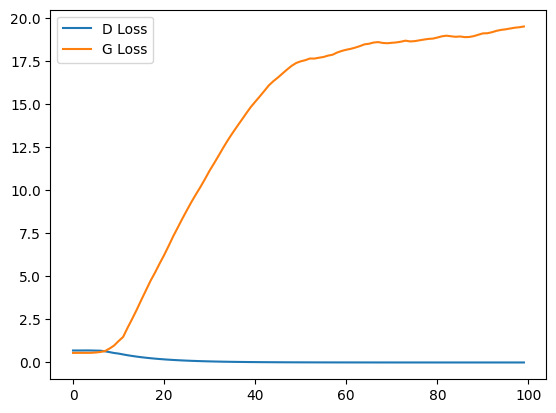

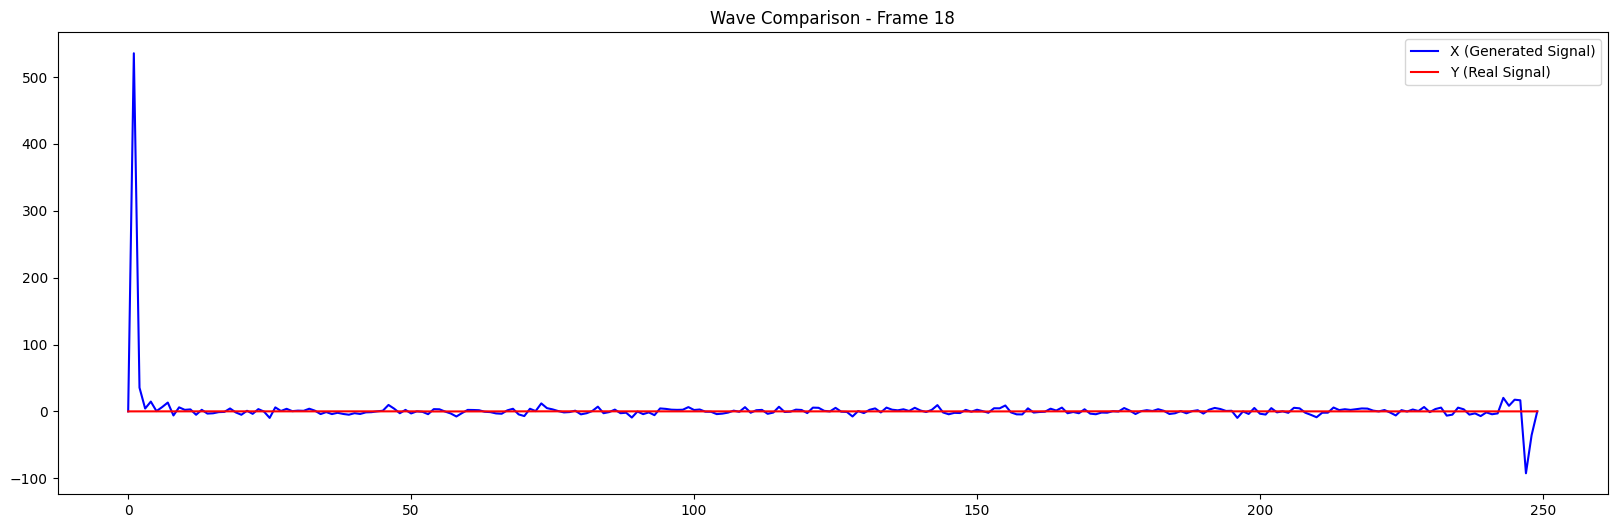

Frame 18:
Mean Squared Error (MSE): 1210.6500
Fréchet Distance: 535.4754


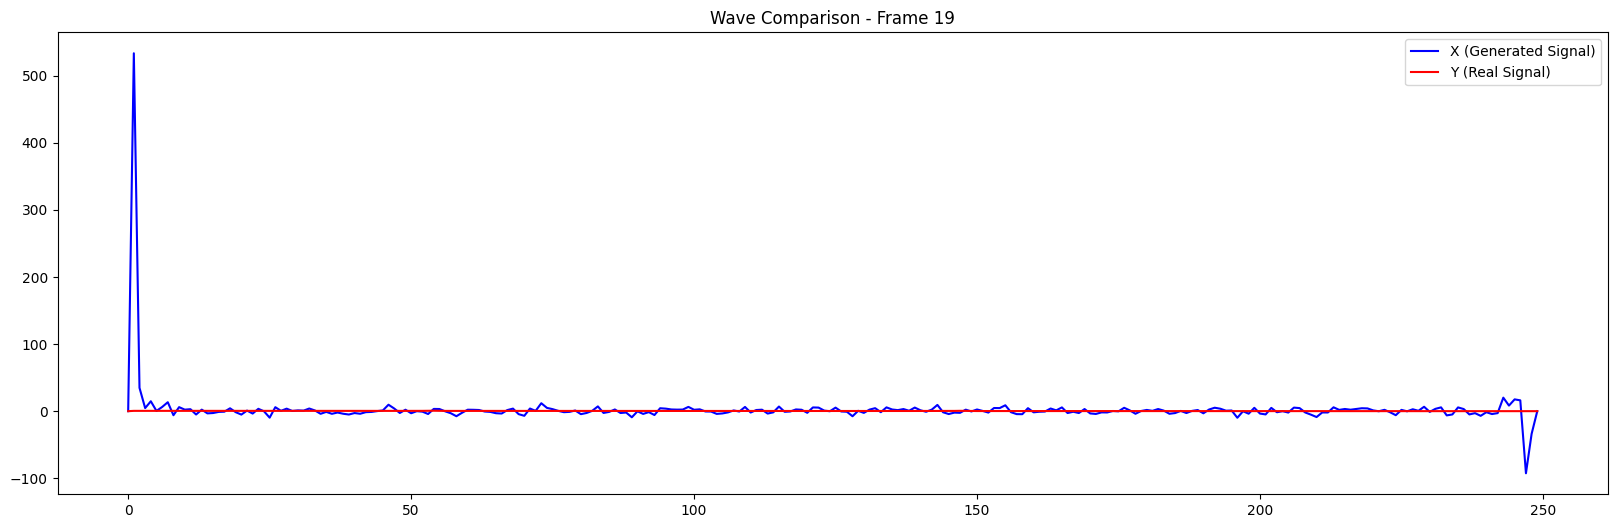

Frame 19:
Mean Squared Error (MSE): 1199.0848
Fréchet Distance: 532.8857
Epoch 100/1000, Discrimiator Loss: 0.0, Generator Loss: 19.918794631958008
Epoch 101/1000, Discrimiator Loss: 0.0, Generator Loss: 20.05144500732422
Epoch 102/1000, Discrimiator Loss: 0.0, Generator Loss: 20.178071975708008
Epoch 103/1000, Discrimiator Loss: 0.0, Generator Loss: 19.862586975097656
Epoch 104/1000, Discrimiator Loss: 0.0, Generator Loss: 19.737276077270508
Epoch 105/1000, Discrimiator Loss: 0.0, Generator Loss: 19.0617618560791
Epoch 106/1000, Discrimiator Loss: 0.0, Generator Loss: 19.255332946777344
Epoch 107/1000, Discrimiator Loss: 0.0, Generator Loss: 19.41472816467285
Epoch 108/1000, Discrimiator Loss: 0.0, Generator Loss: 19.22509002685547
Epoch 109/1000, Discrimiator Loss: 0.0, Generator Loss: 19.61927032470703


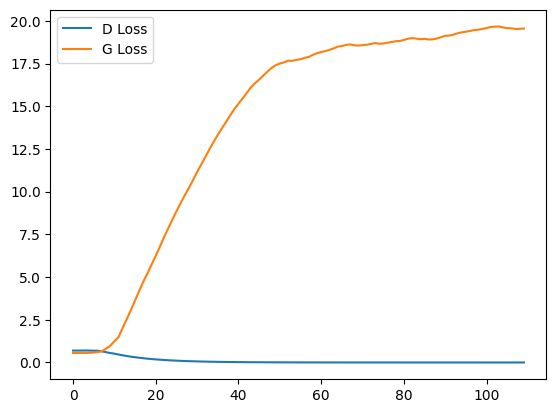

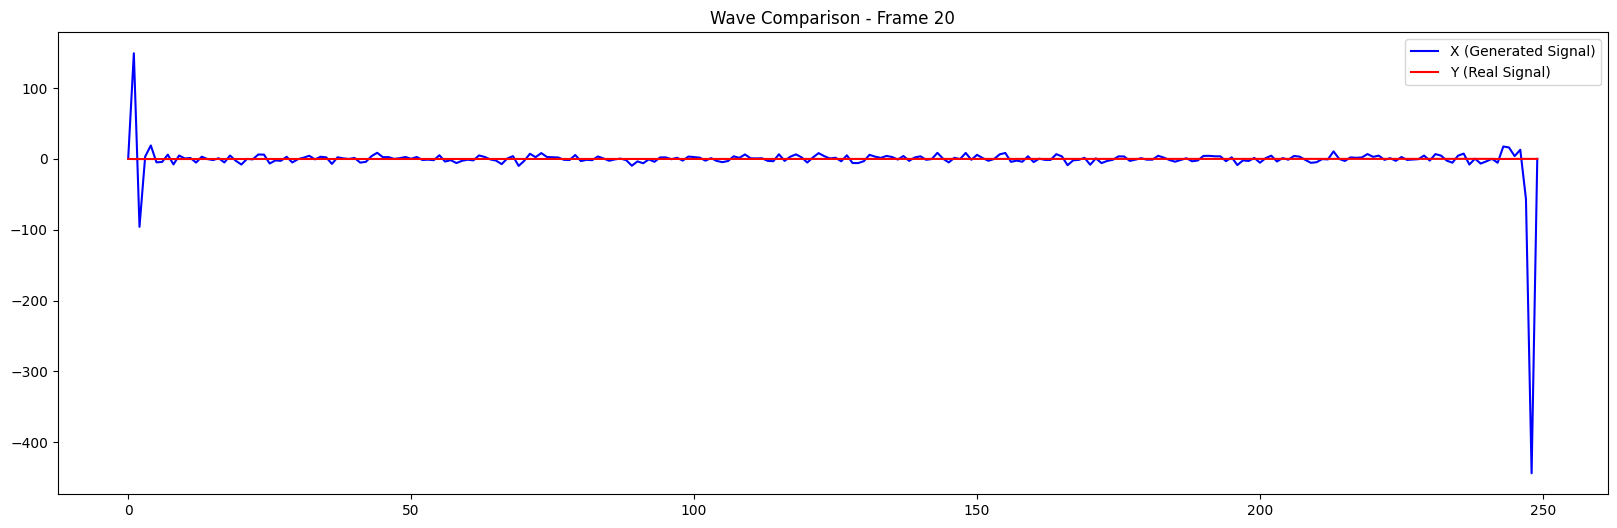

Frame 20:
Mean Squared Error (MSE): 945.4379
Fréchet Distance: 443.4672


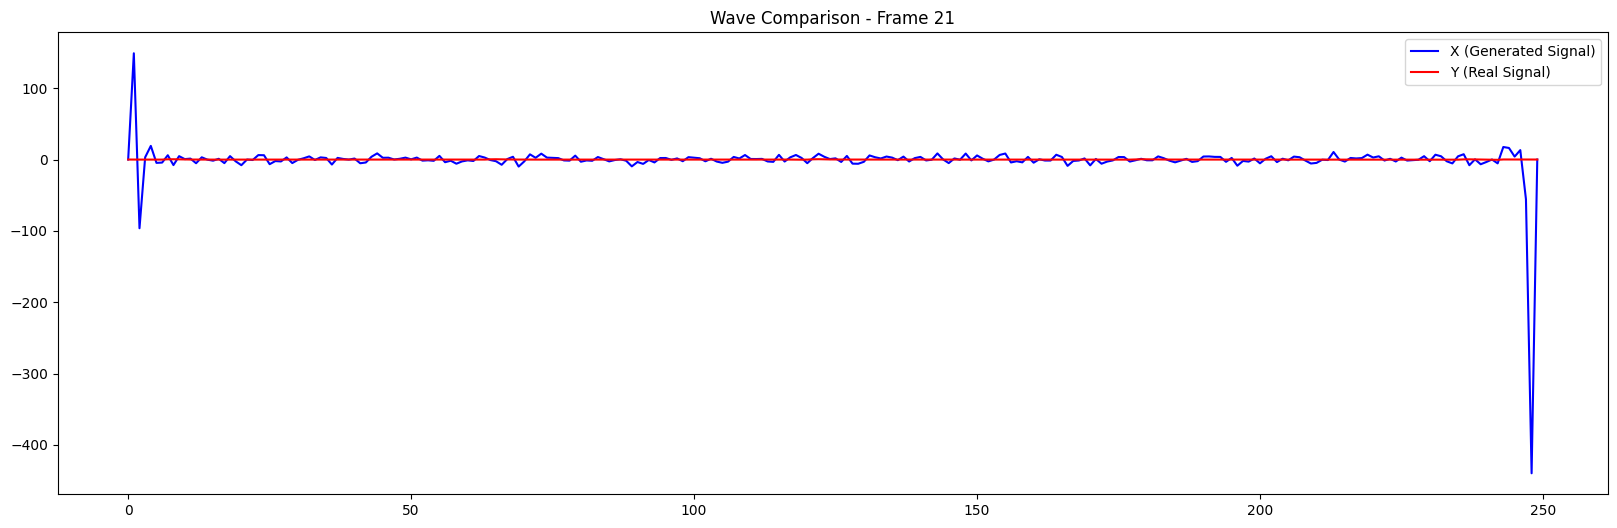

Frame 21:
Mean Squared Error (MSE): 931.9553
Fréchet Distance: 439.4946
Epoch 110/1000, Discrimiator Loss: 0.0, Generator Loss: 19.677383422851562
Epoch 111/1000, Discrimiator Loss: 0.0, Generator Loss: 19.715648651123047
Epoch 112/1000, Discrimiator Loss: 0.0, Generator Loss: 19.599170684814453
Epoch 113/1000, Discrimiator Loss: 0.0, Generator Loss: 19.361318588256836
Epoch 114/1000, Discrimiator Loss: 0.0, Generator Loss: 19.29043960571289
Epoch 115/1000, Discrimiator Loss: 0.0, Generator Loss: 19.4803466796875
Epoch 116/1000, Discrimiator Loss: 0.0, Generator Loss: 19.2060489654541
Epoch 117/1000, Discrimiator Loss: 0.0, Generator Loss: 19.048107147216797
Epoch 118/1000, Discrimiator Loss: 0.0, Generator Loss: 19.344083786010742
Epoch 119/1000, Discrimiator Loss: 0.0, Generator Loss: 19.484596252441406


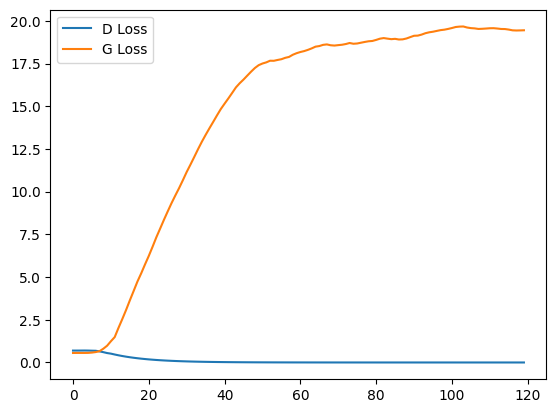

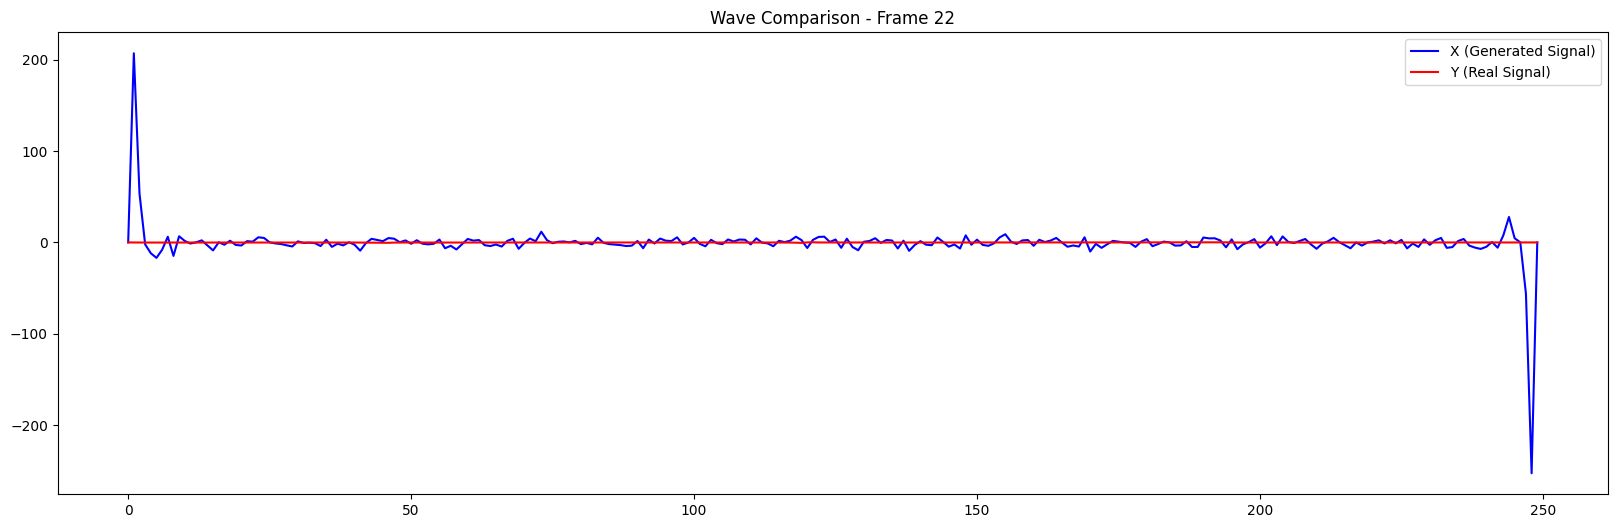

Frame 22:
Mean Squared Error (MSE): 470.5917
Fréchet Distance: 252.1300


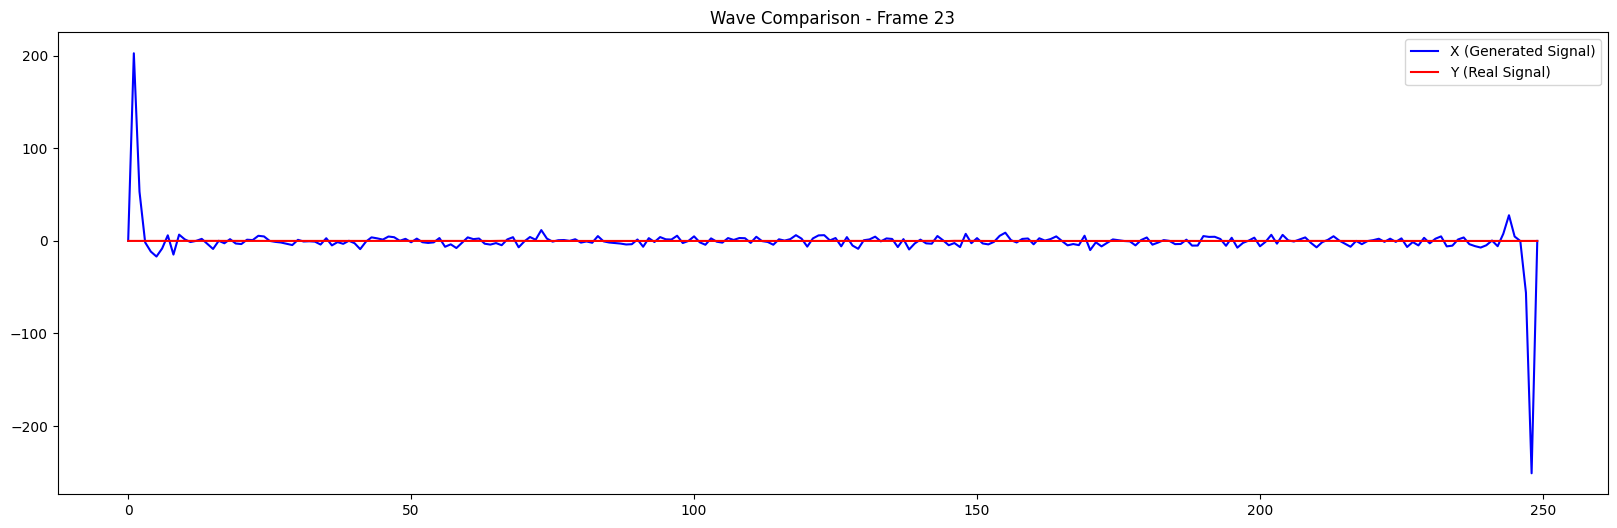

Frame 23:
Mean Squared Error (MSE): 459.8042
Fréchet Distance: 250.9013
Epoch 120/1000, Discrimiator Loss: 0.0, Generator Loss: 19.514680862426758
Epoch 121/1000, Discrimiator Loss: 0.0, Generator Loss: 19.252452850341797
Epoch 122/1000, Discrimiator Loss: 0.0, Generator Loss: 19.331233978271484
Epoch 123/1000, Discrimiator Loss: 0.0, Generator Loss: 19.62924575805664
Epoch 124/1000, Discrimiator Loss: 0.0, Generator Loss: 19.4077205657959
Epoch 125/1000, Discrimiator Loss: 0.0, Generator Loss: 19.177352905273438
Epoch 126/1000, Discrimiator Loss: 0.0, Generator Loss: 19.538644790649414
Epoch 127/1000, Discrimiator Loss: 0.0, Generator Loss: 19.532272338867188
Epoch 128/1000, Discrimiator Loss: 0.0, Generator Loss: 19.203458786010742
Epoch 129/1000, Discrimiator Loss: 0.0, Generator Loss: 19.707088470458984


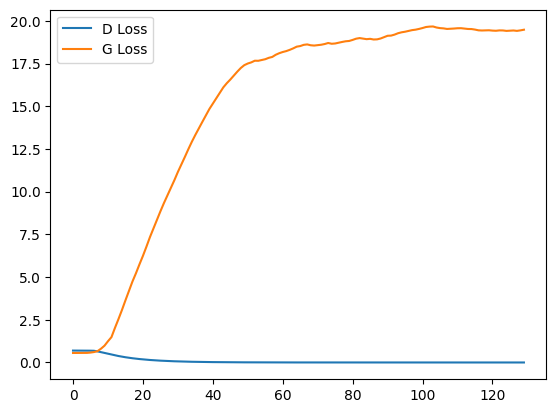

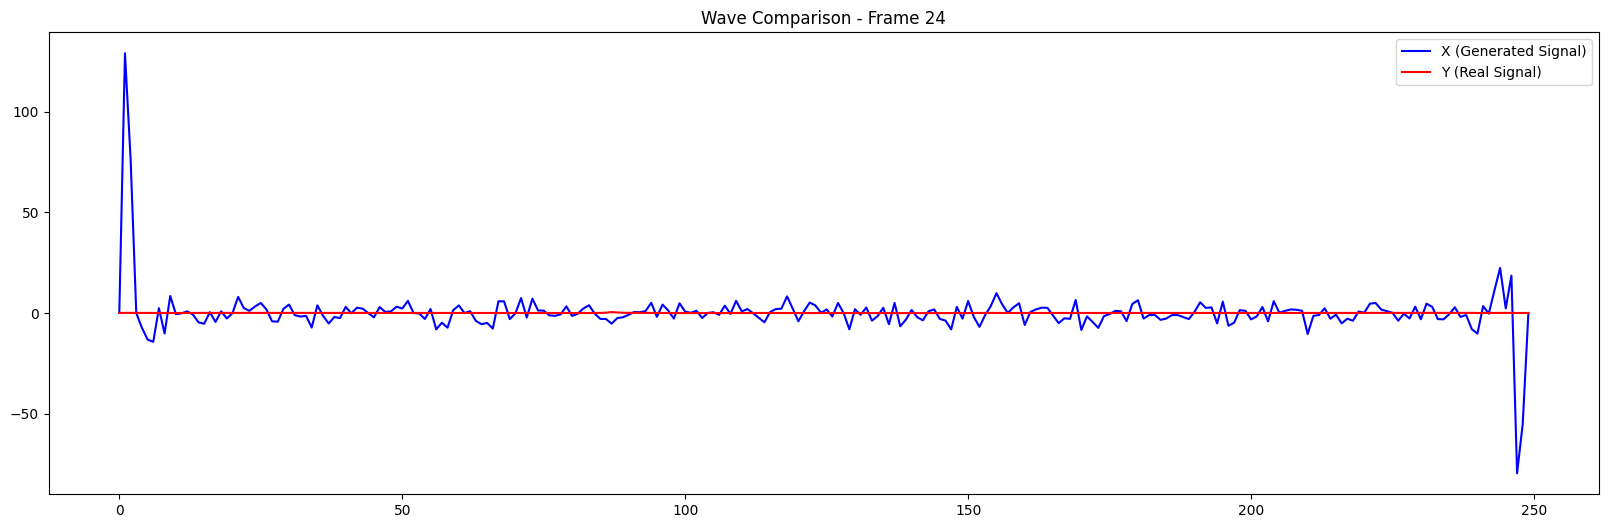

Frame 24:
Mean Squared Error (MSE): 146.0714
Fréchet Distance: 128.4868


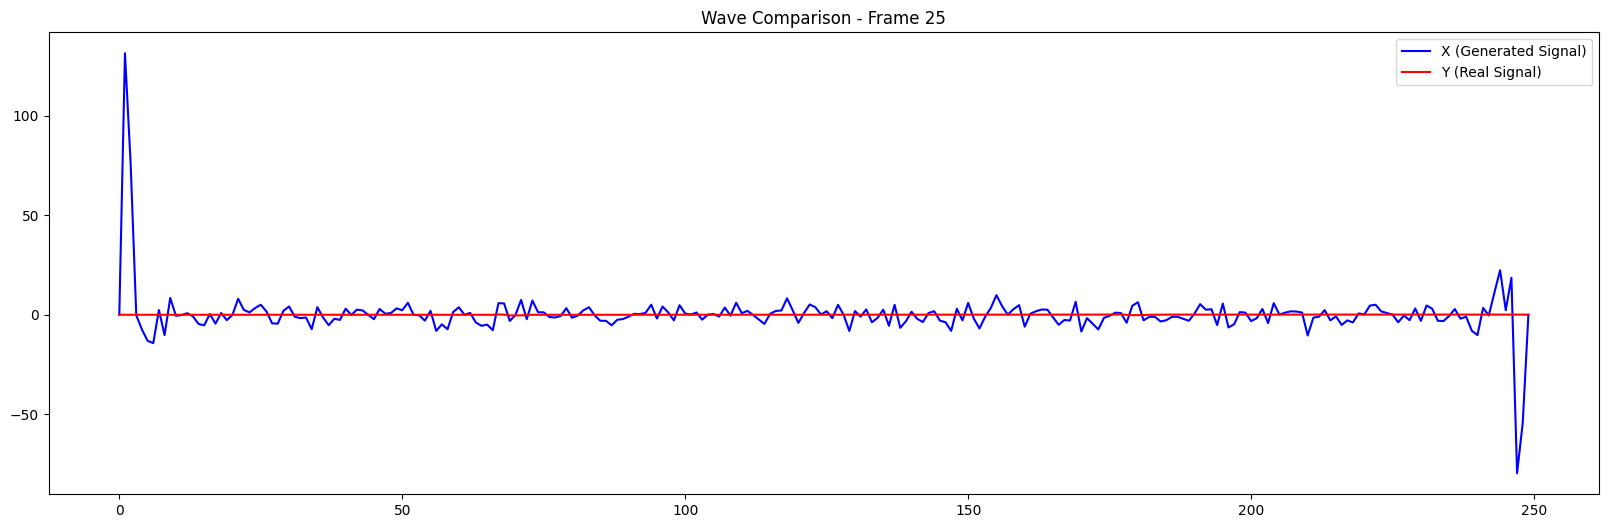

Frame 25:
Mean Squared Error (MSE): 148.7135
Fréchet Distance: 131.2796
Epoch 130/1000, Discrimiator Loss: 0.0, Generator Loss: 19.824153900146484
Epoch 131/1000, Discrimiator Loss: 0.0, Generator Loss: 19.3776798248291
Epoch 132/1000, Discrimiator Loss: 0.0, Generator Loss: 19.839405059814453
Epoch 133/1000, Discrimiator Loss: 0.0, Generator Loss: 19.916744232177734
Epoch 134/1000, Discrimiator Loss: 0.0, Generator Loss: 20.085634231567383
Epoch 135/1000, Discrimiator Loss: 0.0, Generator Loss: 19.438077926635742
Epoch 136/1000, Discrimiator Loss: 0.0, Generator Loss: 19.65229606628418
Epoch 137/1000, Discrimiator Loss: 0.0, Generator Loss: 19.754711151123047
Epoch 138/1000, Discrimiator Loss: 0.0, Generator Loss: 19.767366409301758
Epoch 139/1000, Discrimiator Loss: 0.0, Generator Loss: 19.70499610900879


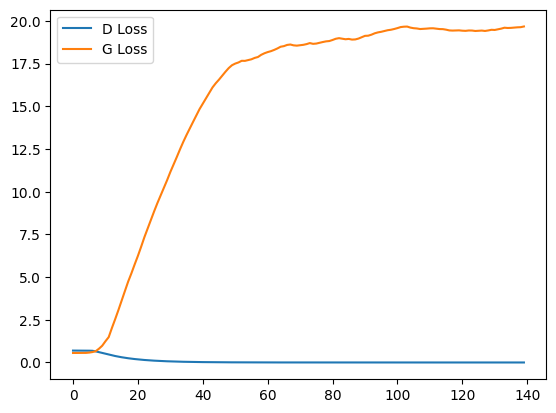

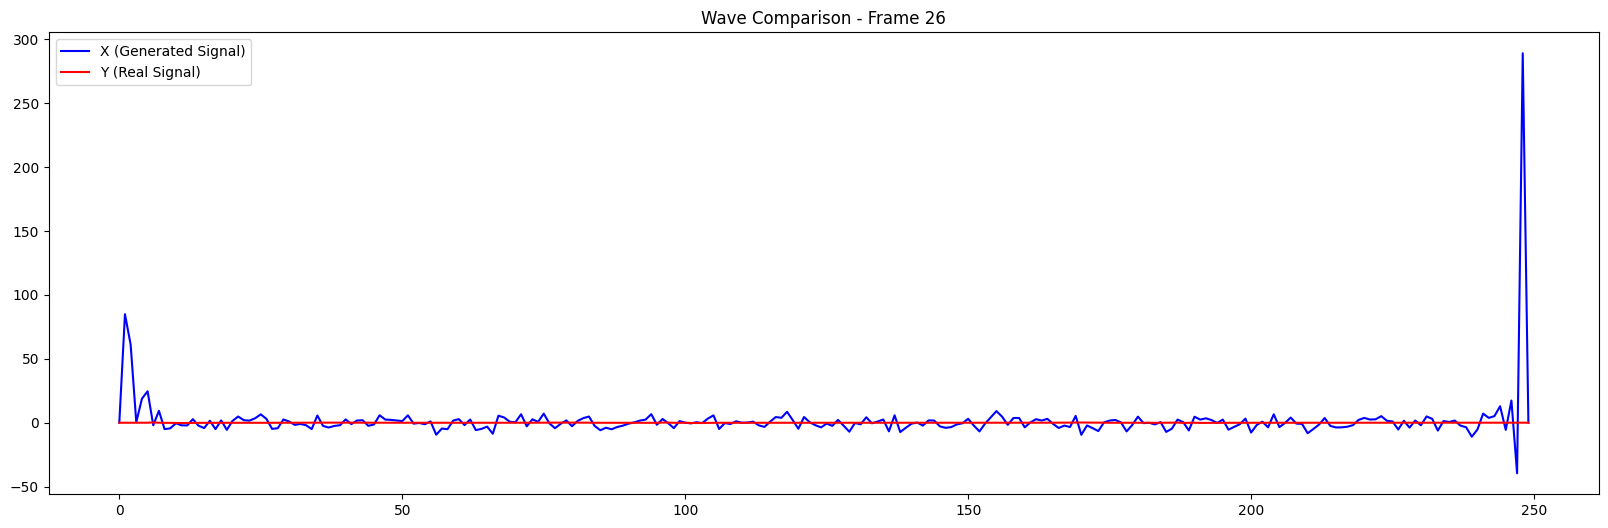

Frame 26:
Mean Squared Error (MSE): 403.7770
Fréchet Distance: 288.9046


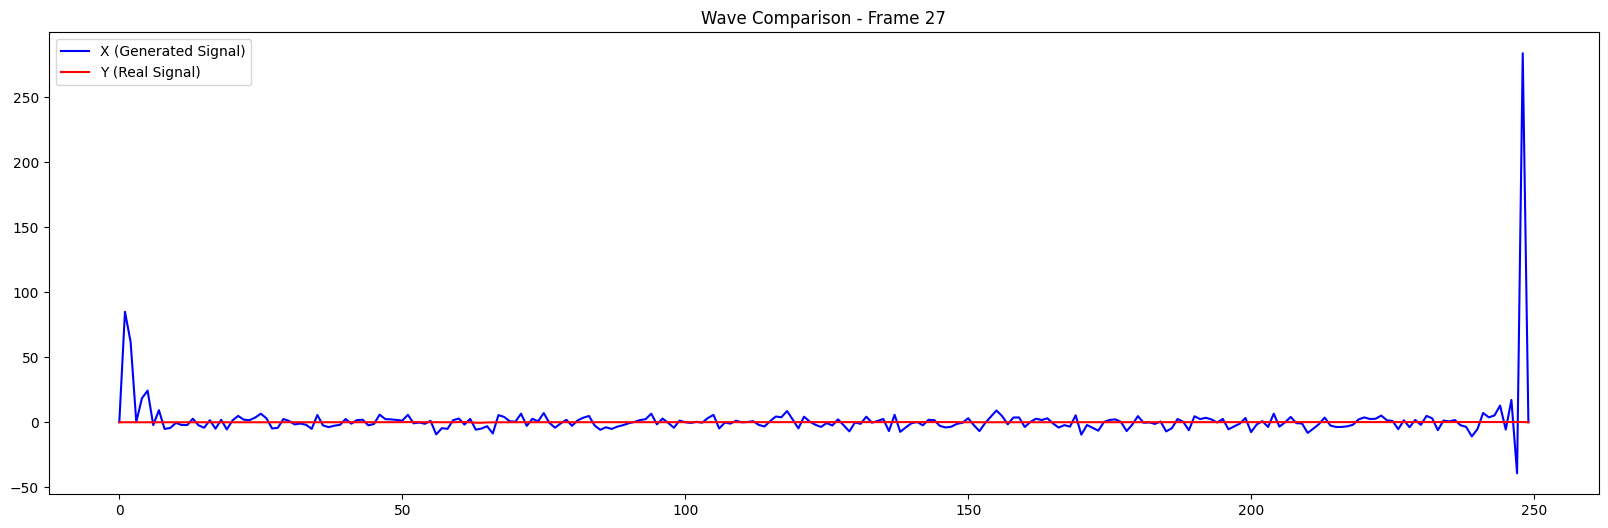

Frame 27:
Mean Squared Error (MSE): 390.6485
Fréchet Distance: 283.4206
Epoch 140/1000, Discrimiator Loss: 0.0, Generator Loss: 20.043821334838867
Epoch 141/1000, Discrimiator Loss: 0.0, Generator Loss: 19.414533615112305
Epoch 142/1000, Discrimiator Loss: 0.0, Generator Loss: 19.61855125427246
Epoch 143/1000, Discrimiator Loss: 0.0, Generator Loss: 19.78586196899414
Epoch 144/1000, Discrimiator Loss: 0.0, Generator Loss: 19.801111221313477
Epoch 145/1000, Discrimiator Loss: 0.0, Generator Loss: 19.87885856628418
Epoch 146/1000, Discrimiator Loss: 0.0, Generator Loss: 19.47369384765625
Epoch 147/1000, Discrimiator Loss: 0.0, Generator Loss: 19.774015426635742
Epoch 148/1000, Discrimiator Loss: 0.0, Generator Loss: 23.99932098388672
Epoch 149/1000, Discrimiator Loss: 0.0, Generator Loss: 24.282358169555664


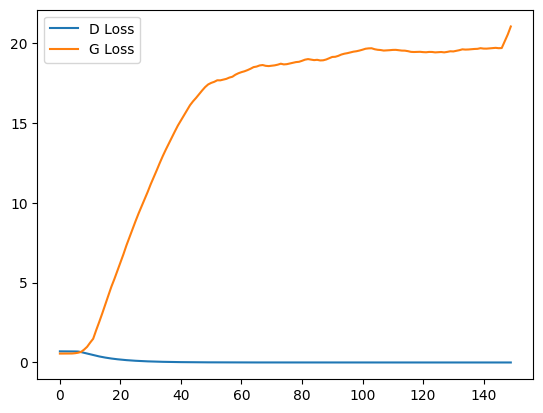

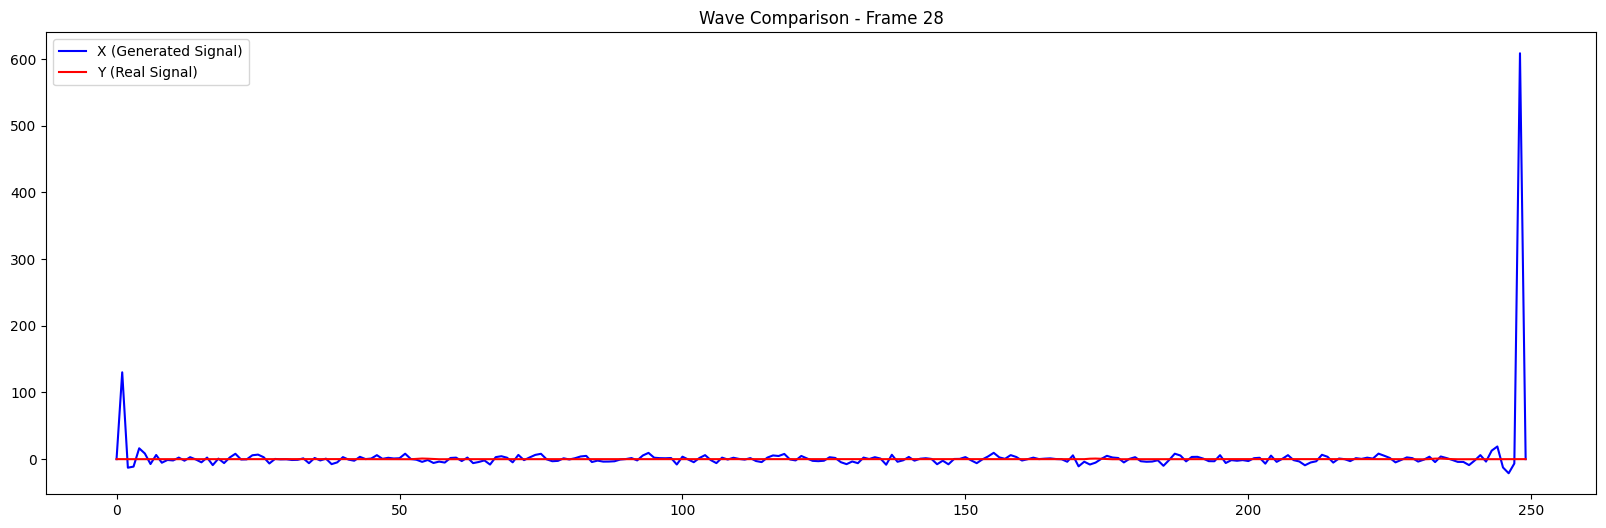

Frame 28:
Mean Squared Error (MSE): 1573.5590
Fréchet Distance: 607.8760


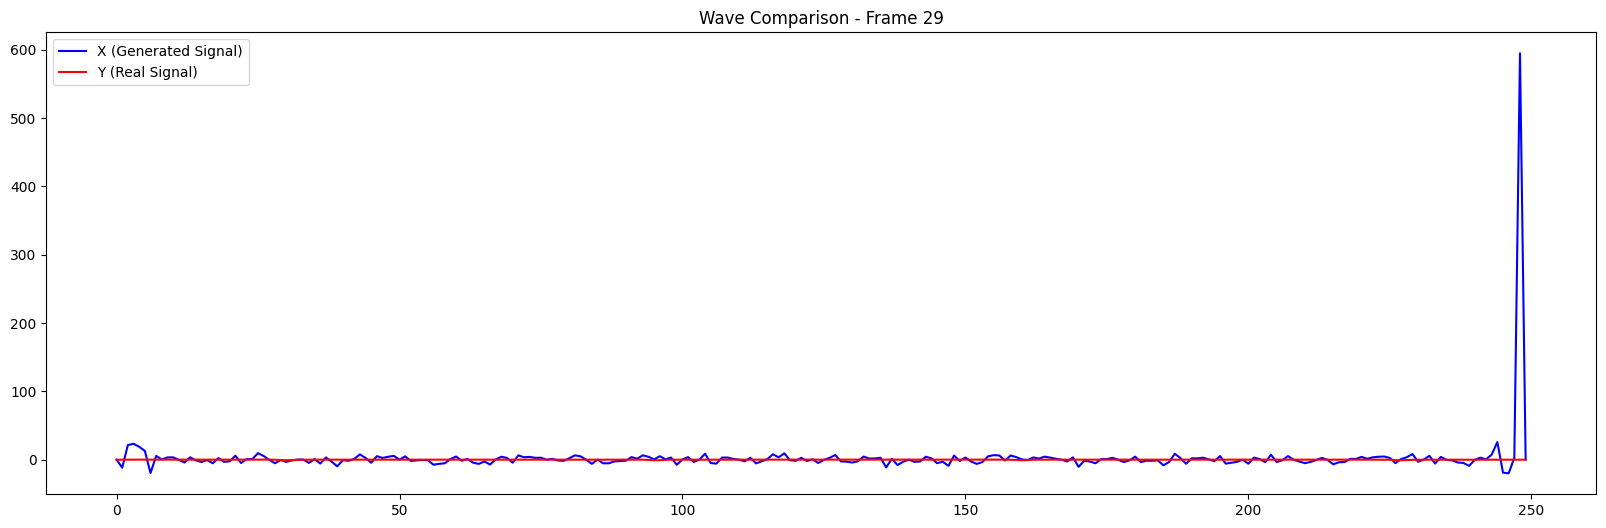

Frame 29:
Mean Squared Error (MSE): 1445.6439
Fréchet Distance: 594.8040
Epoch 150/1000, Discrimiator Loss: 0.0, Generator Loss: 25.53572654724121
Epoch 151/1000, Discrimiator Loss: 0.0, Generator Loss: 24.26442527770996
Epoch 152/1000, Discrimiator Loss: 0.0, Generator Loss: 24.0831241607666
Epoch 153/1000, Discrimiator Loss: 0.0, Generator Loss: 24.05169105529785
Epoch 154/1000, Discrimiator Loss: 0.0, Generator Loss: 24.1685791015625
Epoch 155/1000, Discrimiator Loss: 0.0, Generator Loss: 22.918846130371094
Epoch 156/1000, Discrimiator Loss: 0.0, Generator Loss: 23.578432083129883
Epoch 157/1000, Discrimiator Loss: 0.0, Generator Loss: 21.479684829711914
Epoch 158/1000, Discrimiator Loss: 0.0, Generator Loss: 26.613990783691406
Epoch 159/1000, Discrimiator Loss: 1.862645149230957e-09, Generator Loss: 23.689023971557617


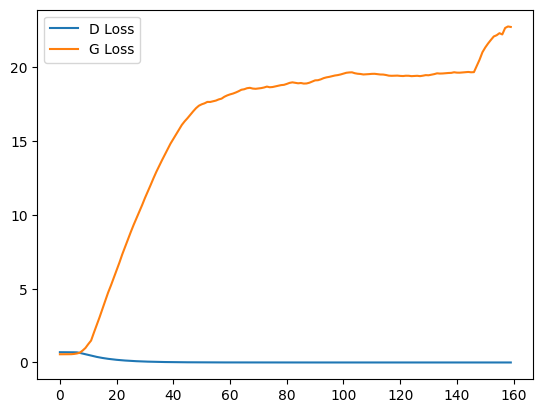

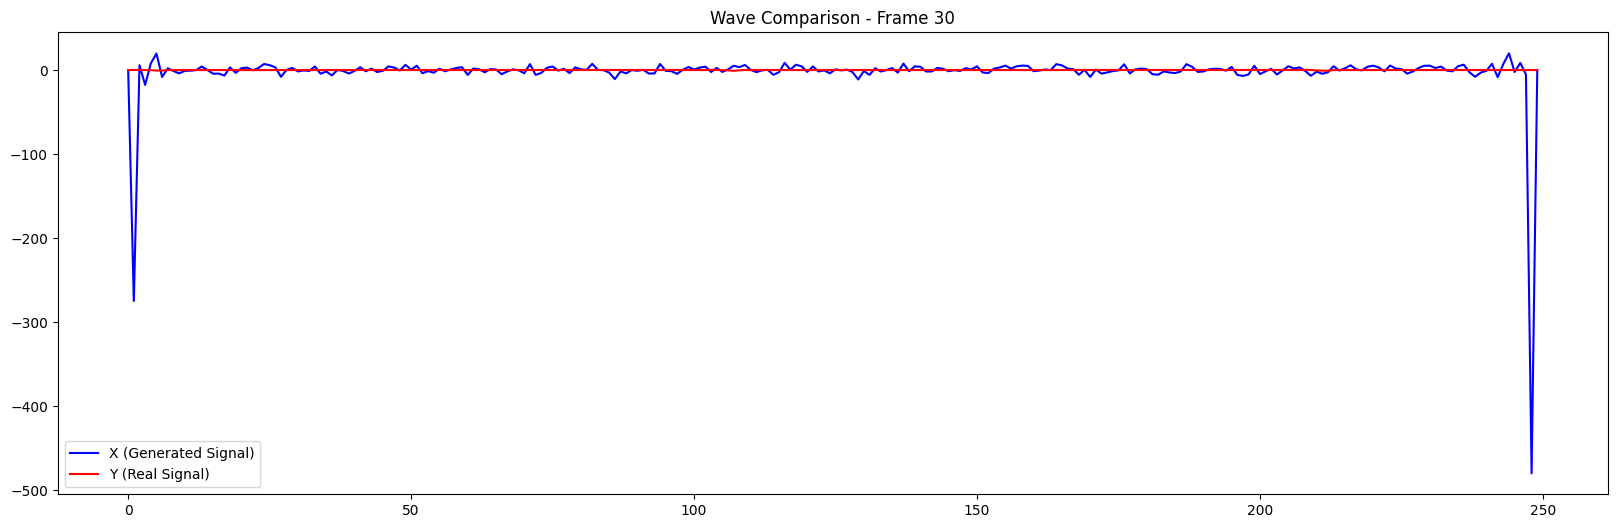

Frame 30:
Mean Squared Error (MSE): 1240.5658
Fréchet Distance: 478.7236


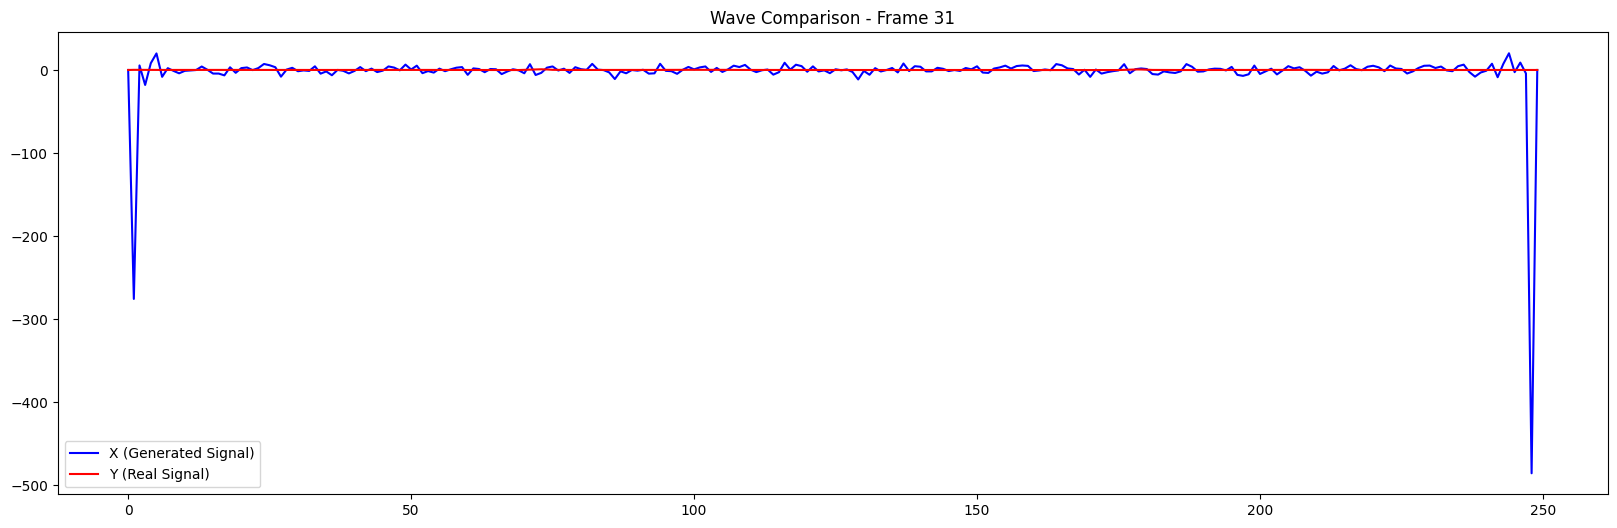

Frame 31:
Mean Squared Error (MSE): 1265.4823
Fréchet Distance: 485.2552
Epoch 160/1000, Discrimiator Loss: 0.0, Generator Loss: 22.457063674926758
Epoch 161/1000, Discrimiator Loss: 0.0, Generator Loss: 22.387521743774414
Epoch 162/1000, Discrimiator Loss: 0.0, Generator Loss: 21.975534439086914
Epoch 163/1000, Discrimiator Loss: 0.0, Generator Loss: 21.769502639770508
Epoch 164/1000, Discrimiator Loss: 0.0, Generator Loss: 24.797016143798828
Epoch 165/1000, Discrimiator Loss: 0.0, Generator Loss: 22.64092254638672
Epoch 166/1000, Discrimiator Loss: 0.0, Generator Loss: 21.376955032348633
Epoch 167/1000, Discrimiator Loss: 0.0, Generator Loss: 21.971593856811523
Epoch 168/1000, Discrimiator Loss: 0.0, Generator Loss: 21.229496002197266
Epoch 169/1000, Discrimiator Loss: 0.0, Generator Loss: 23.162322998046875


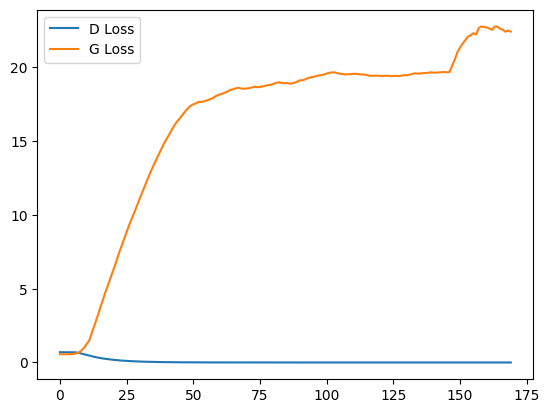

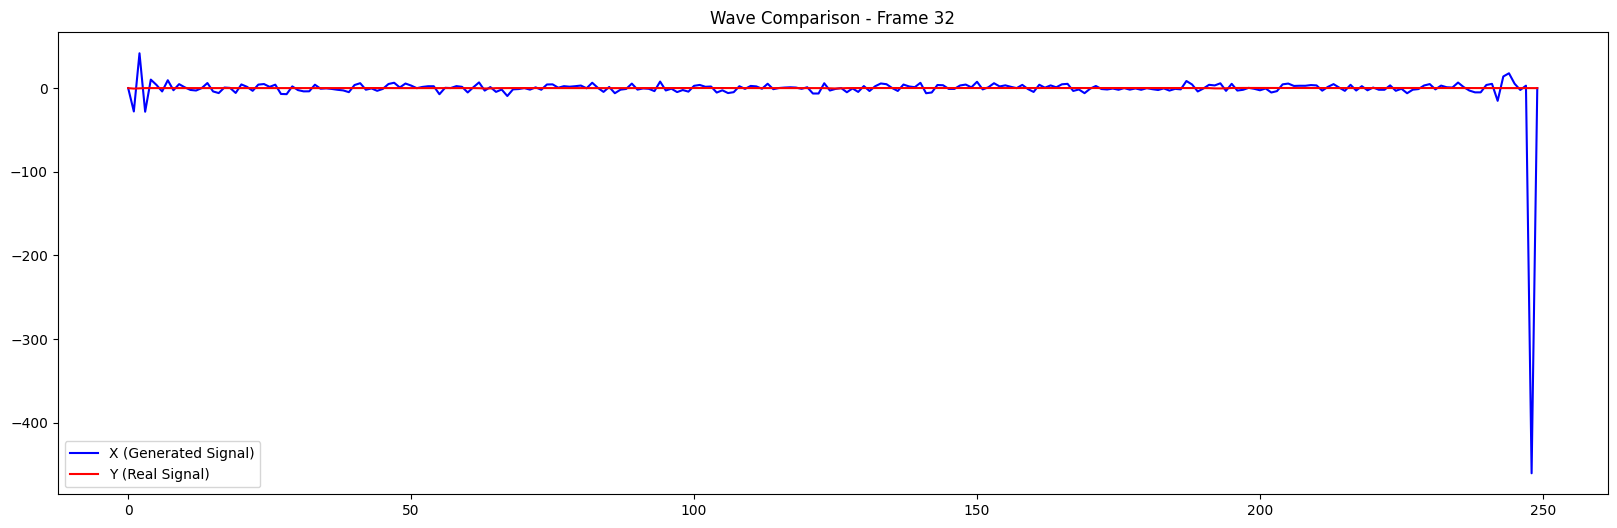

Frame 32:
Mean Squared Error (MSE): 877.5773
Fréchet Distance: 459.9939


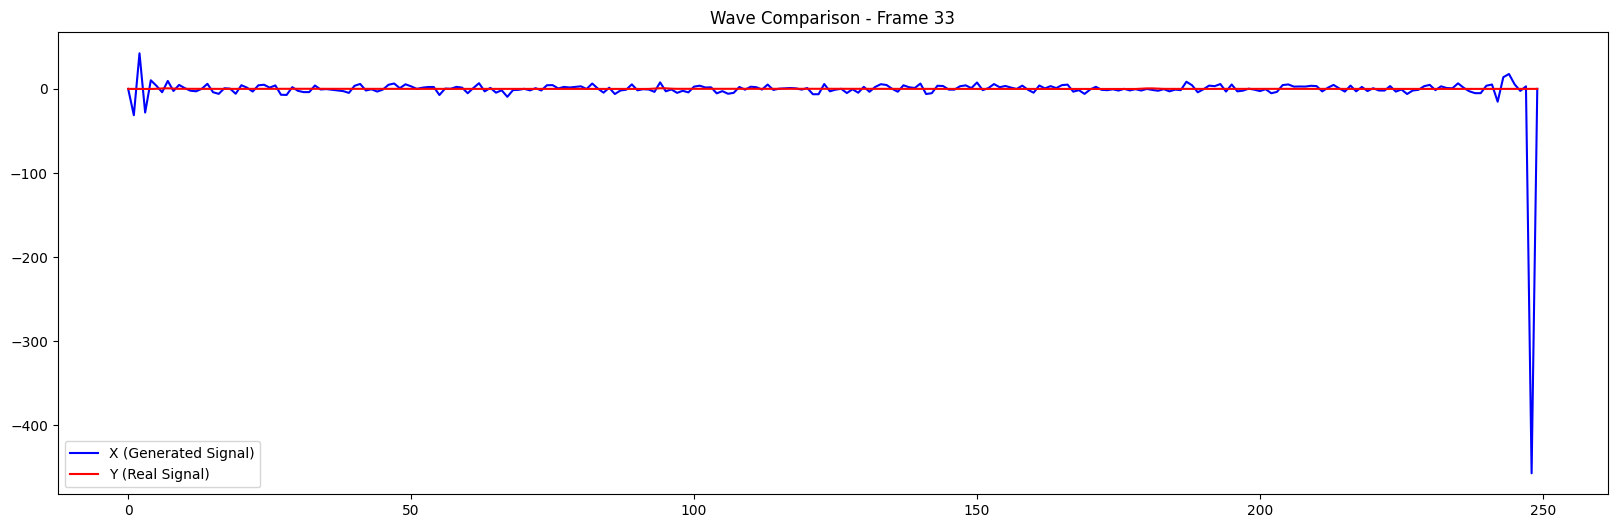

Frame 33:
Mean Squared Error (MSE): 865.5623
Fréchet Distance: 457.0776
Epoch 170/1000, Discrimiator Loss: 0.0, Generator Loss: 21.81464958190918
Epoch 171/1000, Discrimiator Loss: 0.0, Generator Loss: 20.90190315246582
Epoch 172/1000, Discrimiator Loss: 0.0, Generator Loss: 21.942855834960938
Epoch 173/1000, Discrimiator Loss: 0.0, Generator Loss: 22.185958862304688
Epoch 174/1000, Discrimiator Loss: 0.0, Generator Loss: 22.0340576171875
Epoch 175/1000, Discrimiator Loss: 0.0, Generator Loss: 22.46602439880371
Epoch 176/1000, Discrimiator Loss: 0.0, Generator Loss: 22.018463134765625
Epoch 177/1000, Discrimiator Loss: 0.0, Generator Loss: 21.496295928955078
Epoch 178/1000, Discrimiator Loss: 0.0, Generator Loss: 25.93965721130371
Epoch 179/1000, Discrimiator Loss: 0.0, Generator Loss: 29.260250091552734


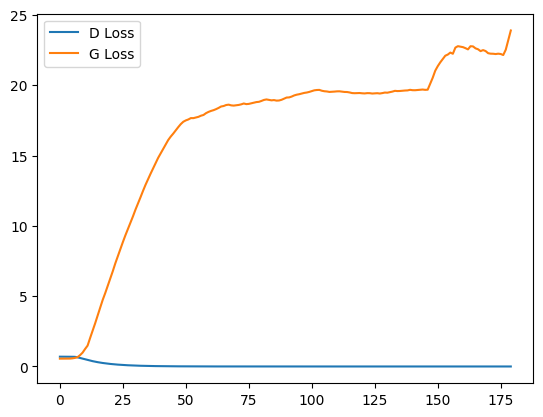

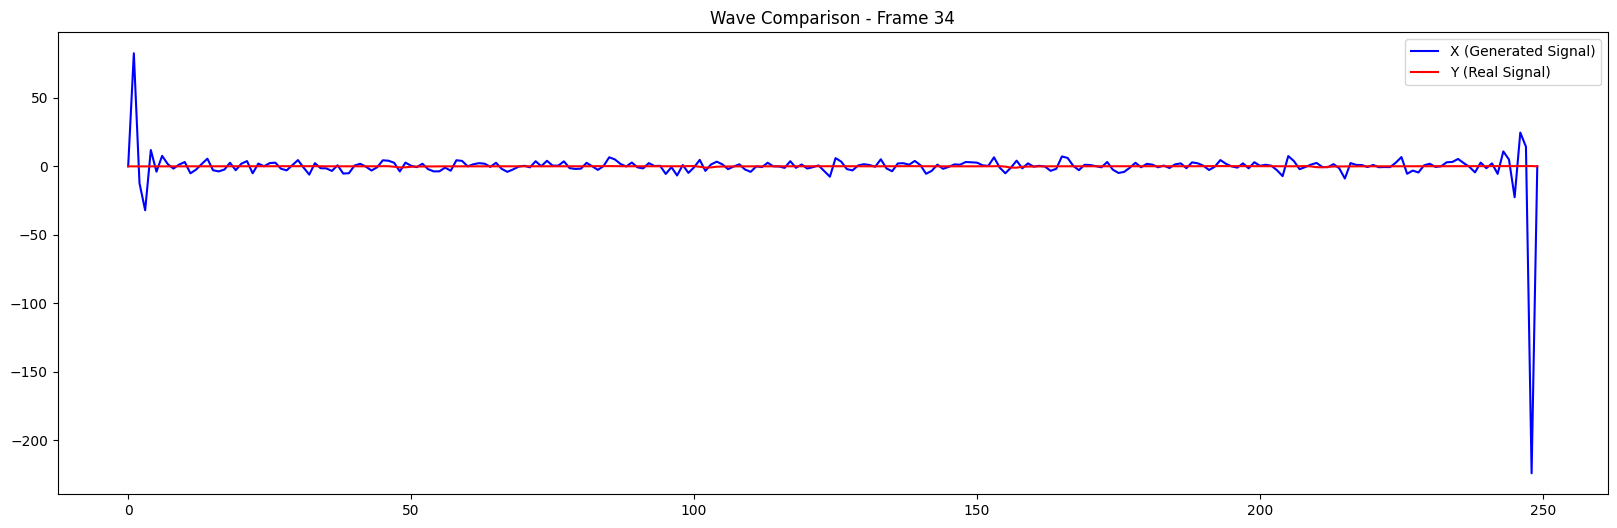

Frame 34:
Mean Squared Error (MSE): 247.4972
Fréchet Distance: 222.9510


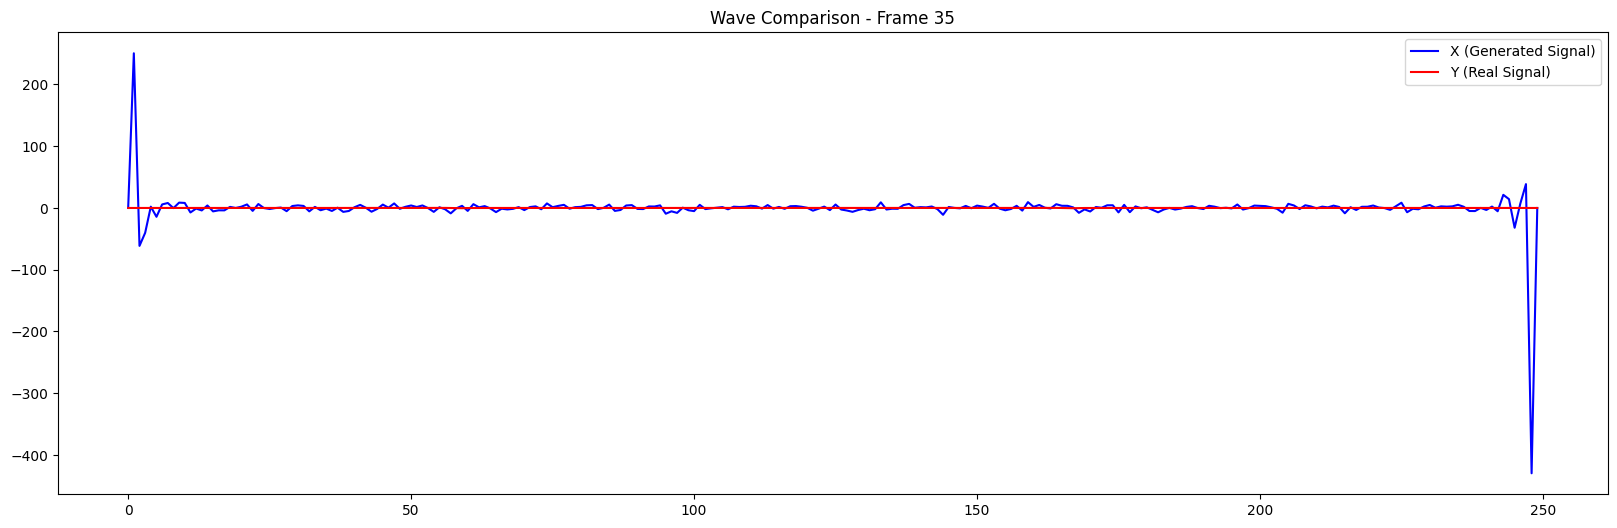

Frame 35:
Mean Squared Error (MSE): 1038.8618
Fréchet Distance: 429.1983
Epoch 180/1000, Discrimiator Loss: 0.0, Generator Loss: 30.12955093383789
Epoch 181/1000, Discrimiator Loss: 0.0, Generator Loss: 29.0324764251709
Epoch 182/1000, Discrimiator Loss: 0.0, Generator Loss: 29.21231460571289
Epoch 183/1000, Discrimiator Loss: 0.0, Generator Loss: 28.293413162231445
Epoch 184/1000, Discrimiator Loss: 0.0, Generator Loss: 28.6561222076416
Epoch 185/1000, Discrimiator Loss: 0.0, Generator Loss: 27.298694610595703
Epoch 186/1000, Discrimiator Loss: 0.0, Generator Loss: 29.34221839904785
Epoch 187/1000, Discrimiator Loss: 0.0, Generator Loss: 29.93121910095215
Epoch 188/1000, Discrimiator Loss: 0.0, Generator Loss: 28.75874137878418
Epoch 189/1000, Discrimiator Loss: 0.0, Generator Loss: 30.794048309326172


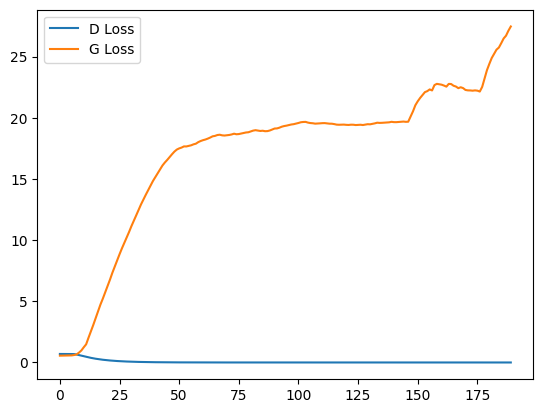

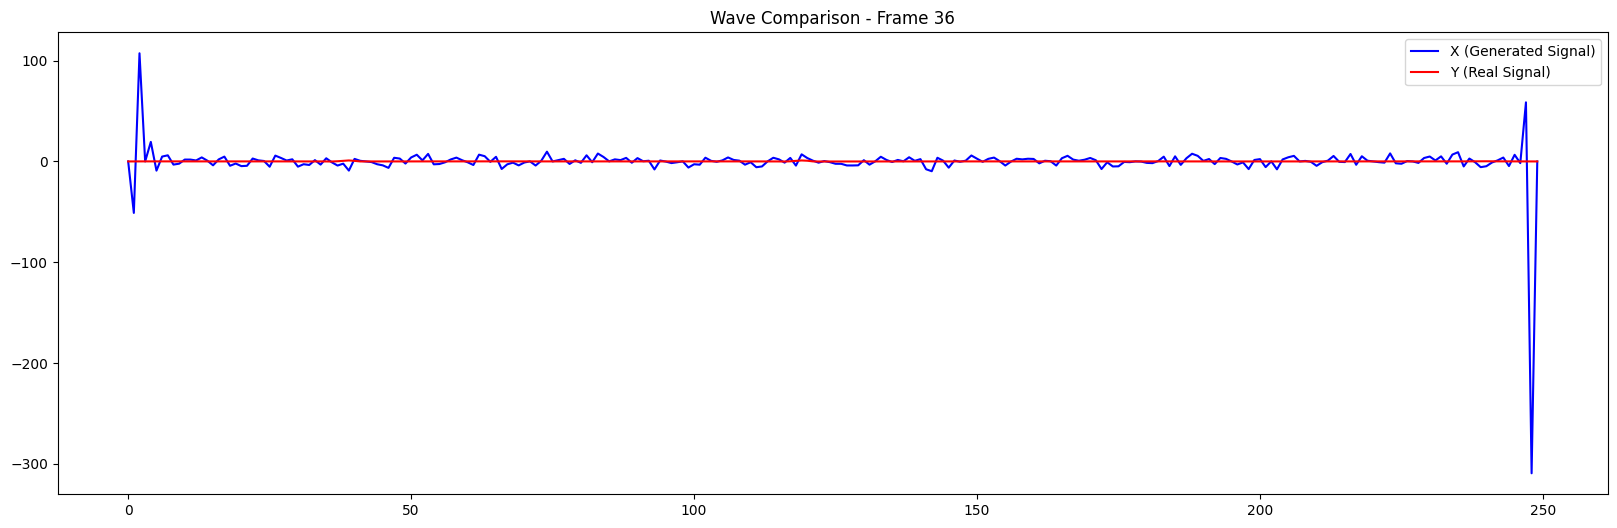

Frame 36:
Mean Squared Error (MSE): 468.0302
Fréchet Distance: 309.4194


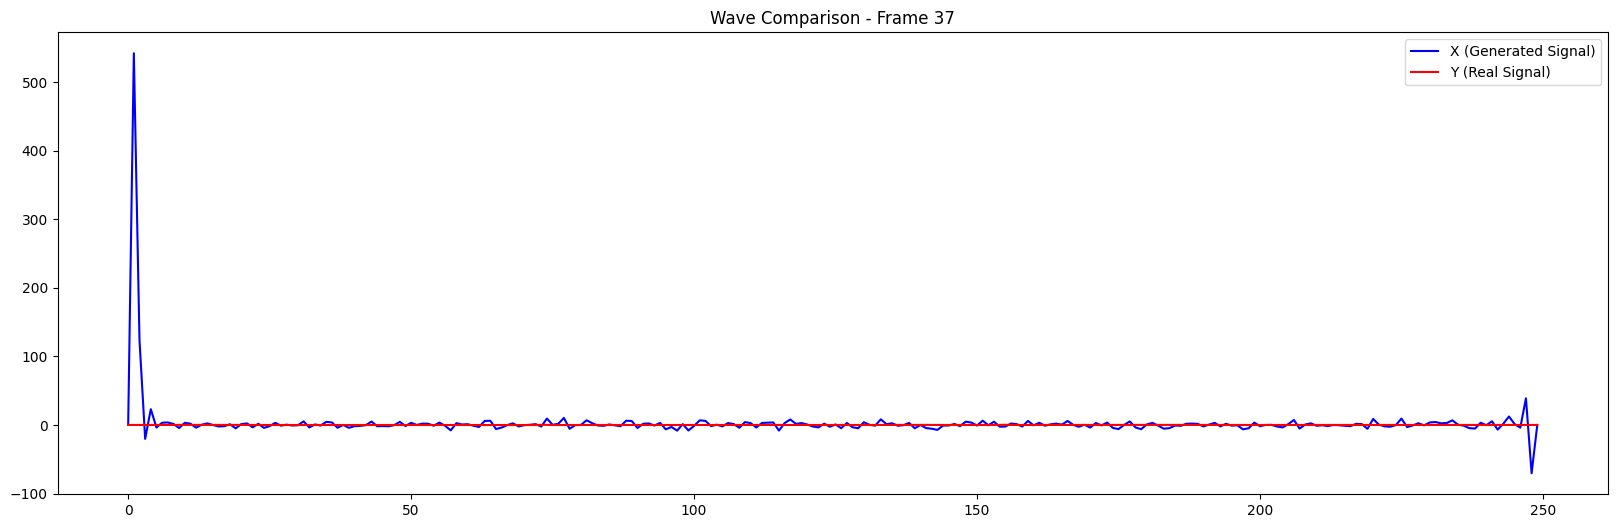

Frame 37:
Mean Squared Error (MSE): 1278.1036
Fréchet Distance: 541.6496
Epoch 190/1000, Discrimiator Loss: 0.0, Generator Loss: 30.570329666137695
Epoch 191/1000, Discrimiator Loss: 0.0, Generator Loss: 30.85002899169922
Epoch 192/1000, Discrimiator Loss: 0.0, Generator Loss: 31.771533966064453
Epoch 193/1000, Discrimiator Loss: 0.0, Generator Loss: 31.1395320892334
Epoch 194/1000, Discrimiator Loss: 0.0, Generator Loss: 31.864303588867188
Epoch 195/1000, Discrimiator Loss: 0.0, Generator Loss: 29.925811767578125
Epoch 196/1000, Discrimiator Loss: 0.0, Generator Loss: 30.177412033081055
Epoch 197/1000, Discrimiator Loss: 0.0, Generator Loss: 33.61307144165039
Epoch 198/1000, Discrimiator Loss: 0.0, Generator Loss: 35.24571990966797
Epoch 199/1000, Discrimiator Loss: 0.0, Generator Loss: 36.08474349975586


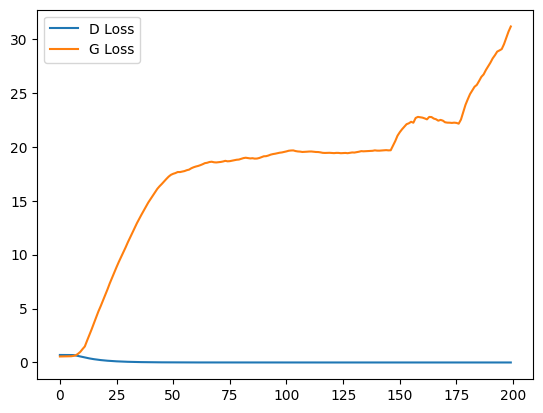

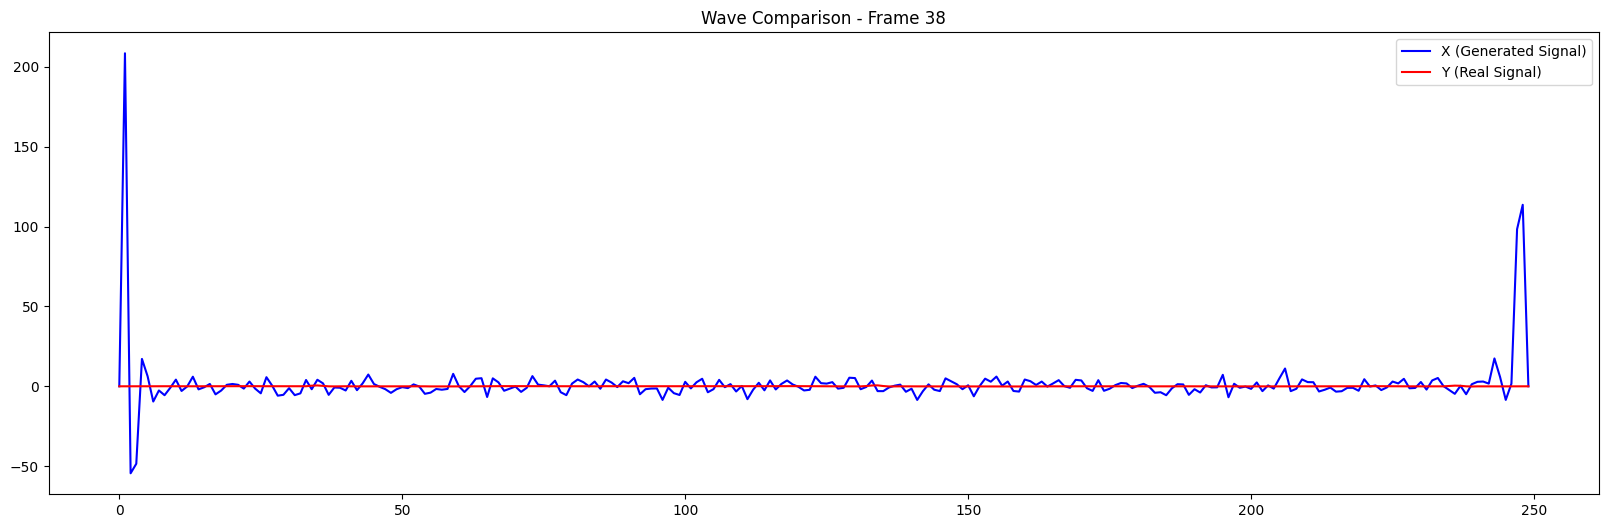

Frame 38:
Mean Squared Error (MSE): 298.9895
Fréchet Distance: 207.8354


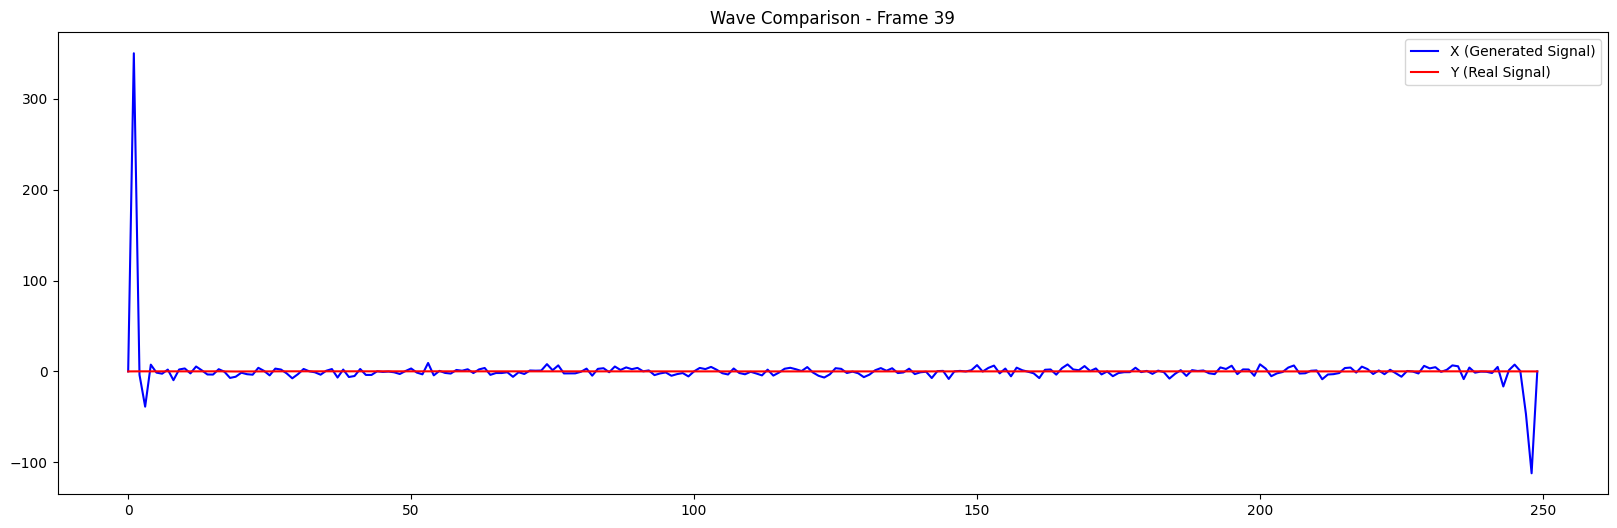

Frame 39:
Mean Squared Error (MSE): 569.5074
Fréchet Distance: 350.1239
Epoch 200/1000, Discrimiator Loss: 0.0, Generator Loss: 35.390445709228516
Epoch 201/1000, Discrimiator Loss: 0.0, Generator Loss: 35.49989700317383
Epoch 202/1000, Discrimiator Loss: 0.0, Generator Loss: 36.5566291809082
Epoch 203/1000, Discrimiator Loss: 0.0, Generator Loss: 36.581607818603516
Epoch 204/1000, Discrimiator Loss: 0.0, Generator Loss: 36.401790618896484
Epoch 205/1000, Discrimiator Loss: 0.0, Generator Loss: 36.76760482788086
Epoch 206/1000, Discrimiator Loss: 0.0, Generator Loss: 36.15751647949219
Epoch 207/1000, Discrimiator Loss: 0.0, Generator Loss: 35.81721496582031
Epoch 208/1000, Discrimiator Loss: 0.0, Generator Loss: 35.476776123046875
Epoch 209/1000, Discrimiator Loss: 0.0, Generator Loss: 38.68635559082031


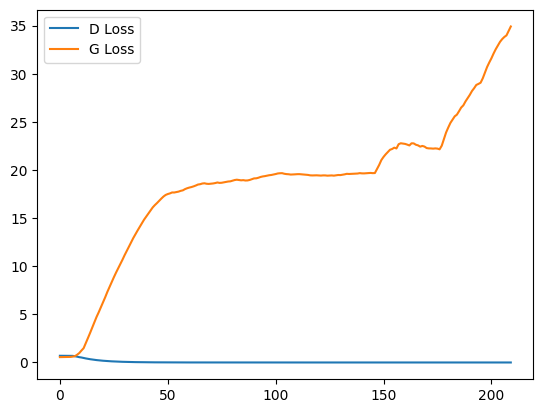

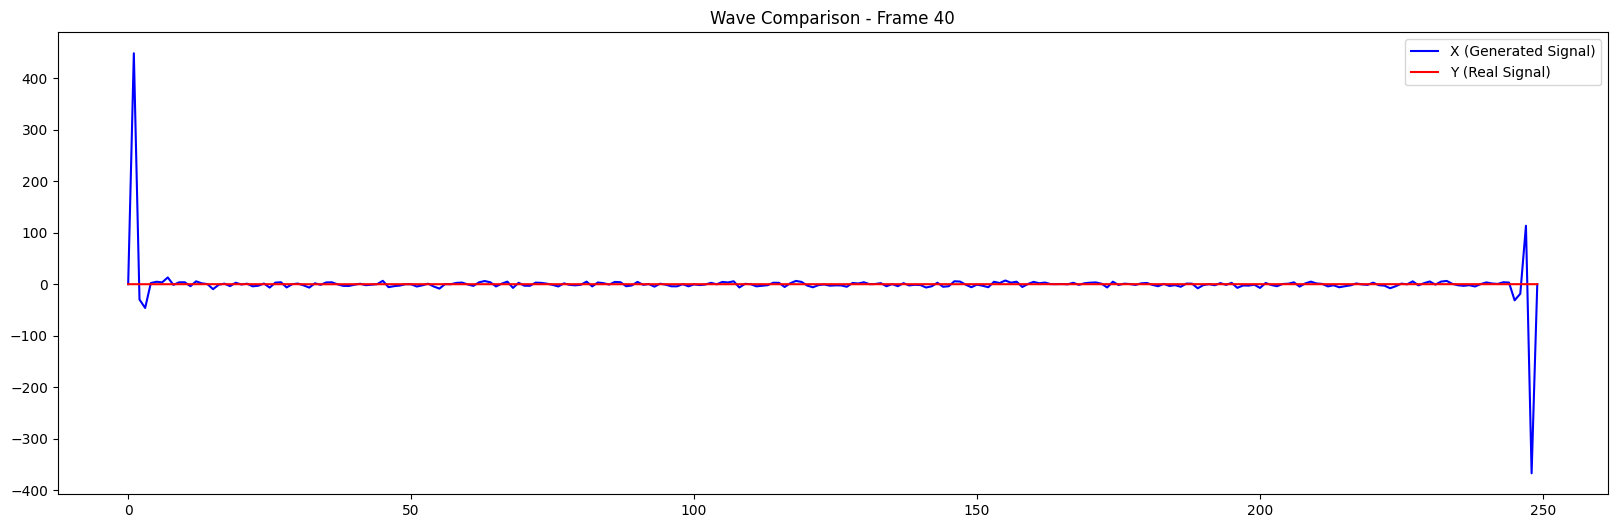

Frame 40:
Mean Squared Error (MSE): 1421.6562
Fréchet Distance: 447.7417


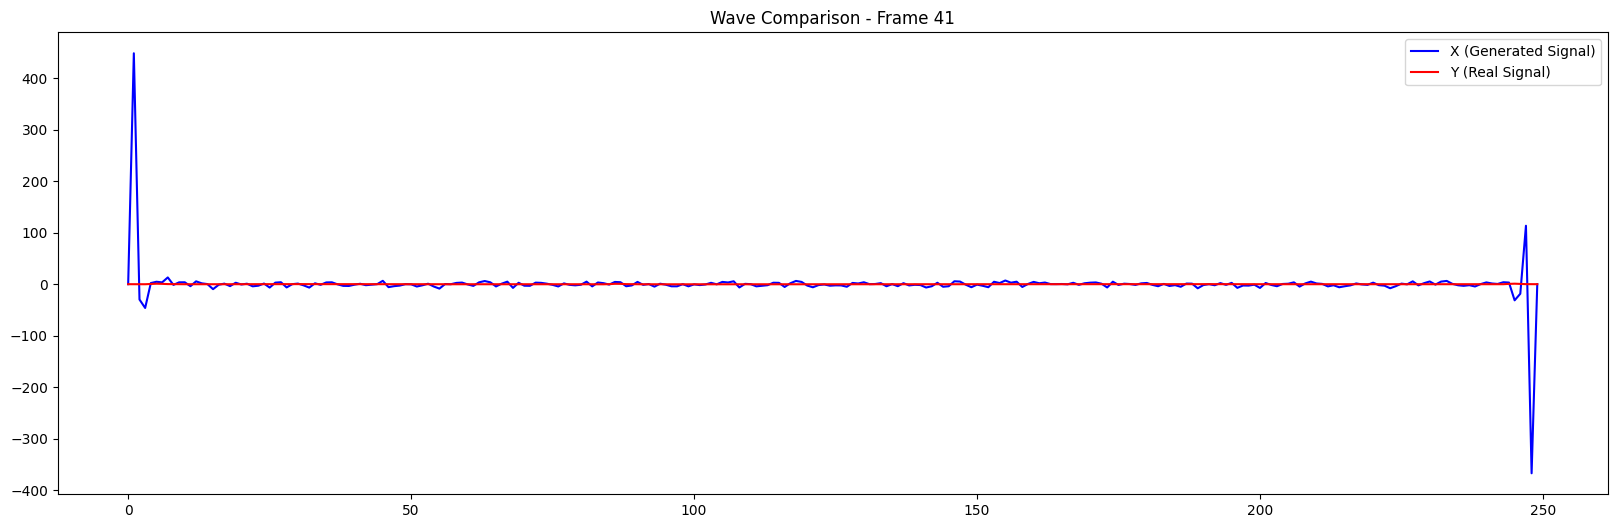

Frame 41:
Mean Squared Error (MSE): 1421.6062
Fréchet Distance: 446.9348
Epoch 210/1000, Discrimiator Loss: 0.0, Generator Loss: 39.0019416809082
Epoch 211/1000, Discrimiator Loss: 0.0, Generator Loss: 38.88385772705078
Epoch 212/1000, Discrimiator Loss: 0.0, Generator Loss: 38.916507720947266
Epoch 213/1000, Discrimiator Loss: 0.0, Generator Loss: 38.9494514465332
Epoch 214/1000, Discrimiator Loss: 0.0, Generator Loss: 38.822967529296875
Epoch 215/1000, Discrimiator Loss: 0.0, Generator Loss: 38.75908660888672
Epoch 216/1000, Discrimiator Loss: 0.0, Generator Loss: 38.85651397705078
Epoch 217/1000, Discrimiator Loss: 0.0, Generator Loss: 38.921573638916016
Epoch 218/1000, Discrimiator Loss: 0.0, Generator Loss: 38.78575134277344
Epoch 219/1000, Discrimiator Loss: 0.0, Generator Loss: 38.70258712768555


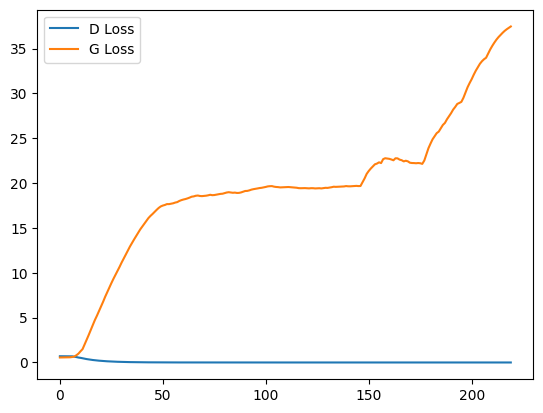

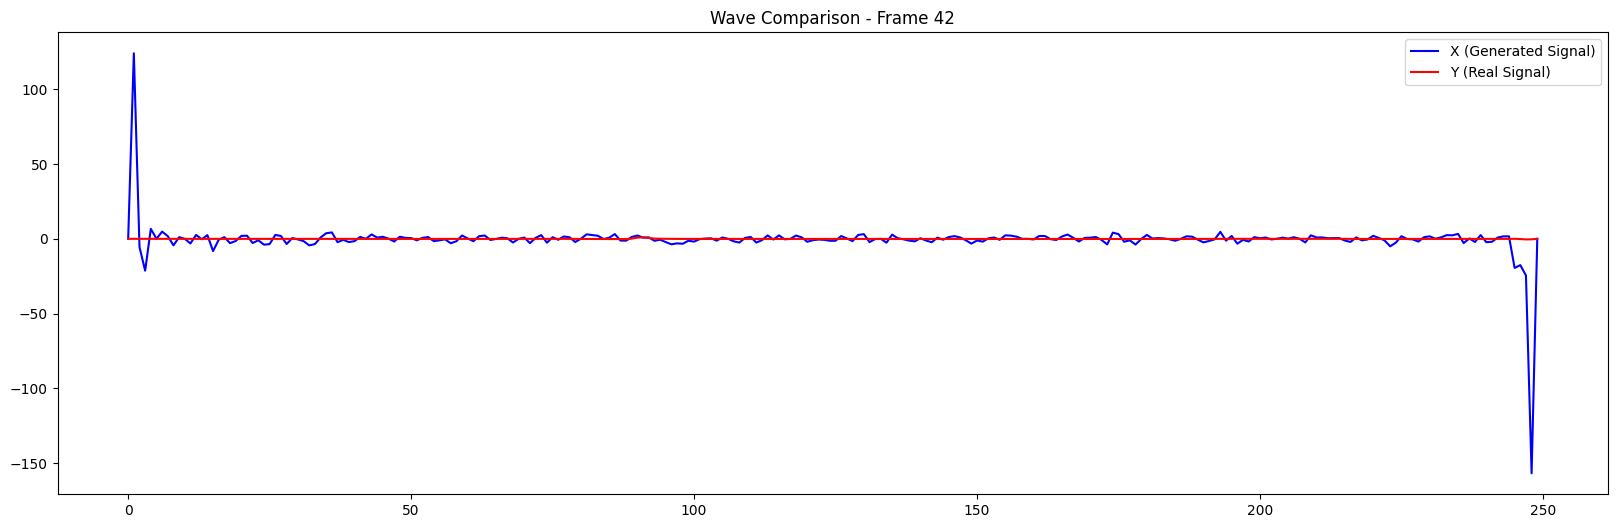

Frame 42:
Mean Squared Error (MSE): 169.8992
Fréchet Distance: 156.2576


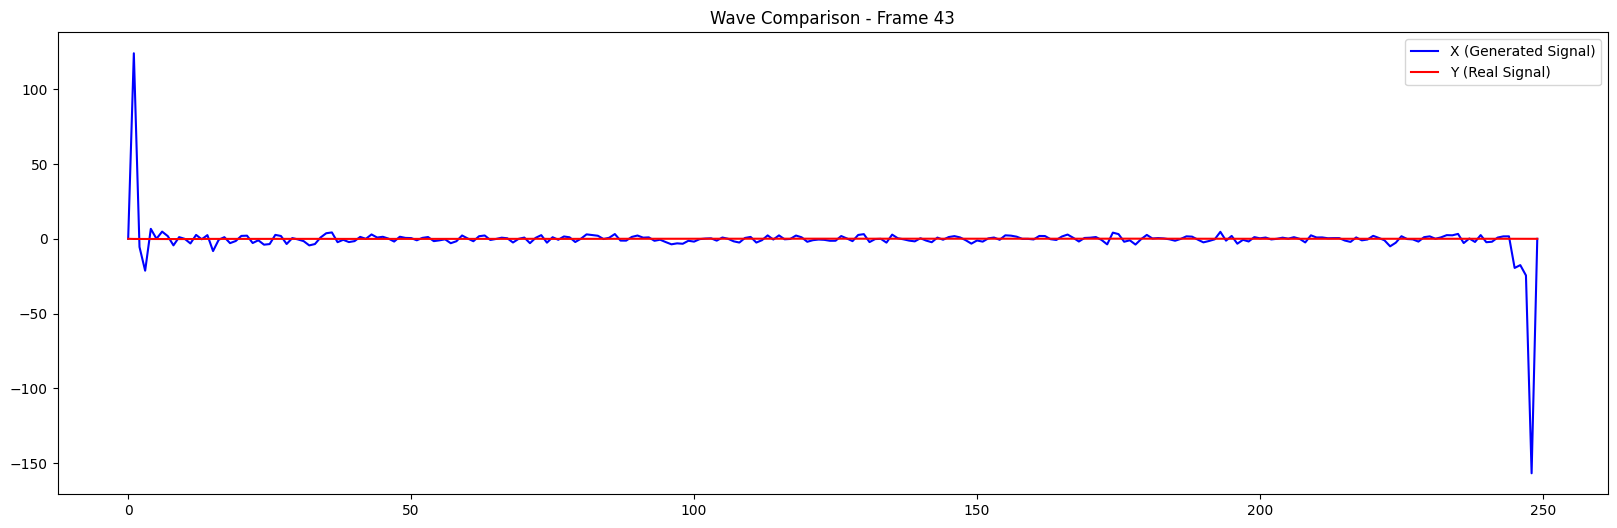

Frame 43:
Mean Squared Error (MSE): 170.5542
Fréchet Distance: 156.4699
Epoch 220/1000, Discrimiator Loss: 0.0, Generator Loss: 38.89933395385742
Epoch 221/1000, Discrimiator Loss: 0.0, Generator Loss: 38.68582534790039
Epoch 222/1000, Discrimiator Loss: 0.0, Generator Loss: 36.07842254638672
Epoch 223/1000, Discrimiator Loss: 0.001237685326486826, Generator Loss: 6.917496681213379
Epoch 224/1000, Discrimiator Loss: 0.0005208883085288107, Generator Loss: 8.554362297058105
Epoch 225/1000, Discrimiator Loss: 9.35623211262282e-06, Generator Loss: 9.16592788696289
Epoch 226/1000, Discrimiator Loss: 1.609992432349827e-05, Generator Loss: 9.130053520202637
Epoch 227/1000, Discrimiator Loss: 4.890409854851896e-06, Generator Loss: 9.706363677978516
Epoch 228/1000, Discrimiator Loss: 8.633373909106012e-07, Generator Loss: 11.189176559448242
Epoch 229/1000, Discrimiator Loss: 1.6233053656833363e-06, Generator Loss: 10.81481647491455


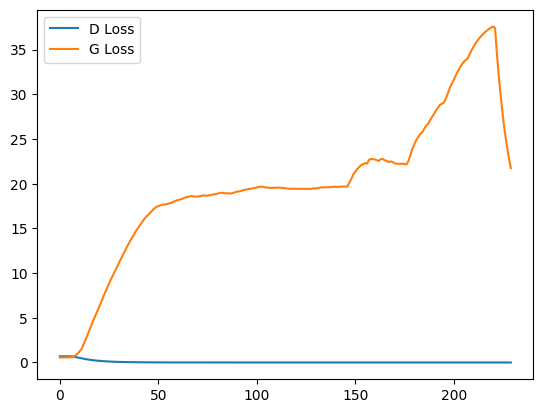

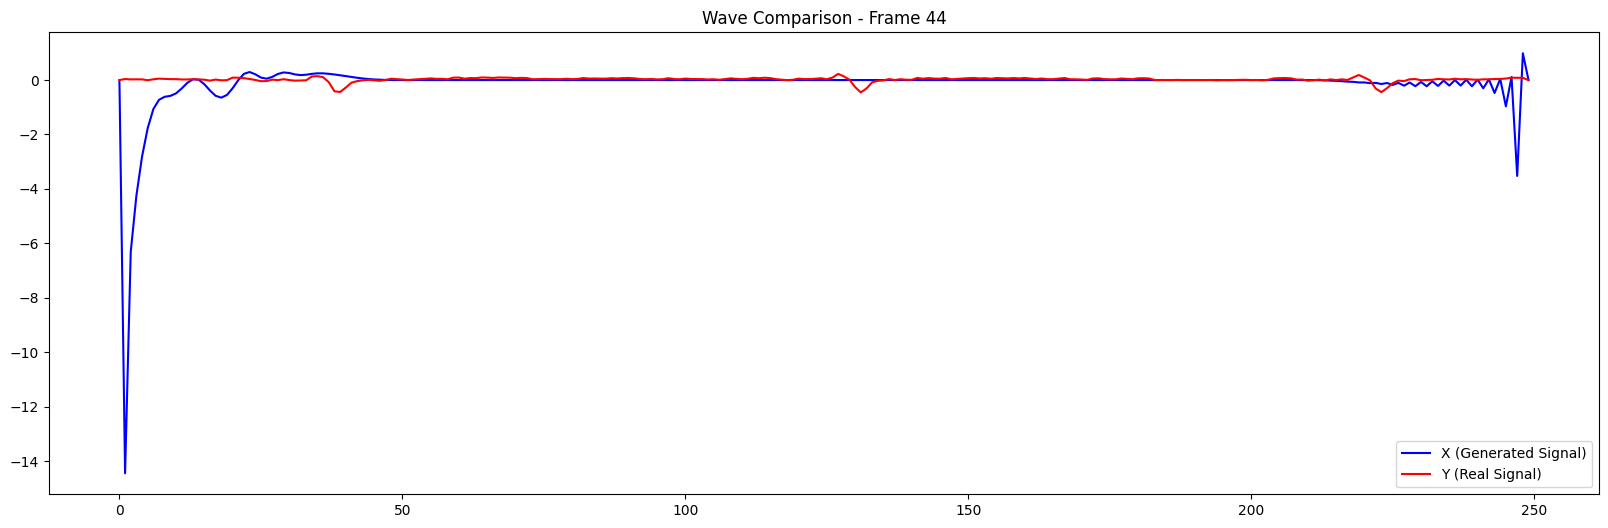

Frame 44:
Mean Squared Error (MSE): 1.2087
Fréchet Distance: 13.9951


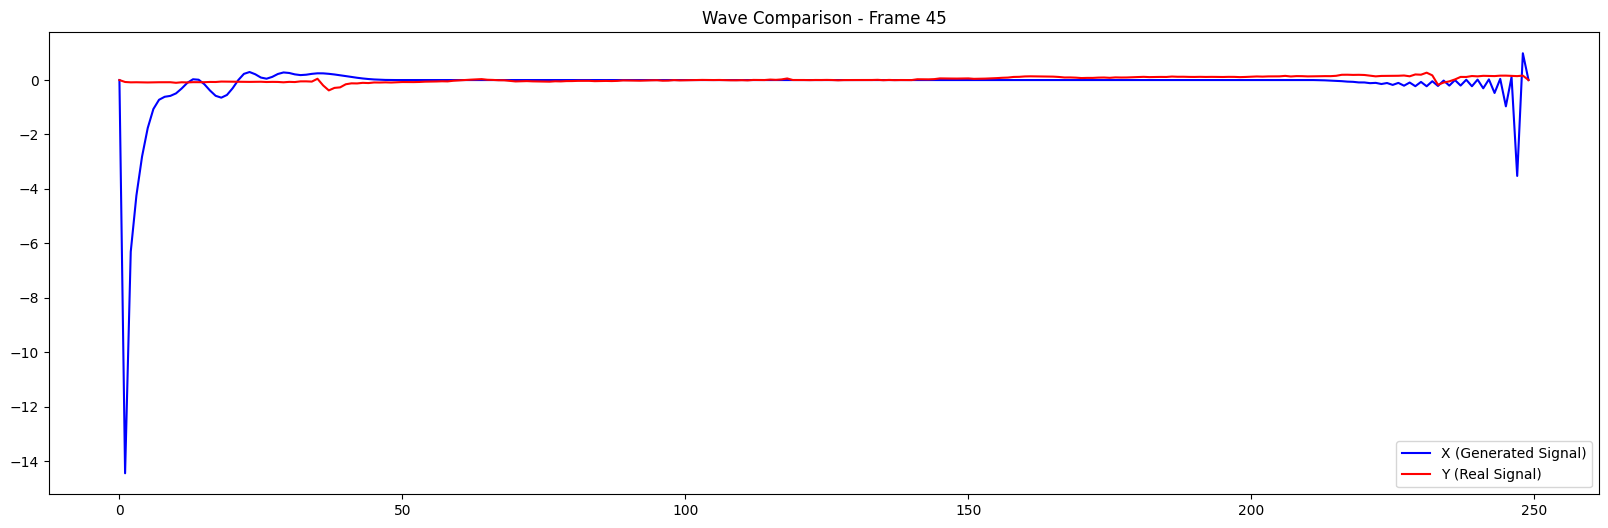

Frame 45:
Mean Squared Error (MSE): 1.1894
Fréchet Distance: 14.0690
Epoch 230/1000, Discrimiator Loss: 7.078061798893032e-07, Generator Loss: 11.160645484924316
Epoch 231/1000, Discrimiator Loss: 1.676385636528721e-06, Generator Loss: 10.57948112487793
Epoch 232/1000, Discrimiator Loss: 9.508823382020637e-07, Generator Loss: 12.982917785644531
Epoch 233/1000, Discrimiator Loss: 5.494803900774059e-08, Generator Loss: 13.330610275268555
Epoch 234/1000, Discrimiator Loss: 1.4126737369224429e-05, Generator Loss: 8.763455390930176
Epoch 235/1000, Discrimiator Loss: 6.958030553505523e-06, Generator Loss: 9.507165908813477
Epoch 236/1000, Discrimiator Loss: 3.596906753955409e-05, Generator Loss: 14.358367919921875
Epoch 237/1000, Discrimiator Loss: 5.4854933750903e-07, Generator Loss: 10.795697212219238
Epoch 238/1000, Discrimiator Loss: 4.0792036770653795e-07, Generator Loss: 11.125421524047852
Epoch 239/1000, Discrimiator Loss: 6.472735549323261e-06, Generator Loss: 11.171836853027344


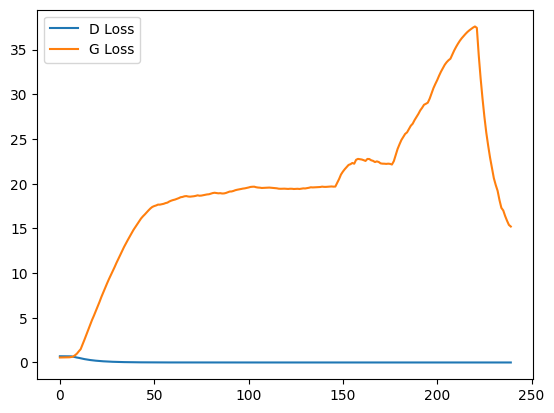

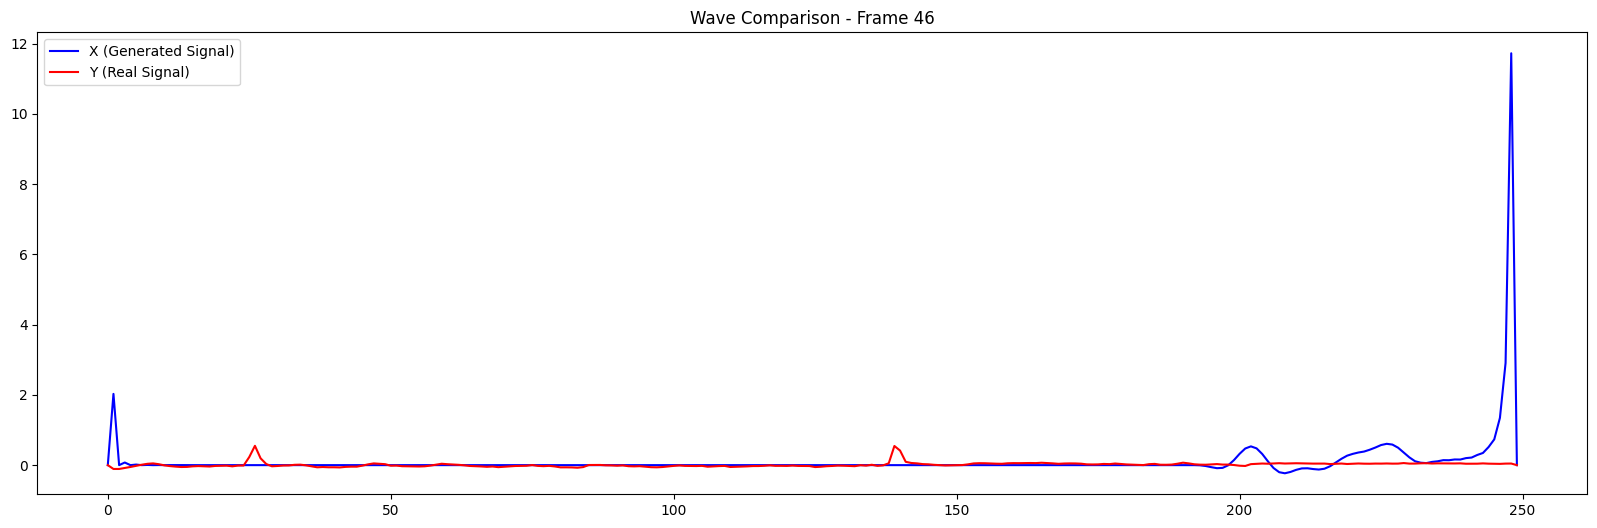

Frame 46:
Mean Squared Error (MSE): 0.6253
Fréchet Distance: 11.1768


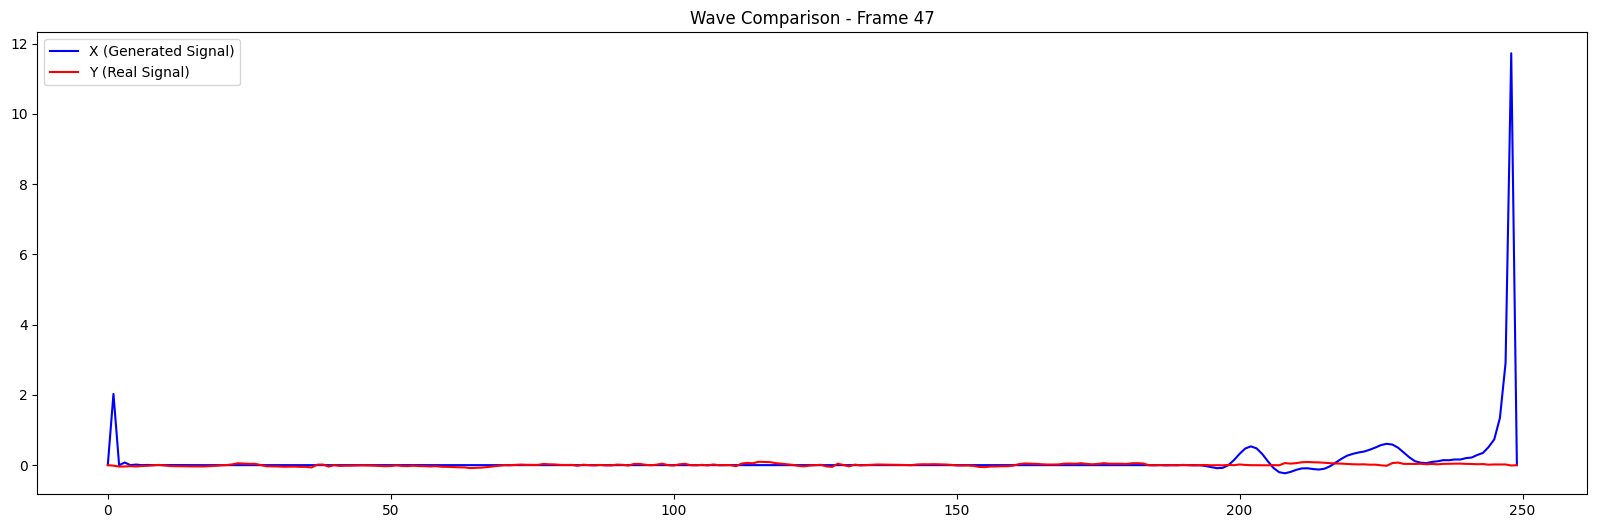

Frame 47:
Mean Squared Error (MSE): 0.6275
Fréchet Distance: 11.6313
Epoch 240/1000, Discrimiator Loss: 1.2917921594635118e-06, Generator Loss: 13.591291427612305
Epoch 241/1000, Discrimiator Loss: 1.555309552259132e-07, Generator Loss: 12.753494262695312
Epoch 242/1000, Discrimiator Loss: 2.067540521011324e-07, Generator Loss: 13.181526184082031
Epoch 243/1000, Discrimiator Loss: 2.449378939672897e-07, Generator Loss: 14.196821212768555
Epoch 244/1000, Discrimiator Loss: 2.8870999813079834e-08, Generator Loss: 13.62885570526123
Epoch 245/1000, Discrimiator Loss: 4.3120252257722314e-07, Generator Loss: 13.014206886291504
Epoch 246/1000, Discrimiator Loss: 3.818423266466198e-08, Generator Loss: 14.55016040802002
Epoch 247/1000, Discrimiator Loss: 1.6111961542719655e-07, Generator Loss: 15.568881034851074
Epoch 248/1000, Discrimiator Loss: 3.166496753692627e-08, Generator Loss: 16.770662307739258
Epoch 249/1000, Discrimiator Loss: 3.725290298461914e-09, Generator Loss: 18.143714904785156

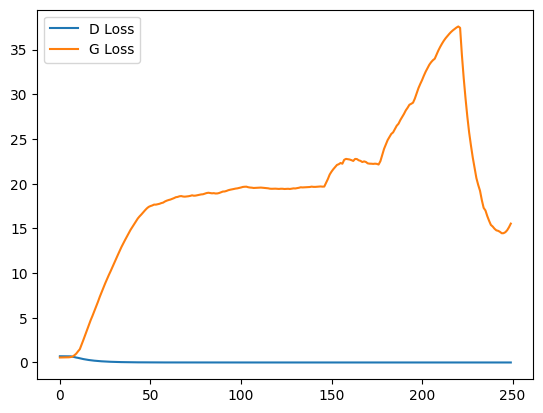

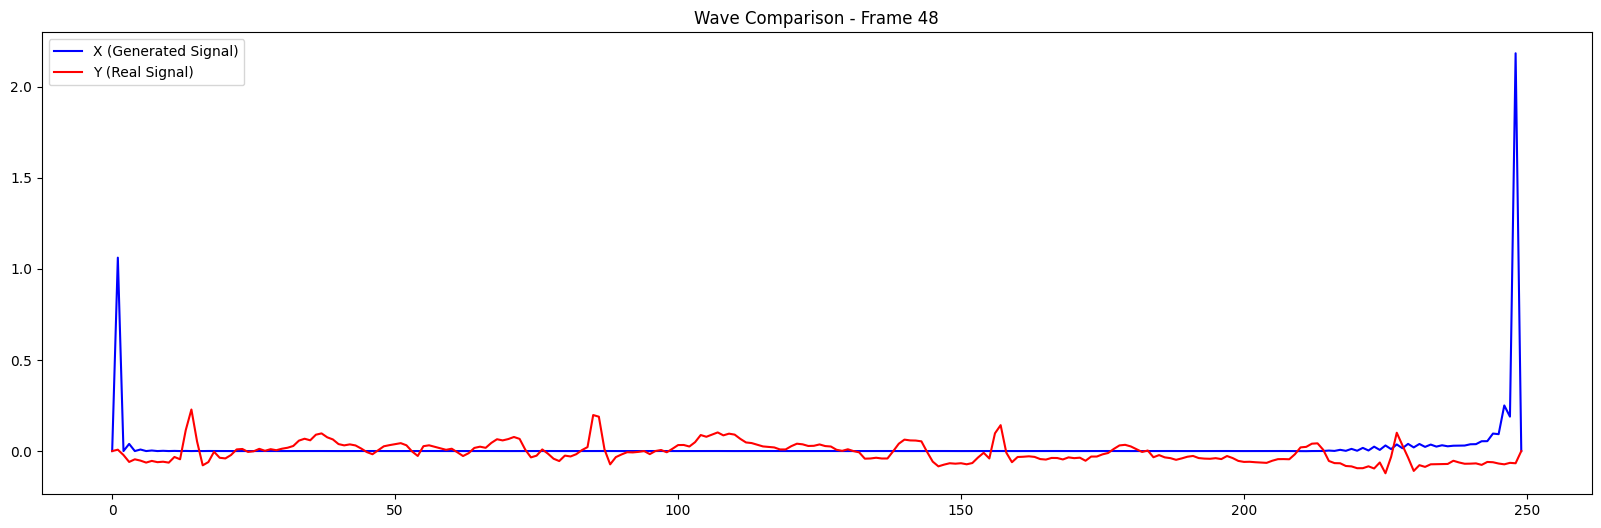

Frame 48:
Mean Squared Error (MSE): 0.0289
Fréchet Distance: 1.9556


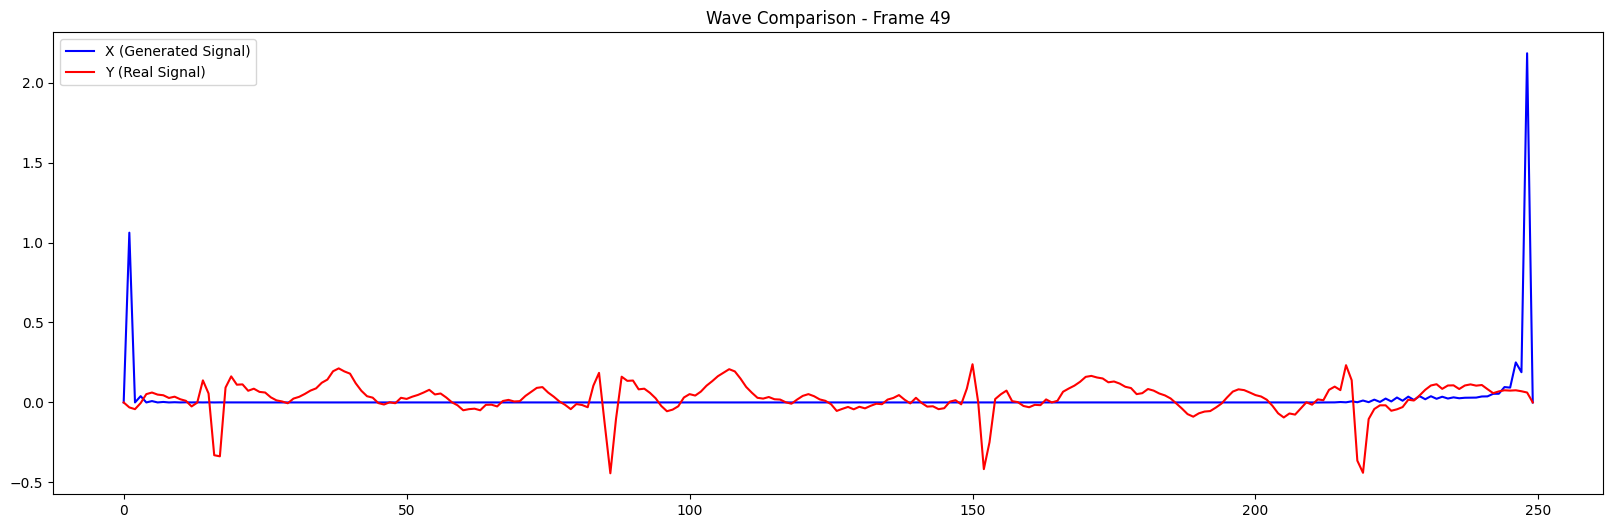

Frame 49:
Mean Squared Error (MSE): 0.0325
Fréchet Distance: 1.9446
Epoch 250/1000, Discrimiator Loss: 9.313225746154785e-09, Generator Loss: 19.182353973388672
Epoch 251/1000, Discrimiator Loss: 3.725290298461914e-09, Generator Loss: 18.663856506347656
Epoch 252/1000, Discrimiator Loss: 0.0, Generator Loss: 17.497177124023438
Epoch 253/1000, Discrimiator Loss: 0.0, Generator Loss: 18.900217056274414
Epoch 254/1000, Discrimiator Loss: 0.0, Generator Loss: 20.985374450683594
Epoch 255/1000, Discrimiator Loss: 0.0, Generator Loss: 19.029726028442383
Epoch 256/1000, Discrimiator Loss: 0.0, Generator Loss: 19.561355590820312
Epoch 257/1000, Discrimiator Loss: 0.0, Generator Loss: 23.951597213745117
Epoch 258/1000, Discrimiator Loss: 0.0, Generator Loss: 24.329696655273438
Epoch 259/1000, Discrimiator Loss: 0.0, Generator Loss: 23.701417922973633


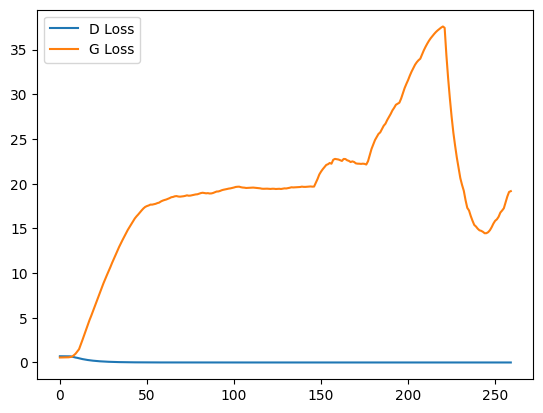

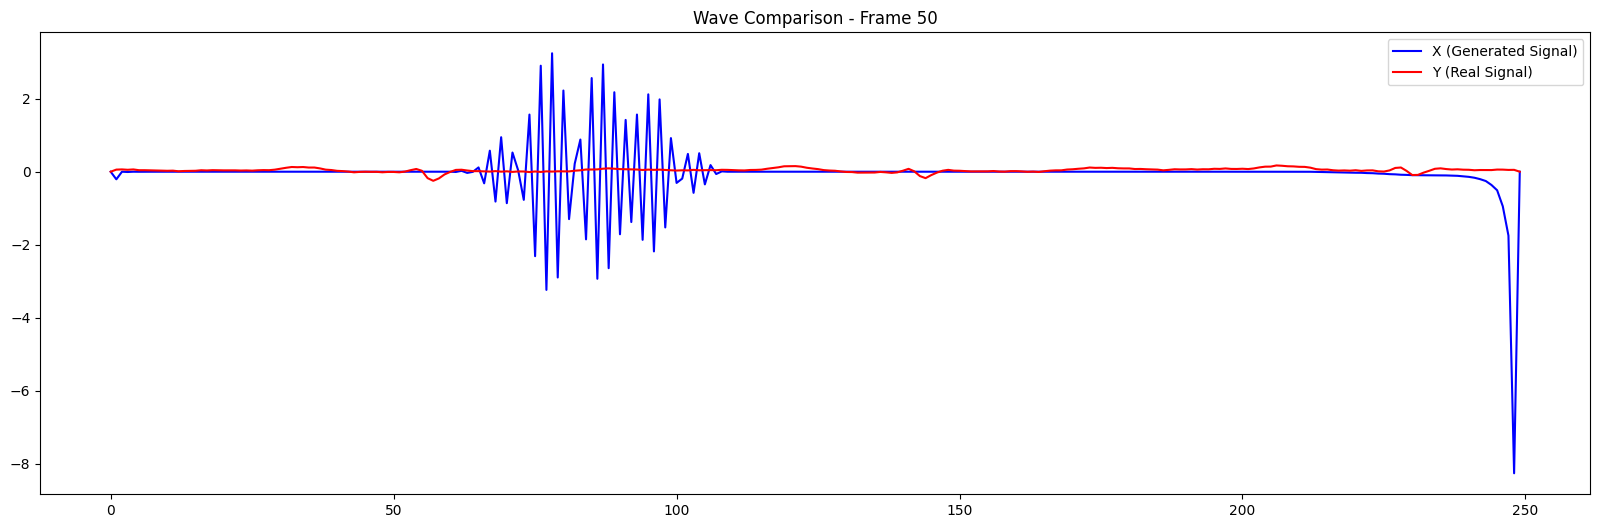

Frame 50:
Mean Squared Error (MSE): 0.8065
Fréchet Distance: 8.0112


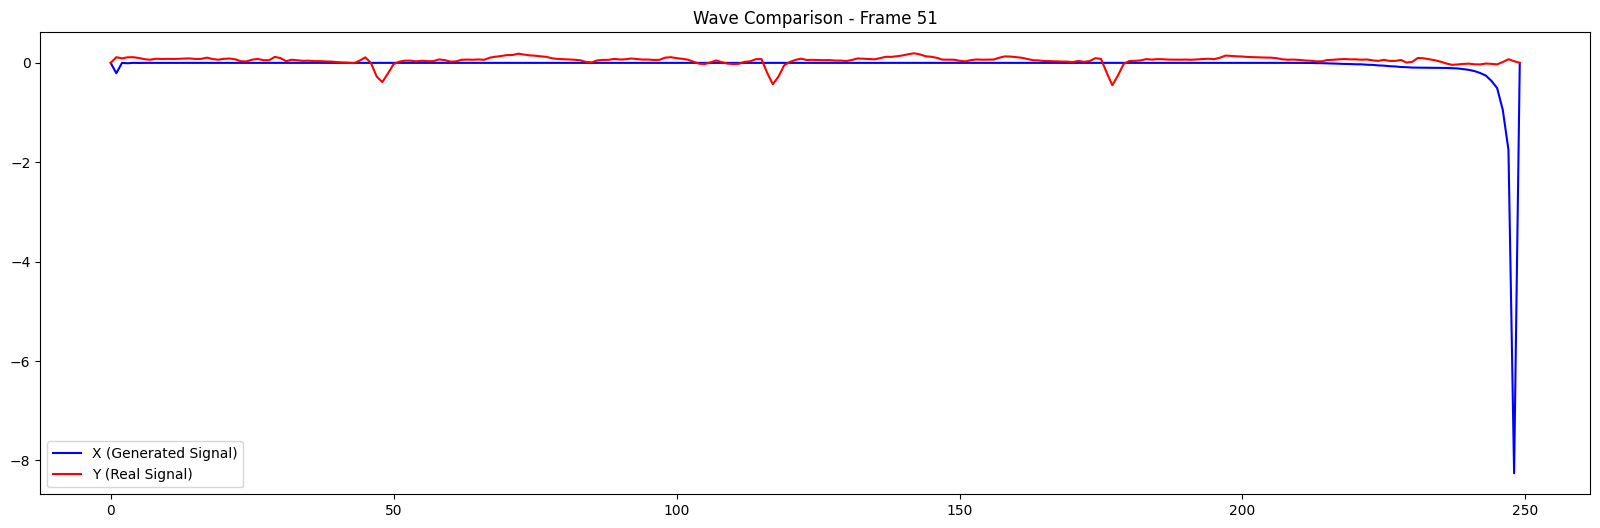

Frame 51:
Mean Squared Error (MSE): 0.3046
Fréchet Distance: 7.8093
Epoch 260/1000, Discrimiator Loss: 0.0, Generator Loss: 19.987056732177734
Epoch 261/1000, Discrimiator Loss: 0.0, Generator Loss: 22.40812110900879
Epoch 262/1000, Discrimiator Loss: 0.0, Generator Loss: 21.701833724975586
Epoch 263/1000, Discrimiator Loss: 0.0, Generator Loss: 22.018856048583984
Epoch 264/1000, Discrimiator Loss: 0.0, Generator Loss: 20.999080657958984
Epoch 265/1000, Discrimiator Loss: 0.0, Generator Loss: 27.75905418395996
Epoch 266/1000, Discrimiator Loss: 0.0, Generator Loss: 24.51849365234375
Epoch 267/1000, Discrimiator Loss: 0.0, Generator Loss: 19.60846710205078
Epoch 268/1000, Discrimiator Loss: 0.0, Generator Loss: 19.470924377441406
Epoch 269/1000, Discrimiator Loss: 0.0, Generator Loss: 15.905928611755371


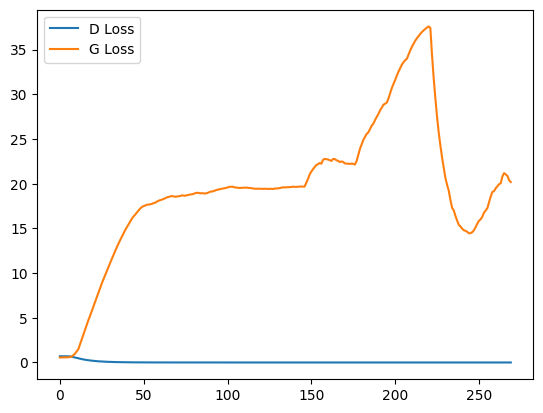

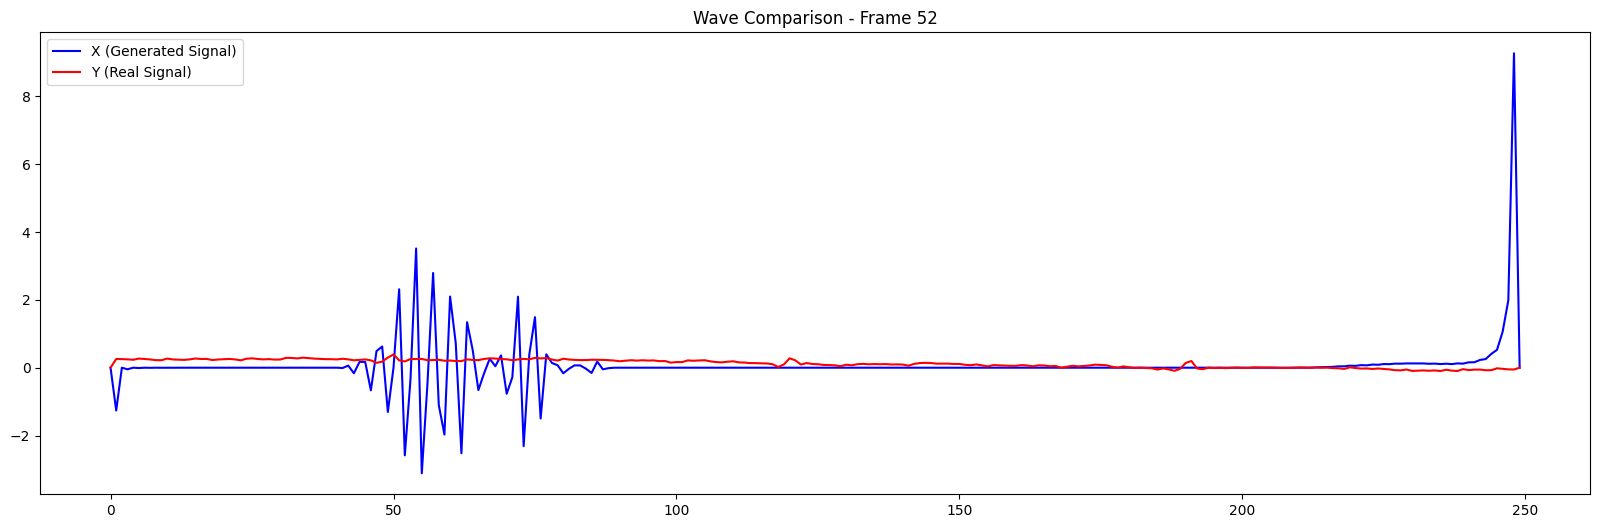

Frame 52:
Mean Squared Error (MSE): 0.7297
Fréchet Distance: 8.8802


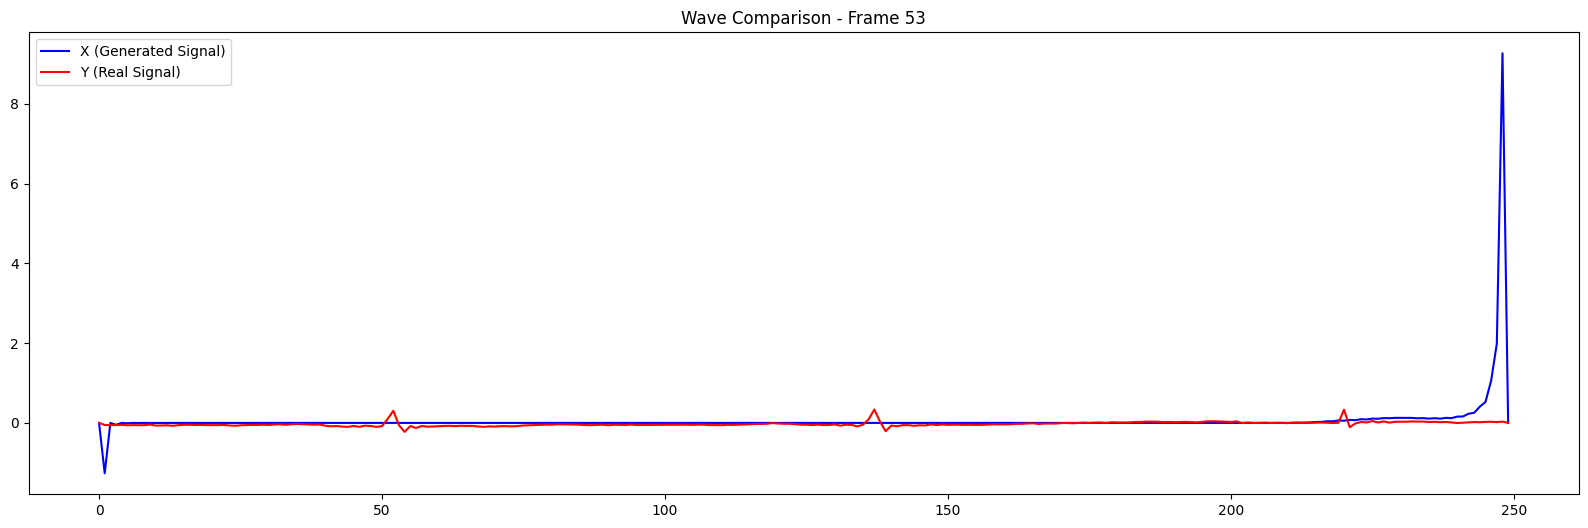

Frame 53:
Mean Squared Error (MSE): 0.3737
Fréchet Distance: 8.9347
Epoch 270/1000, Discrimiator Loss: 1.862645149230957e-08, Generator Loss: 18.498249053955078
Epoch 271/1000, Discrimiator Loss: 1.6763806343078613e-08, Generator Loss: 16.71063232421875
Epoch 272/1000, Discrimiator Loss: 1.862645149230957e-09, Generator Loss: 18.562664031982422
Epoch 273/1000, Discrimiator Loss: 2.7008354663848877e-08, Generator Loss: 18.08597755432129
Epoch 274/1000, Discrimiator Loss: 0.0, Generator Loss: 17.82626724243164
Epoch 275/1000, Discrimiator Loss: 0.0, Generator Loss: 15.838014602661133
Epoch 276/1000, Discrimiator Loss: 0.0, Generator Loss: 15.573837280273438
Epoch 277/1000, Discrimiator Loss: 0.0, Generator Loss: 17.701921463012695
Epoch 278/1000, Discrimiator Loss: 0.0, Generator Loss: 18.106245040893555
Epoch 279/1000, Discrimiator Loss: 0.0, Generator Loss: 15.444783210754395


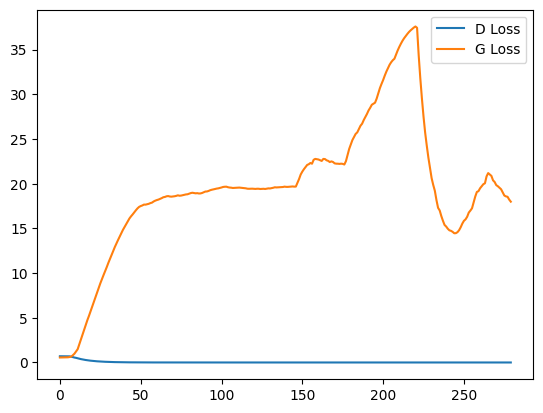

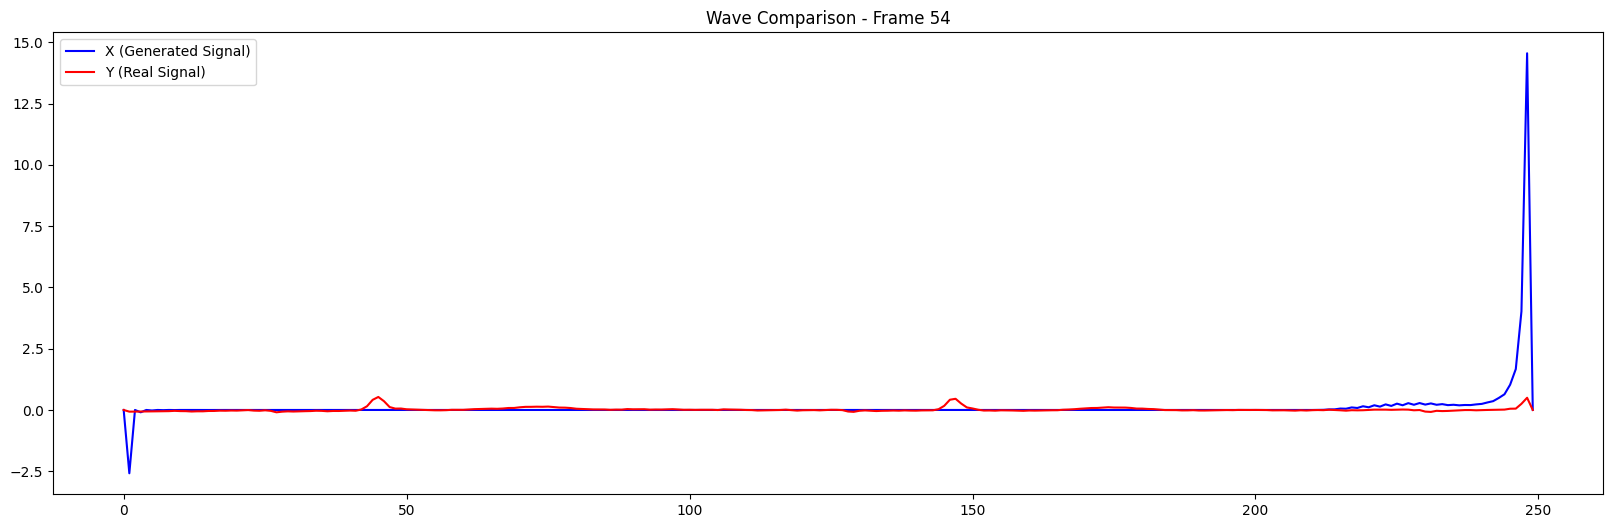

Frame 54:
Mean Squared Error (MSE): 0.9009
Fréchet Distance: 14.0231


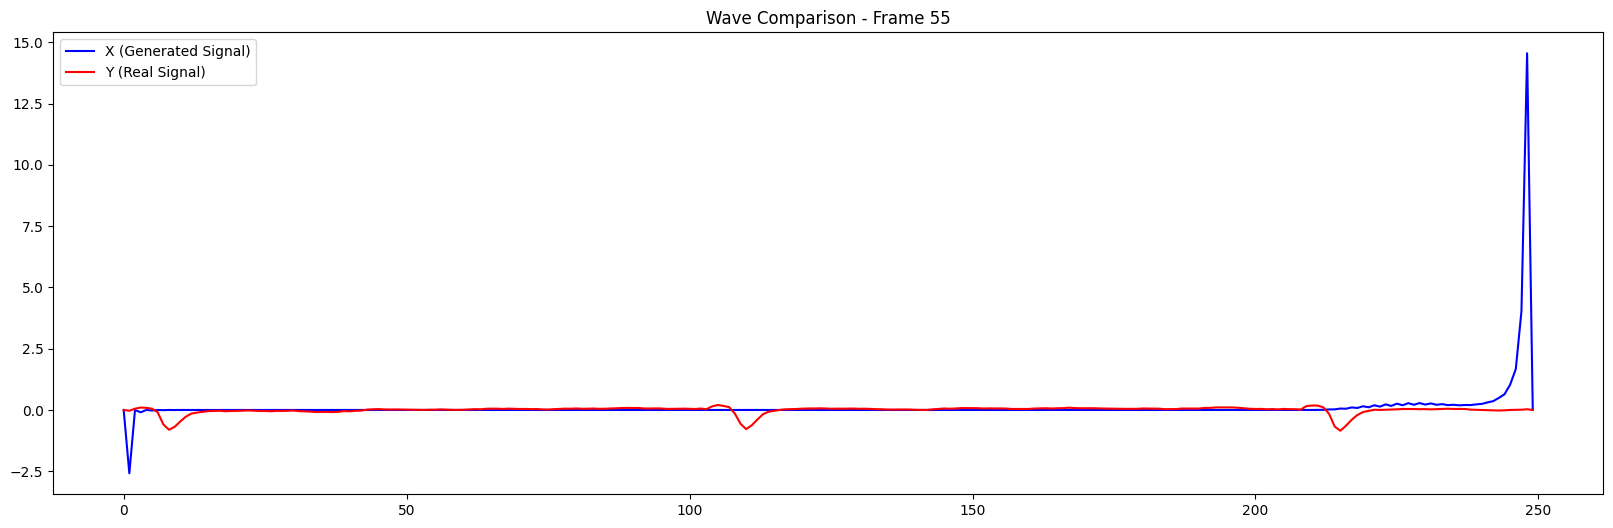

Frame 55:
Mean Squared Error (MSE): 0.9817
Fréchet Distance: 14.3511
Epoch 280/1000, Discrimiator Loss: 0.0, Generator Loss: 15.87362289428711
Epoch 281/1000, Discrimiator Loss: 0.0, Generator Loss: 18.20276641845703
Epoch 282/1000, Discrimiator Loss: 0.0, Generator Loss: 17.63919448852539
Epoch 283/1000, Discrimiator Loss: 3.725290298461914e-09, Generator Loss: 17.81052589416504
Epoch 284/1000, Discrimiator Loss: 7.450580596923828e-09, Generator Loss: 15.753351211547852
Epoch 285/1000, Discrimiator Loss: 5.587936335871291e-09, Generator Loss: 19.74470329284668
Epoch 286/1000, Discrimiator Loss: 0.0, Generator Loss: 19.78917694091797
Epoch 287/1000, Discrimiator Loss: 0.0, Generator Loss: 18.527488708496094
Epoch 288/1000, Discrimiator Loss: 0.0, Generator Loss: 18.064355850219727
Epoch 289/1000, Discrimiator Loss: 0.0, Generator Loss: 20.935148239135742


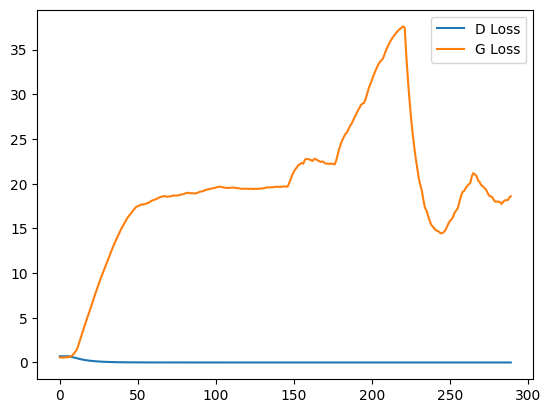

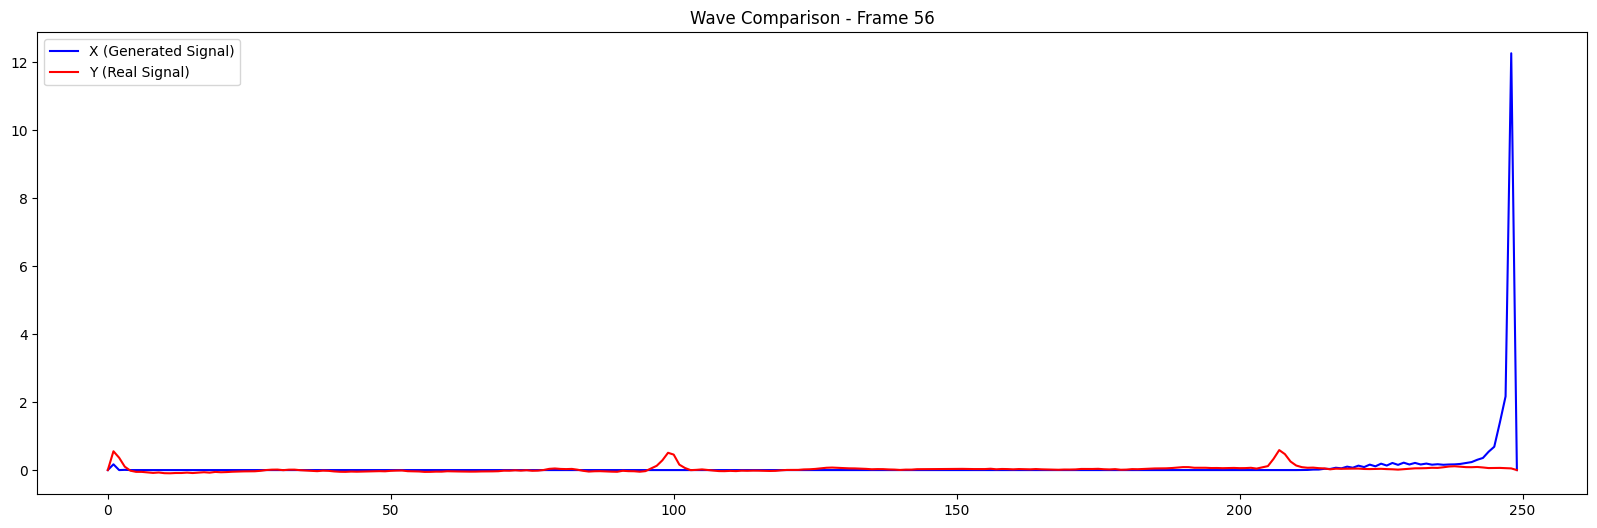

Frame 56:
Mean Squared Error (MSE): 0.6340
Fréchet Distance: 11.6753


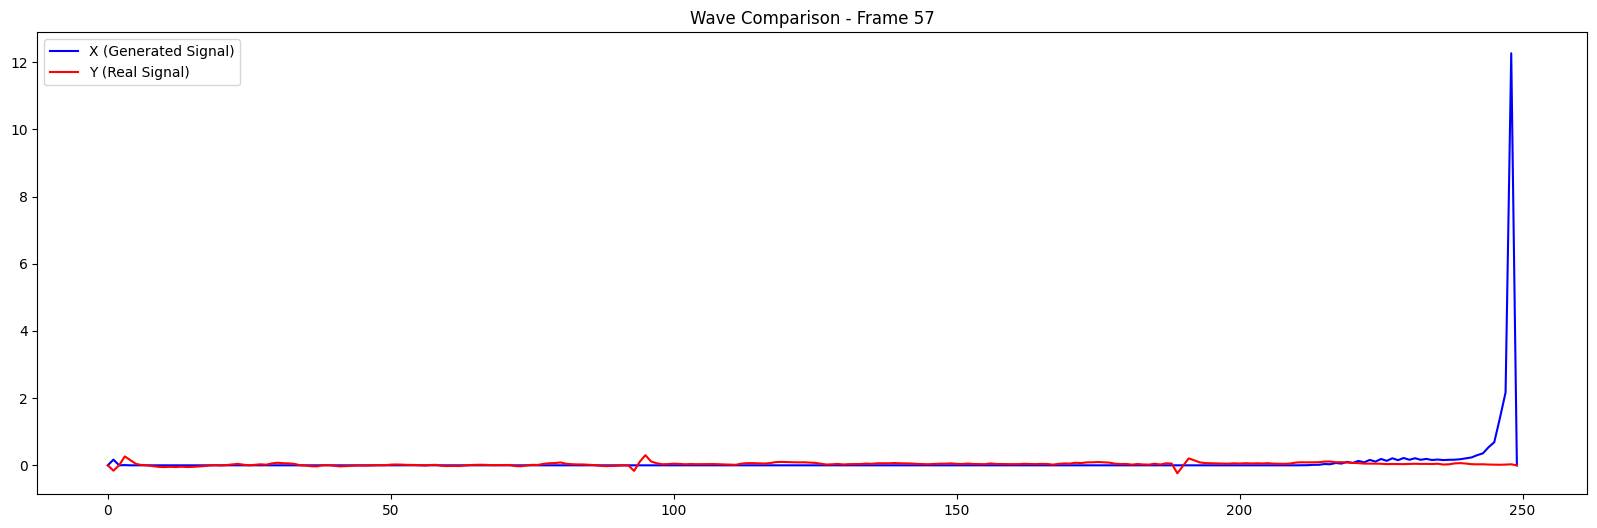

Frame 57:
Mean Squared Error (MSE): 0.6334
Fréchet Distance: 11.9603
Epoch 290/1000, Discrimiator Loss: 0.0, Generator Loss: 20.048450469970703
Epoch 291/1000, Discrimiator Loss: 0.0, Generator Loss: 20.313634872436523
Epoch 292/1000, Discrimiator Loss: 0.0, Generator Loss: 20.833017349243164
Epoch 293/1000, Discrimiator Loss: 0.0, Generator Loss: 20.716455459594727
Epoch 294/1000, Discrimiator Loss: 0.0, Generator Loss: 20.981948852539062
Epoch 295/1000, Discrimiator Loss: 0.0, Generator Loss: 21.03722381591797
Epoch 296/1000, Discrimiator Loss: 0.0, Generator Loss: 22.065187454223633
Epoch 297/1000, Discrimiator Loss: 0.0, Generator Loss: 20.387266159057617
Epoch 298/1000, Discrimiator Loss: 0.0, Generator Loss: 20.0543212890625
Epoch 299/1000, Discrimiator Loss: 0.0, Generator Loss: 20.853668212890625


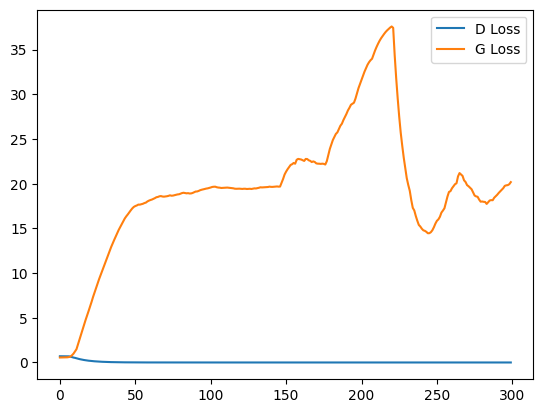

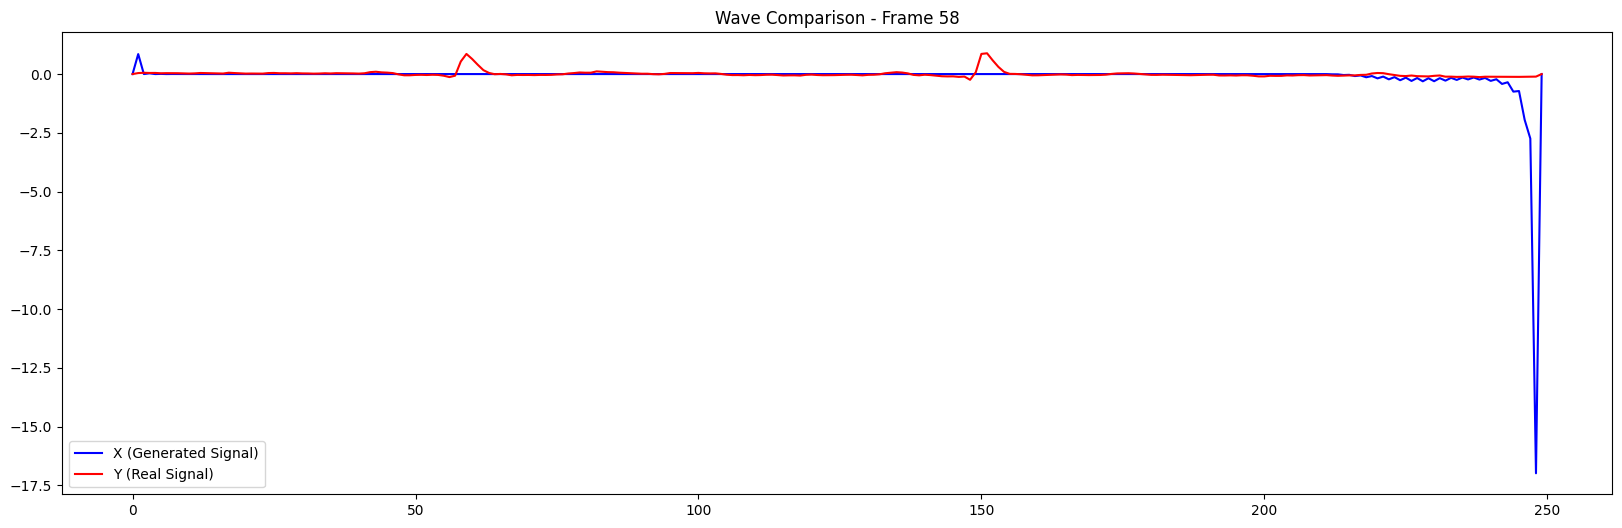

Frame 58:
Mean Squared Error (MSE): 1.2056
Fréchet Distance: 16.7461


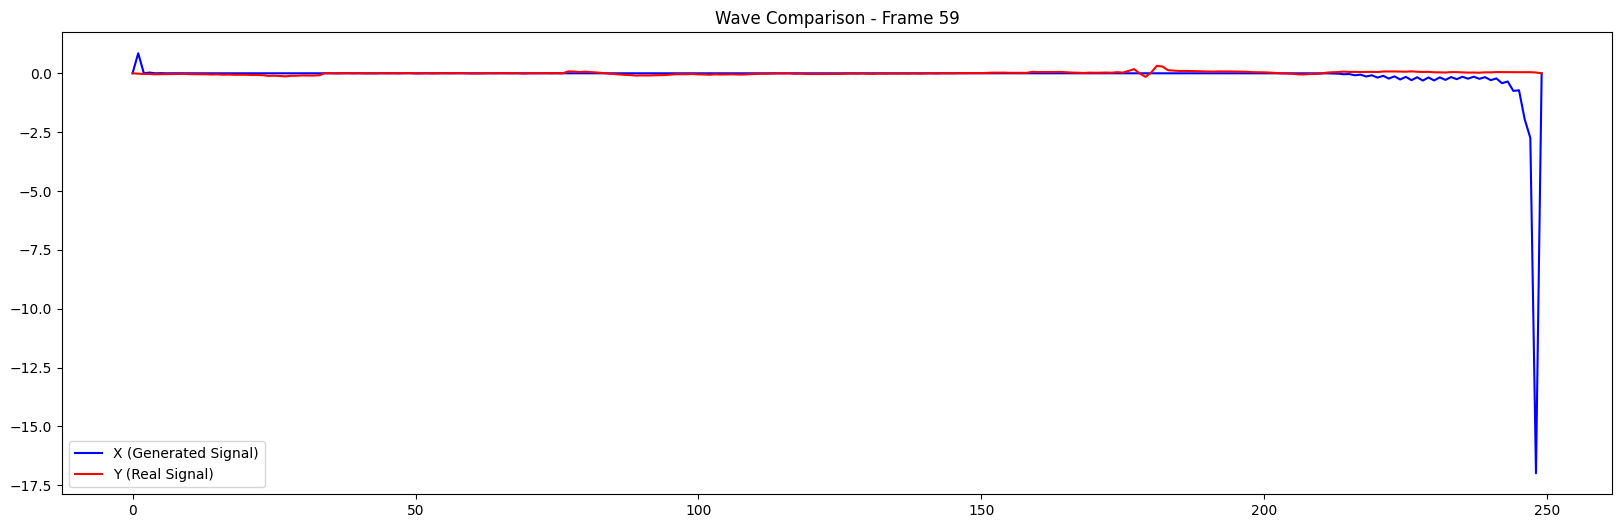

Frame 59:
Mean Squared Error (MSE): 1.2254
Fréchet Distance: 16.8393
Epoch 300/1000, Discrimiator Loss: 0.0, Generator Loss: 22.291767120361328
Epoch 301/1000, Discrimiator Loss: 0.0, Generator Loss: 23.678543090820312
Epoch 302/1000, Discrimiator Loss: 0.0, Generator Loss: 21.916841506958008
Epoch 303/1000, Discrimiator Loss: 0.0, Generator Loss: 22.96237564086914
Epoch 304/1000, Discrimiator Loss: 0.0, Generator Loss: 22.60055160522461
Epoch 305/1000, Discrimiator Loss: 0.0, Generator Loss: 23.099843978881836
Epoch 306/1000, Discrimiator Loss: 0.0, Generator Loss: 22.177204132080078
Epoch 307/1000, Discrimiator Loss: 0.0, Generator Loss: 21.06511688232422
Epoch 308/1000, Discrimiator Loss: 0.0, Generator Loss: 21.950101852416992
Epoch 309/1000, Discrimiator Loss: 0.0, Generator Loss: 23.01706314086914


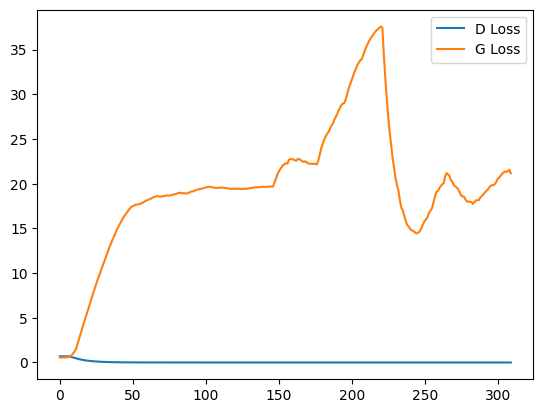

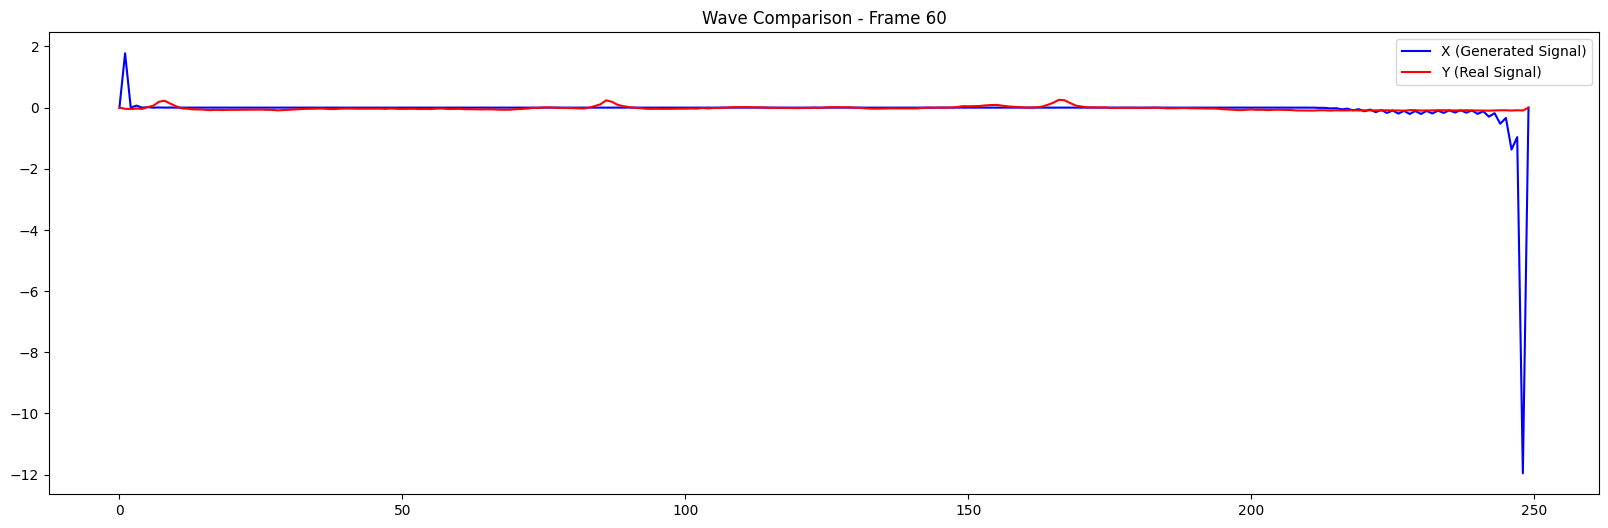

Frame 60:
Mean Squared Error (MSE): 0.5905
Fréchet Distance: 11.8556


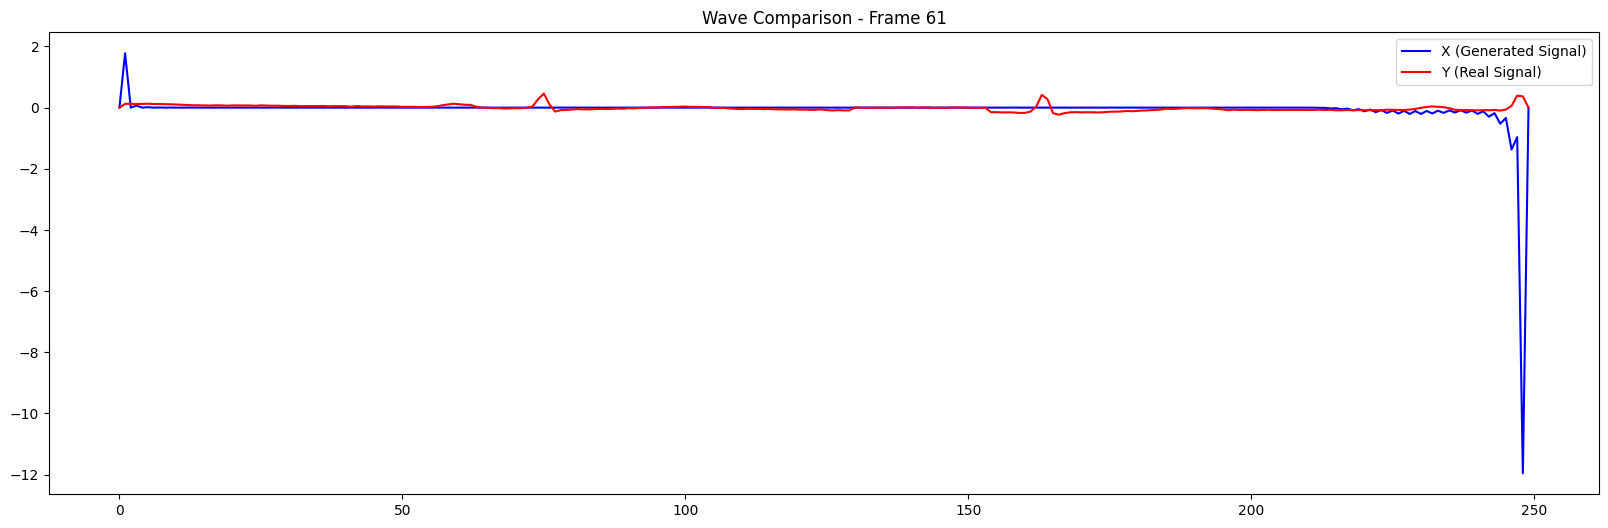

Frame 61:
Mean Squared Error (MSE): 0.6432
Fréchet Distance: 11.7253
Epoch 310/1000, Discrimiator Loss: 0.0, Generator Loss: 17.528411865234375
Epoch 311/1000, Discrimiator Loss: 0.0, Generator Loss: 21.259660720825195
Epoch 312/1000, Discrimiator Loss: 0.0, Generator Loss: 24.05164337158203
Epoch 313/1000, Discrimiator Loss: 0.0, Generator Loss: 21.28152847290039
Epoch 314/1000, Discrimiator Loss: 0.0, Generator Loss: 21.105018615722656
Epoch 315/1000, Discrimiator Loss: 0.0, Generator Loss: 21.505329132080078
Epoch 316/1000, Discrimiator Loss: 0.0, Generator Loss: 24.263437271118164
Epoch 317/1000, Discrimiator Loss: 0.0, Generator Loss: 21.197418212890625
Epoch 318/1000, Discrimiator Loss: 0.0, Generator Loss: 23.02958106994629
Epoch 319/1000, Discrimiator Loss: 0.0, Generator Loss: 20.87066078186035


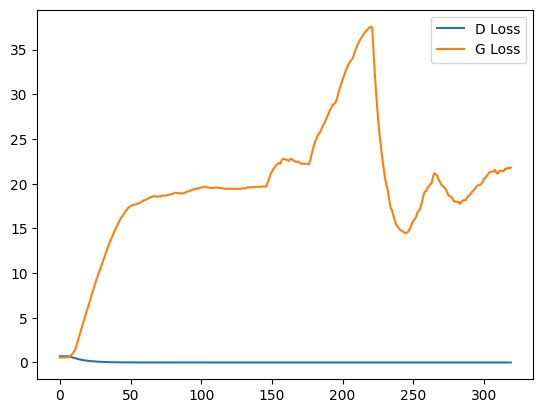

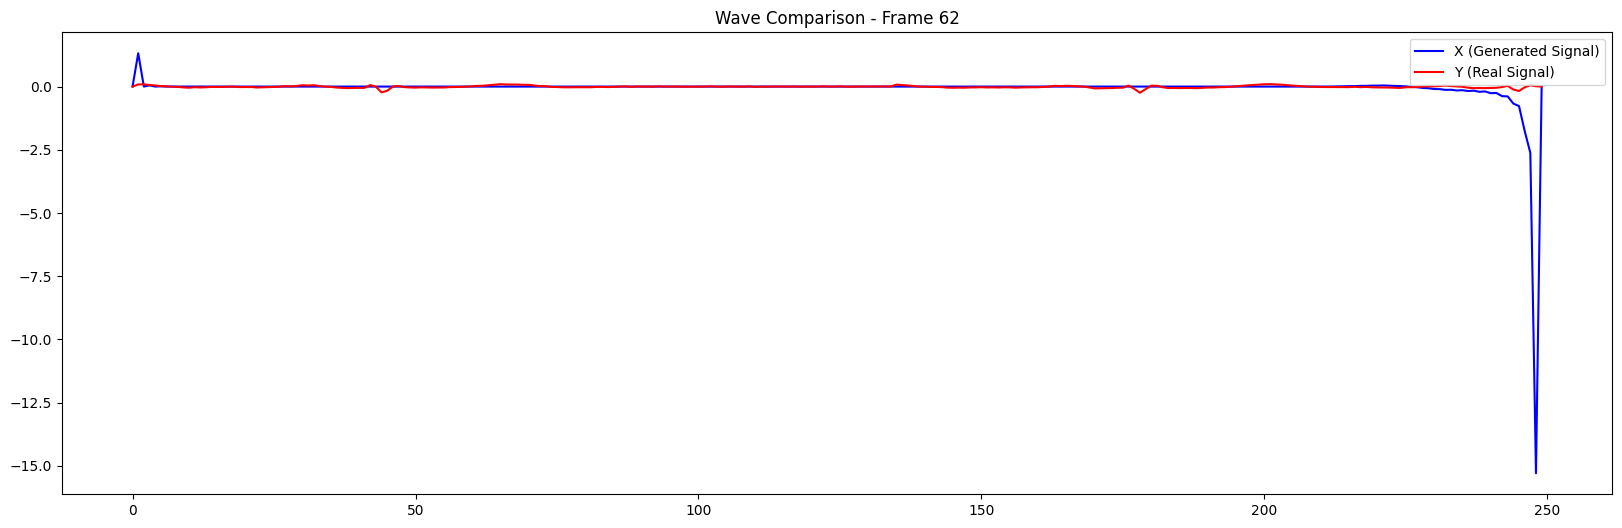

Frame 62:
Mean Squared Error (MSE): 0.9900
Fréchet Distance: 15.0464


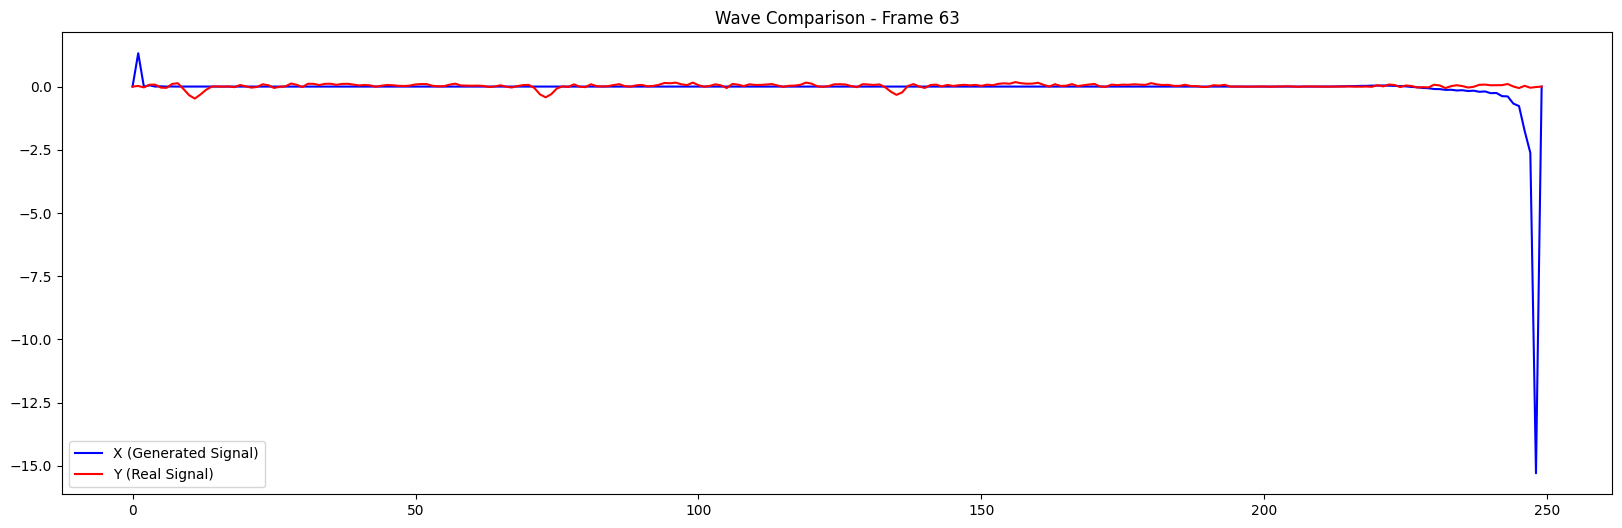

Frame 63:
Mean Squared Error (MSE): 0.9942
Fréchet Distance: 14.8157
Epoch 320/1000, Discrimiator Loss: 0.0, Generator Loss: 22.89426040649414
Epoch 321/1000, Discrimiator Loss: 0.0, Generator Loss: 24.127519607543945
Epoch 322/1000, Discrimiator Loss: 0.0, Generator Loss: 24.373641967773438
Epoch 323/1000, Discrimiator Loss: 0.0, Generator Loss: 24.728931427001953
Epoch 324/1000, Discrimiator Loss: 0.0, Generator Loss: 22.530858993530273


KeyboardInterrupt: 

In [24]:
#ONLY c-GAN training loop
criterion = nn.BCELoss()
g_losses, d_losses = [], []
for epoch in range(epochs):
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(device=device, dtype=torch.float32), real_2.to(device=device, dtype=torch.float32)
        #real_2 += 0.01 * torch.randn_like(real_2)  # Noise augmentation
        # Train Discriminator
        optimizer_d.zero_grad()
        # Generate noise and condition
        
        noise = torch.randn_like(real_1)
        gen_input = torch.cat([real_1, noise], dim=1)
        fake_2 = generator(gen_input)
        # Real and fake inputs for discriminator
        d_real_input = torch.cat([real_2, real_1], dim=1)  # [B, 4, 16, 23]
        d_fake_input = torch.cat([fake_2.detach(), real_1], dim=1)  # [B, 4, 16, 23]
        # Discriminator loss
        real_labels = torch.ones(real_1.size(0), 1, device=device)
        fake_labels = torch.zeros(real_1.size(0), 1, device=device)
        d_real_loss = criterion(discriminator(d_real_input), real_labels)
        d_fake_loss = criterion(discriminator(d_fake_input), fake_labels)
        d_loss = (d_real_loss + d_fake_loss)/2
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        gen_input = torch.cat([real_1, torch.randn_like(real_1)], dim=1)
        fake_2 = generator(gen_input)
        d_fake_input = torch.cat([fake_2, real_1], dim=1)
        g_loss = 0.8*criterion(discriminator(d_fake_input), real_labels)  + 0.2 * l1_loss(fake_2, real_2)
        g_loss.backward()
        optimizer_g.step()
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    if (epoch+1)%10==0:
        plot_losses(d_losses, g_losses)
        with torch.no_grad():
            for real_1, real_2 in dataloader:   
                real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
                real_1, real_2 = real_1.to(device), real_2.to(device)
                gen_input = torch.cat([real_1, torch.randn_like(real_1)], dim=1) 
                fake_2 = generator(gen_input)
                counter = plotWave(inverse_STFT(fake_2[0]),inverse_STFT(real_2[0]), counter)
                counter = plotWave(inverse_STFT(fake_2[12]),inverse_STFT(real_2[12]), counter) #random output
                break
    print(f"Epoch {epoch+1}/{epochs}, Discrimiator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}")